## Intro
Here is the ELT pipeline I created. The raw data(bronze layer) are supposed to go into AWS S3, but it costs, instead, I store all the parquet in local computer. The total data amount was 5GB so I only can store some gold layer parquet into snowflake(There is code below, there is an option that I can upload the parquet manually, but I chose to do with the code) Please don't use my snowflake!!! I'm giving my account and password in the code lol 😂😂.

Also the airflow, when running in docker and putting http://localhost:8080/ into web UI, account and password are default(airflow airflow) This one I'm not afraid.

By the way, as for the PySpark, the reason why is that my local environment is a mess. Spark is for spark and BERT is for BERT (the spark python version I use is 3.9, but the version for PyTorch is 3.10 due to the new version). This is why I have to write config in the beginning of all spark session.

### Airflow

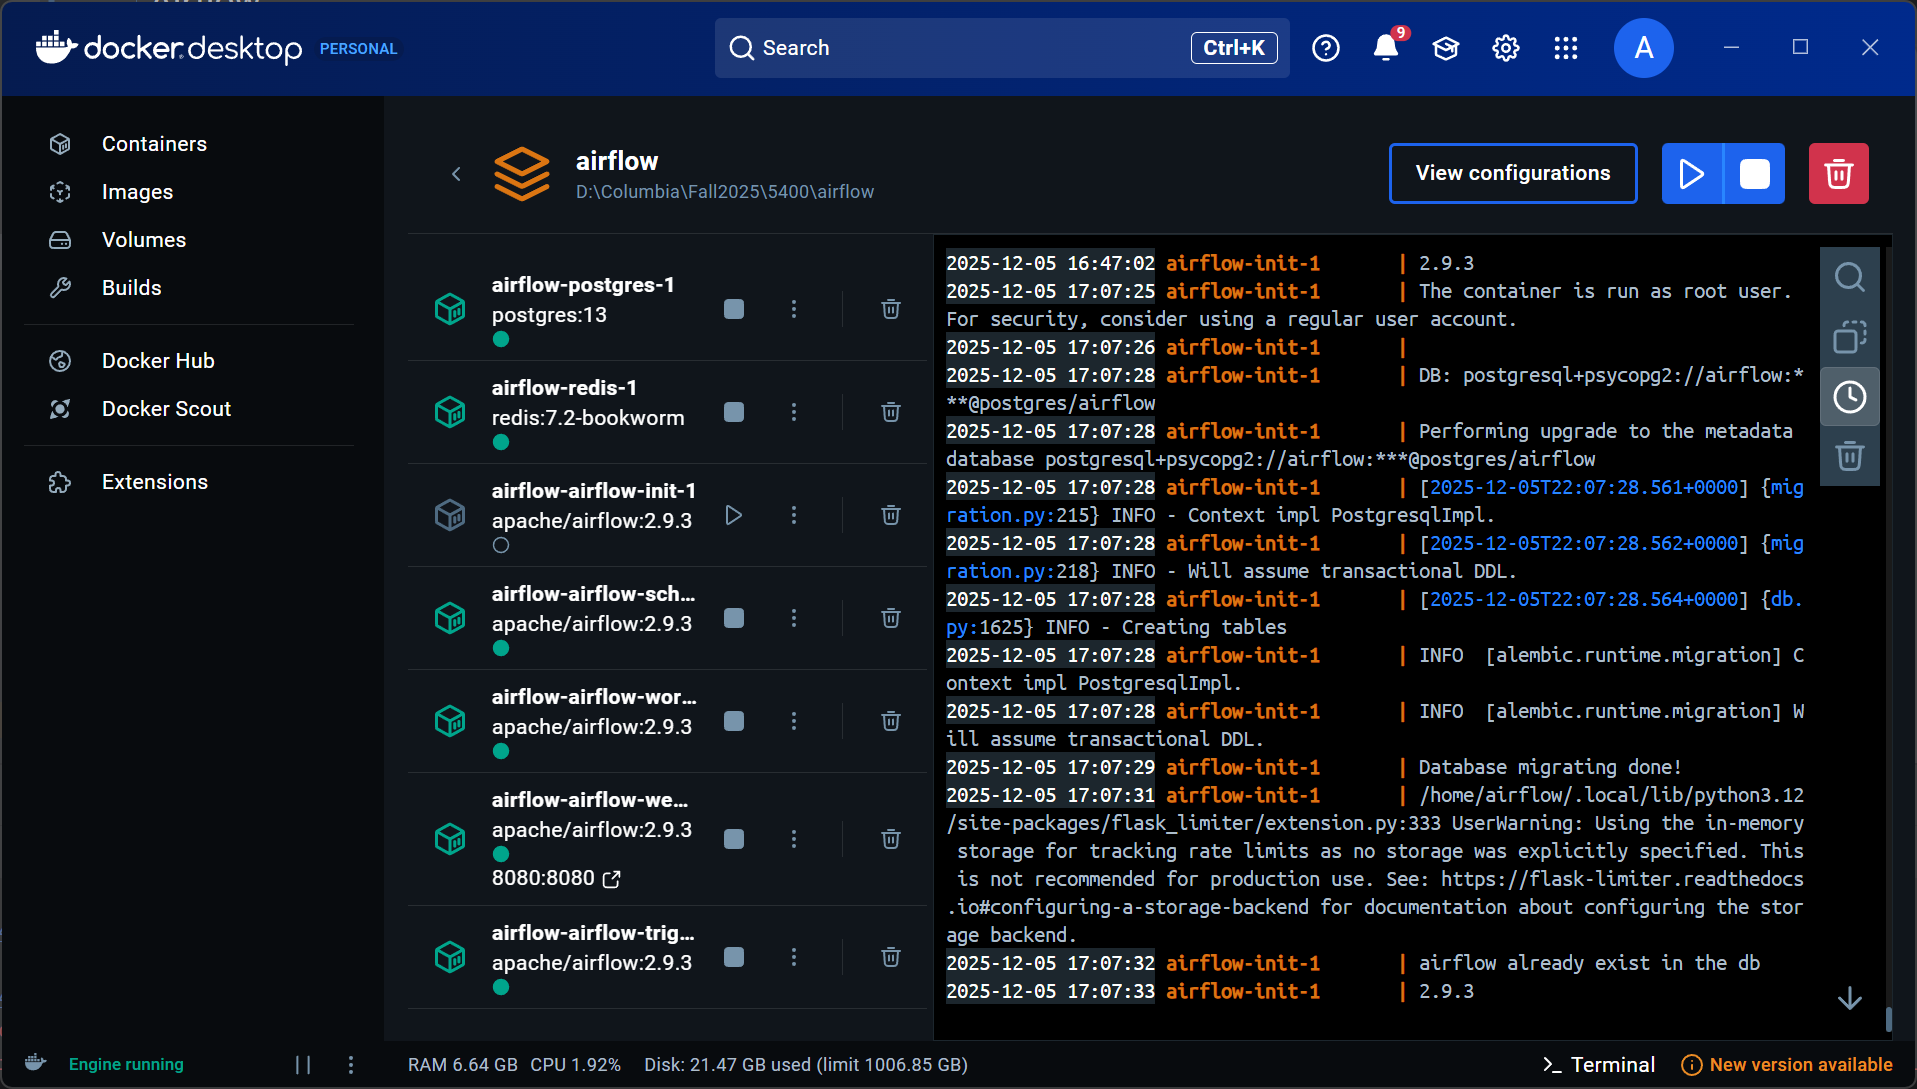

I put airflow in docker container, because windows is not for airflow, I have to try linux or docker. I chose docker in the end. Also the code cannot run in python, it will run automatically in

I will create a demo code below to show my Airflow is actully working, and the final airflow following(put .py into dags to run)

Also I modify the .yaml to store the file into local

demo(working):

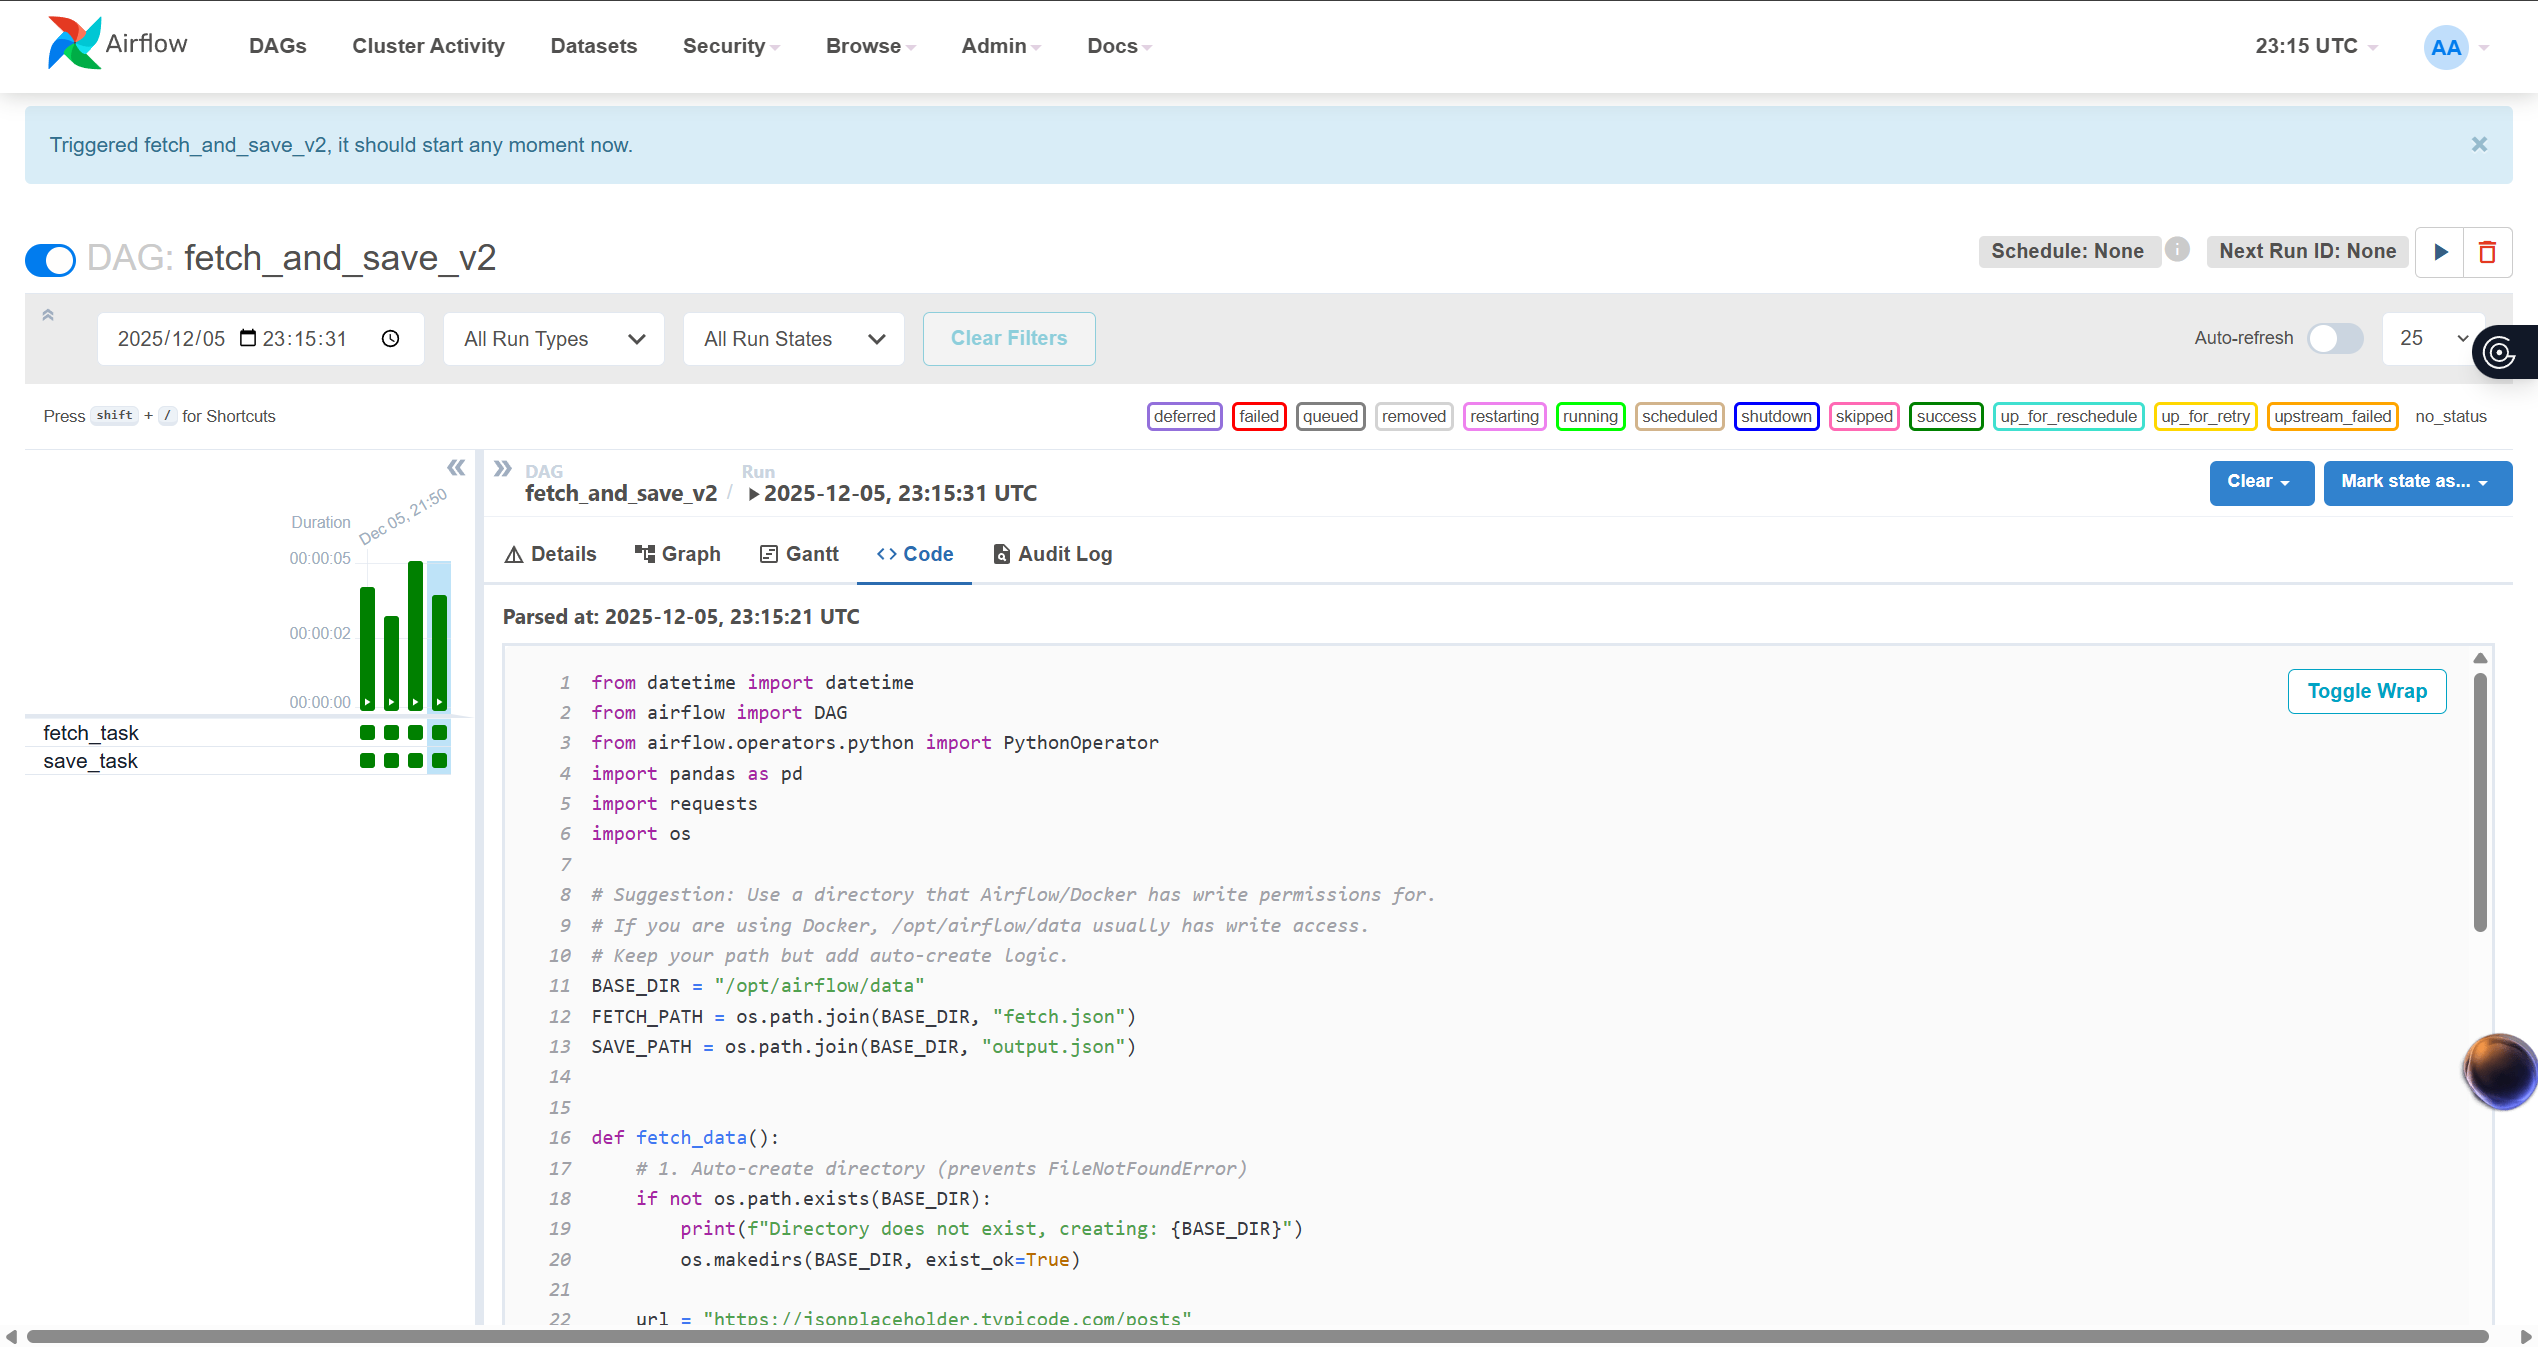

File structure:

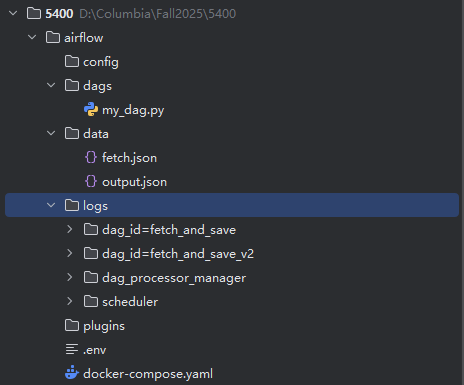
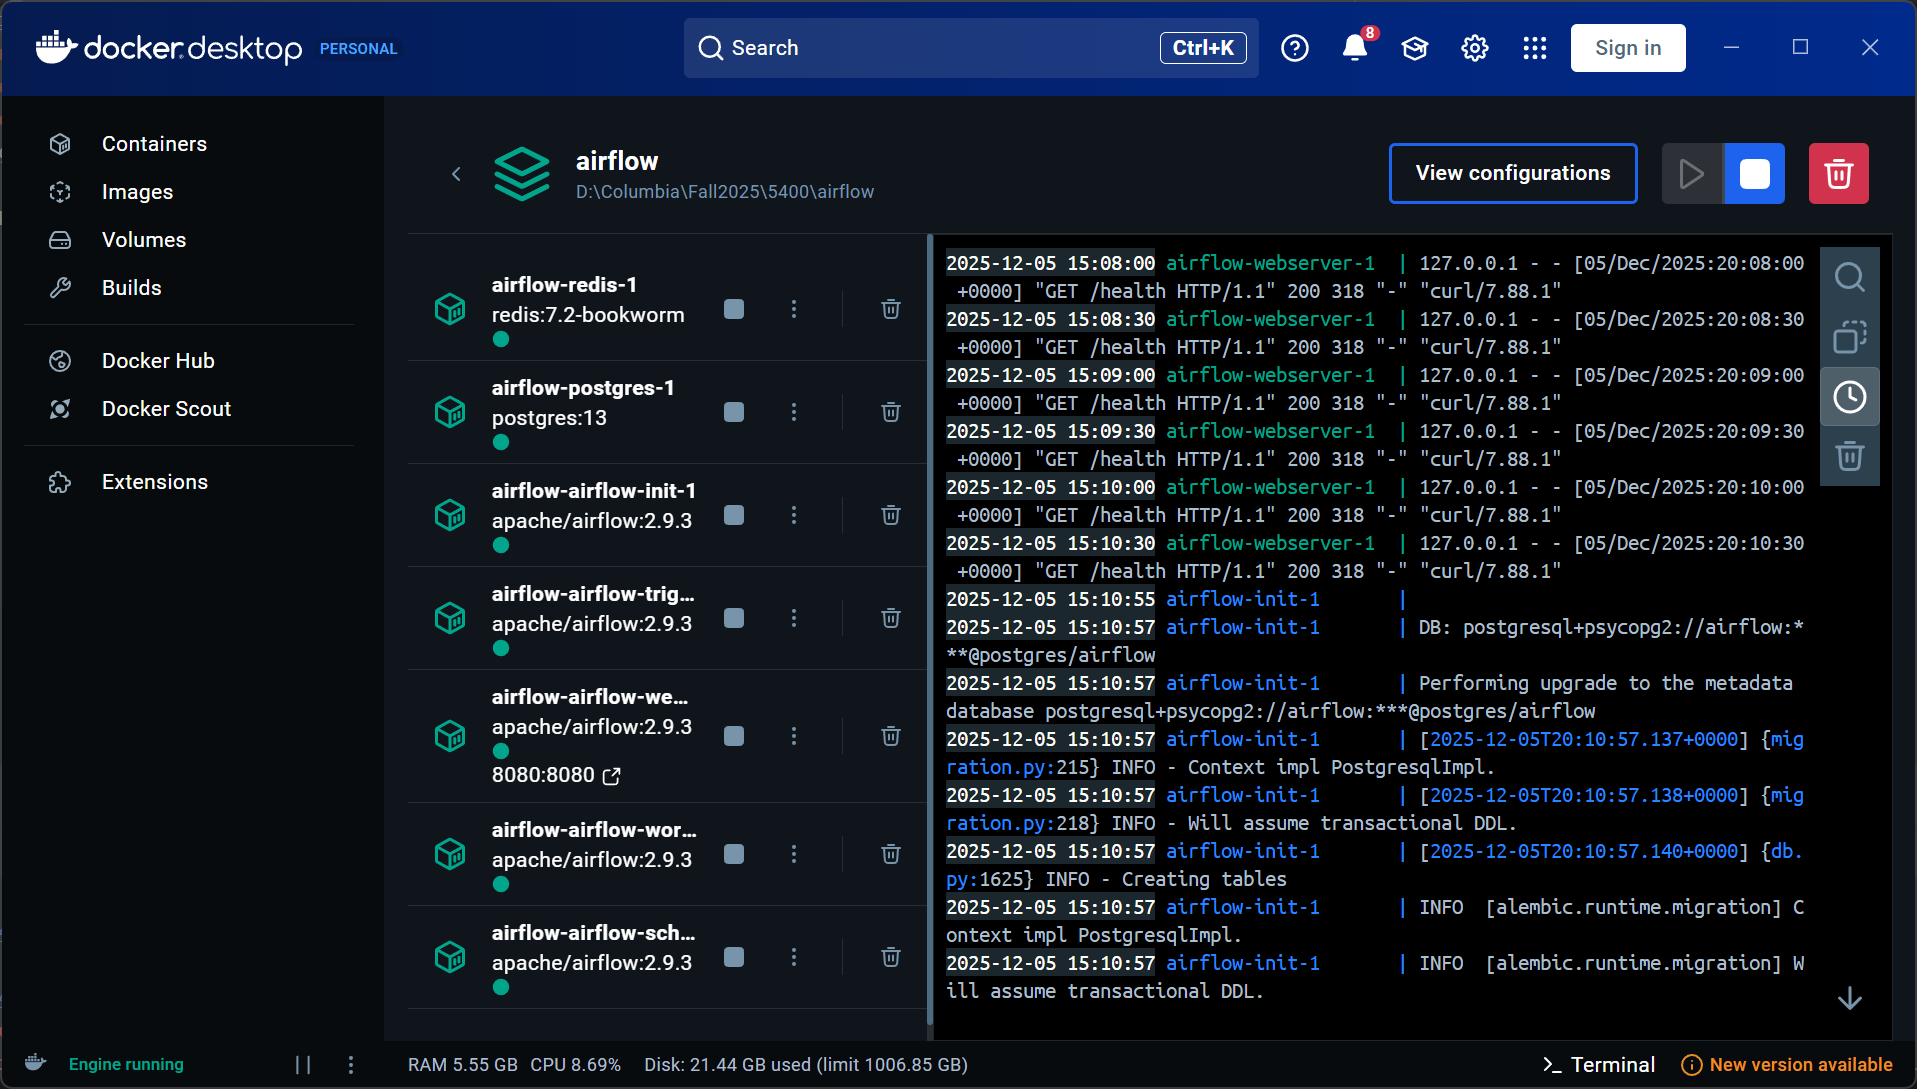
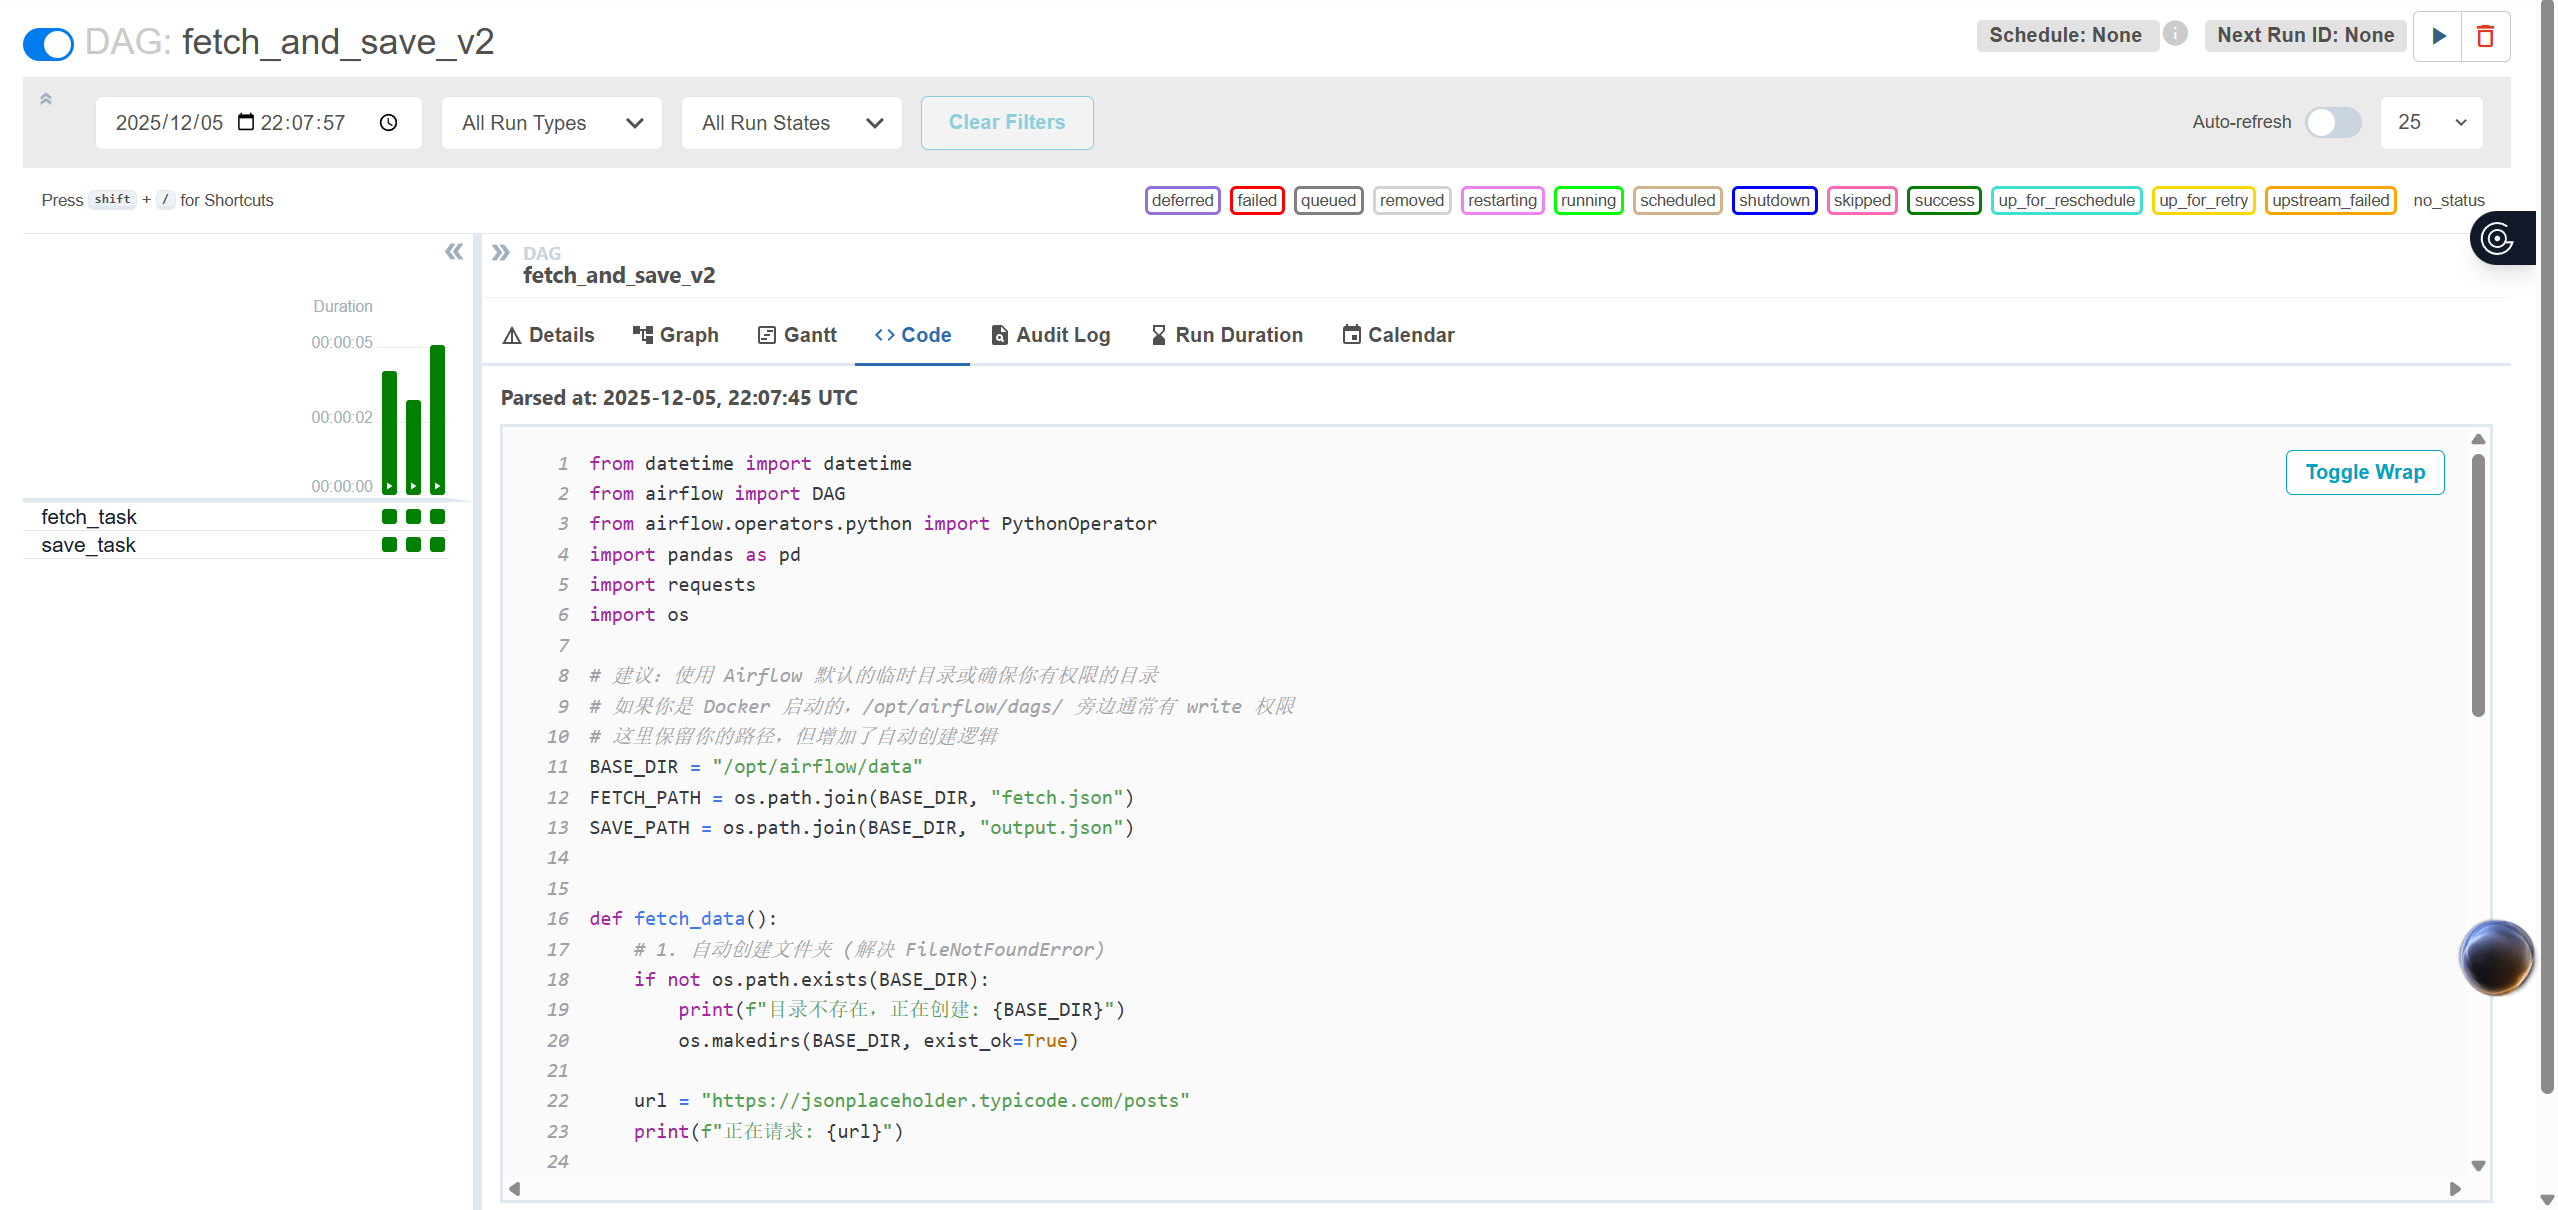
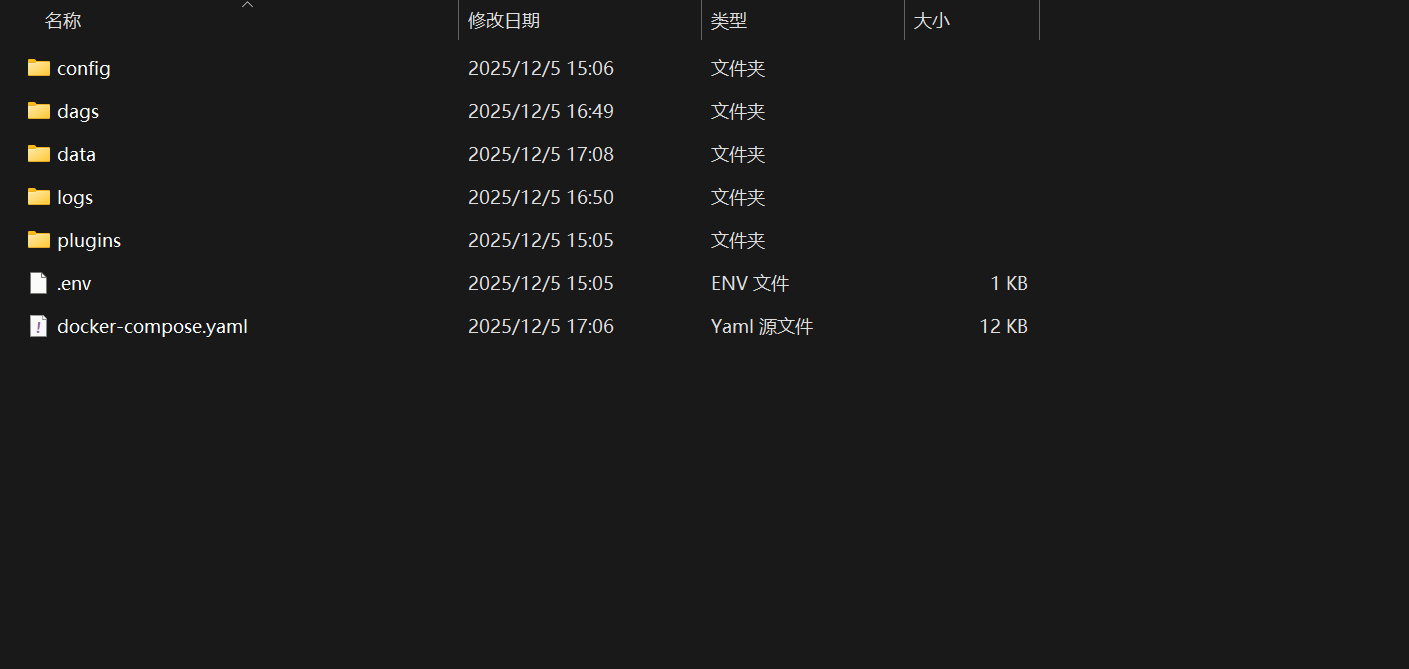
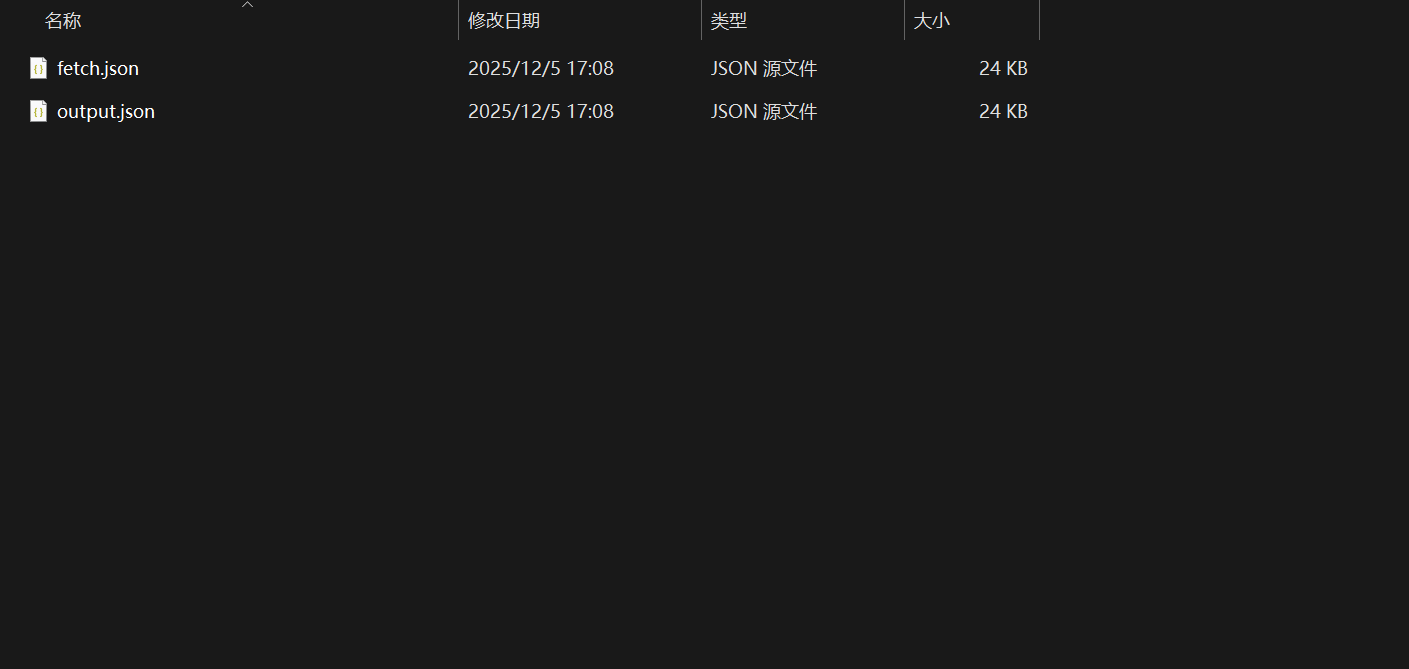
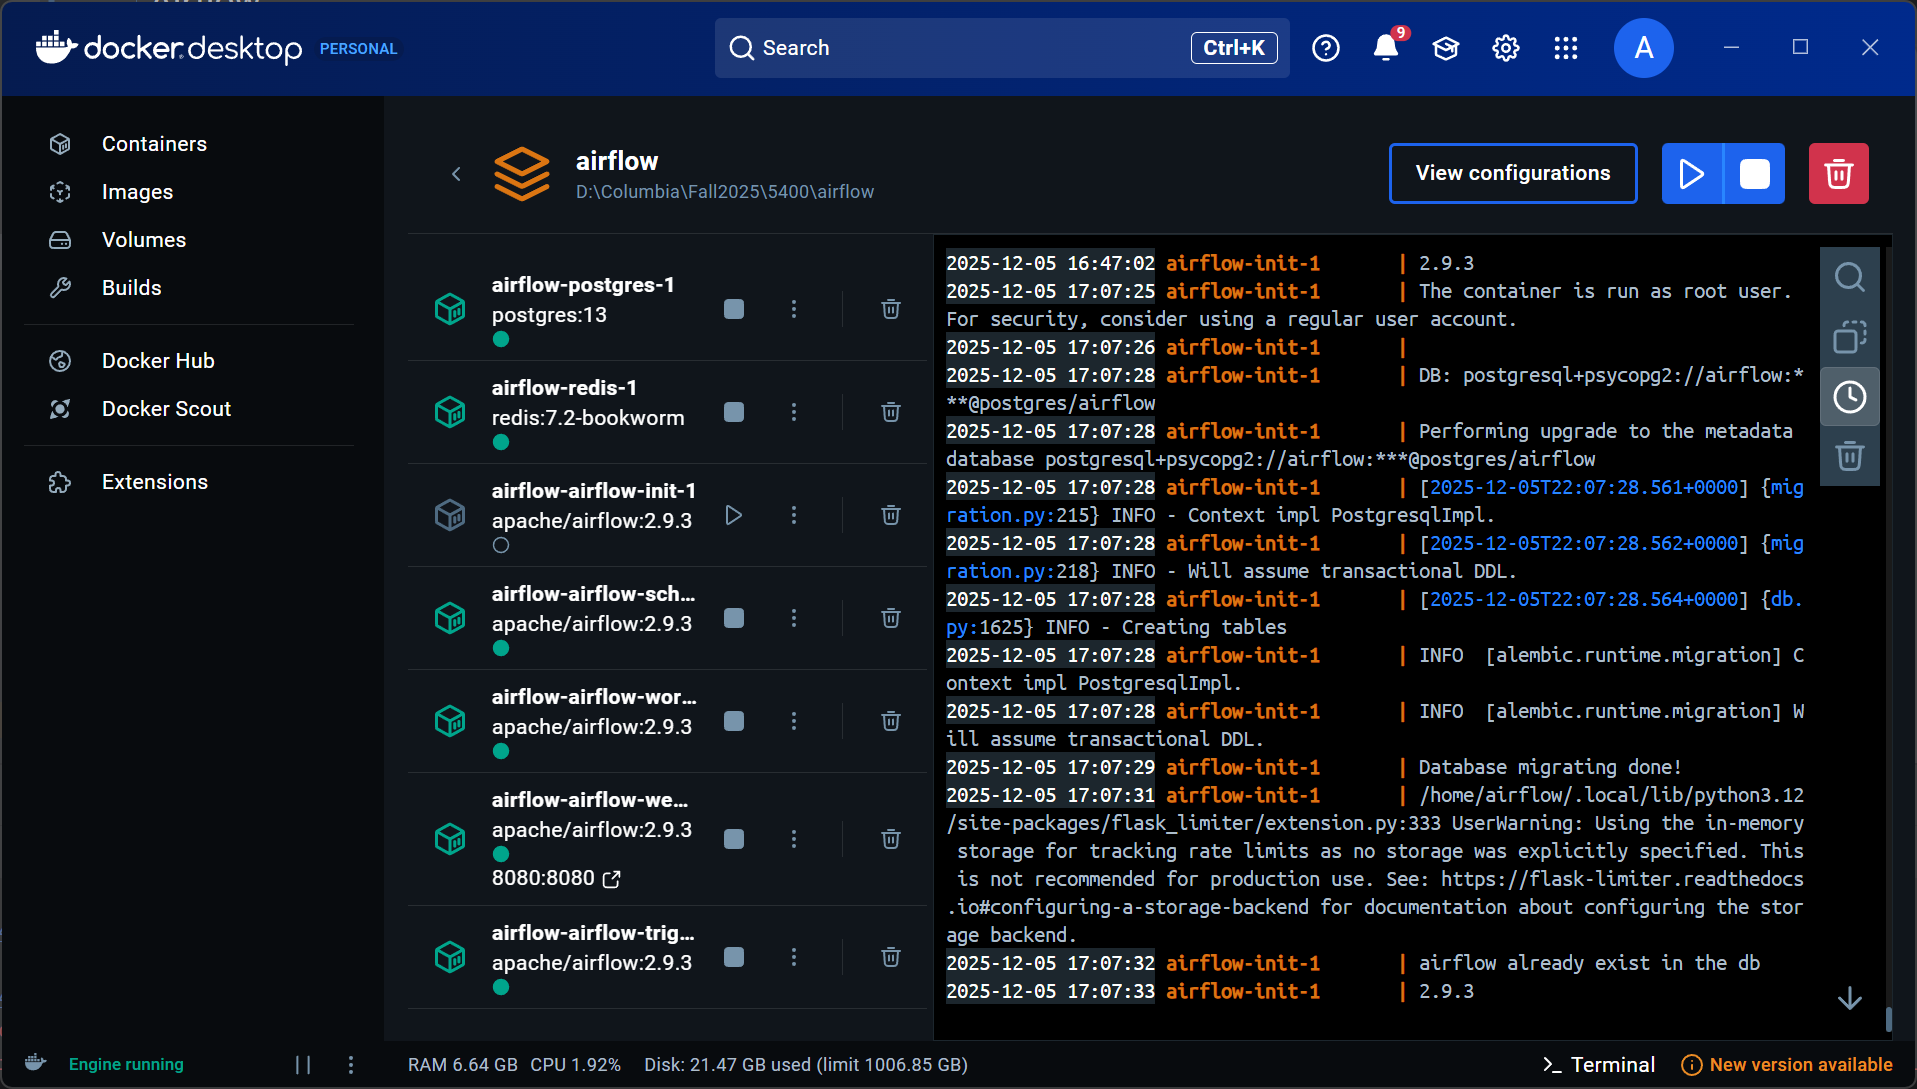

In [ ]:
# demo(try)
from datetime import datetime
from airflow import DAG
from airflow.operators.python import PythonOperator
import pandas as pd
import requests
import os

BASE_DIR = "/opt/airflow/data"
FETCH_PATH = os.path.join(BASE_DIR, "fetch.json")
SAVE_PATH = os.path.join(BASE_DIR, "output.json")


def fetch_data():
    # 1. Auto-create directory (prevents FileNotFoundError)
    if not os.path.exists(BASE_DIR):
        print(f"Directory does not exist, creating: {BASE_DIR}")
        os.makedirs(BASE_DIR, exist_ok=True)

    url = "https://jsonplaceholder.typicode.com/posts"
    print(f"Requesting: {url}")

    try:
        data = requests.get(url).json()
        df = pd.DataFrame(data)

        # Save file
        df.to_json(FETCH_PATH, orient="records")
        print(f"Data successfully saved to: {FETCH_PATH}")

    except Exception as e:
        print(f"Error during fetch stage: {e}")
        raise e  # Raise error so Airflow marks the task as failed


def save_to_local():
    # 2. Check if source file exists
    if not os.path.exists(FETCH_PATH):
        raise FileNotFoundError(f"Source file not found: {FETCH_PATH}. Check if the previous step succeeded.")

    df = pd.read_json(FETCH_PATH)
    df.to_json(SAVE_PATH, orient="records")
    print("Saved final output to:", SAVE_PATH)


with DAG(
        dag_id="fetch_and_save_v2",  # New DAG ID to distinguish from previous version
        start_date=datetime(2024, 1, 1),
        schedule_interval=None,       # No schedule; manual trigger only
        catchup=False,
) as dag:
    fetch_task = PythonOperator(
        task_id="fetch_task",
        python_callable=fetch_data,
    )

    save_task = PythonOperator(
        task_id="save_task",
        python_callable=save_to_local,
    )

    fetch_task >> save_task


In [2]:
import pandas as pd
df = pd.read_json(r'D:\Columbia\Fall2025\5400\airflow\data\output.json')
df.to_csv(r'D:\Columbia\Fall2025\5400\project\output.csv')
print(f'saved csv to output.csv')

saved csv to output.csv


In [19]:
import os
import pandas as pd

BASE_DIR = os.getcwd()
print("Working directory:", BASE_DIR)

csv_path = os.path.join(BASE_DIR, "output.csv")
df = pd.read_csv(csv_path)
df.head()

Working directory: D:\Columbia\Fall2025\5400\project


Unnamed: 0  userId  id                                              title  \
0           0       1   1  sunt aut facere repellat provident occaecati e...   
1           1       1   2                                       qui est esse   
2           2       1   3  ea molestias quasi exercitationem repellat qui...   
3           3       1   4                               eum et est occaecati   
4           4       1   5                                 nesciunt quas odio   

                                                body  
0  quia et suscipit\nsuscipit recusandae consequu...  
1  est rerum tempore vitae\nsequi sint nihil repr...  
2  et iusto sed quo iure\nvoluptatem occaecati om...  
3  ullam et saepe reiciendis voluptatem adipisci\...  
4  repudiandae veniam quaerat sunt sed\nalias aut...

#### Real API data
The real API costs, so I will only write a demo about it (if have to run it, pay it and get the API key, simple modification is enough)

In [ ]:
from datetime import datetime, timedelta
from airflow import DAG
from airflow.operators.python import PythonOperator
import pandas as pd
import requests
import os
import time
import pendulum  # Built-in library for timezone management

# 1. Configuration

# Define the Timezone (US/Eastern), handling Daylight Savings automatically.
local_tz = pendulum.timezone("America/New_York")

# path (D:\Columbia\Fall2025\5400\airflow\data)
BASE_DIR = "/opt/airflow/data"
SAVE_DIR_TEMPLATE = os.path.join(BASE_DIR, "news_data")

# API Configuration (Replace with actual API details)
API_KEY = "API_KEY"
API_BASE_URL = "https://api.com/news"  # Replace with real URL
TARGET_COUNT = 1000  # Target number of articles(Also can be modified)

# 2. Core Logic
def fetch_1000_news(**kwargs):
    """
    Fetches news data with pagination until 1000 records are collected.
    """
    # Ensure directory exists
    if not os.path.exists(SAVE_DIR_TEMPLATE):
        print(f"Creating directory: {SAVE_DIR_TEMPLATE}")
        os.makedirs(SAVE_DIR_TEMPLATE, exist_ok=True)

    # Get execution date string (YYYY-MM-DD) from Airflow context
    date_str = kwargs['ds']

    all_articles = []
    page = 1
    page_size = 100  # Assuming API allows 100 items per page

    print(f"[{date_str}] Starting fetch job. Target: {TARGET_COUNT} articles...")

    while len(all_articles) < TARGET_COUNT:
        try:
            # Construct parameters for pagination
            # Update these keys ('page', 'limit', 'api_key') based on your specific API docs
            params = {
                "date": date_str,
                "page": page,
                "limit": page_size,
                "api_key": API_KEY
            }

            print(f"Requesting page {page}...")

            # REAL API CALL (Uncomment and adapt below)
            # response = requests.get(API_BASE_URL, params=params, timeout=20)
            # response.raise_for_status()
            # data = response.json().get('data', []) # Adjust 'data' to the actual key

            # MOCK DATA (For testing purposes only)
            # Simulating 100 records returned per call
            data = [{"title": f"News Article {i}", "date": date_str, "page": page} for i in range(page_size)]
            time.sleep(0.5) # simulate network delay

            if not data:
                print("API returned no data. Stopping fetch.")
                break

            all_articles.extend(data)
            print(f"Collected so far: {len(all_articles)} records")

            # Stop if we received fewer items than requested (implies last page)
            if len(data) < page_size:
                print("Reached the last page of results.")
                break

            page += 1
            # Sleep to respect API rate limits
            time.sleep(1)

        except Exception as e:
            print(f"Error fetching page {page}: {e}")
            raise e

    # Trim to exactly 1000 if we over-fetched
    final_data = all_articles[:TARGET_COUNT]

    # Save to JSON
    save_path = os.path.join(SAVE_DIR_TEMPLATE, f"{date_str}.json")

    df = pd.DataFrame(final_data)
    df.to_json(save_path, orient="records", force_ascii=False)

    print(f"SUCCESS: Saved {len(df)} records to: {save_path}")
    return save_path

# 3. DAG Definition

default_args = {
    'owner': 'data_engineer',
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
}

with DAG(
    dag_id="daily_news_ingestion_us_time",
    default_args=default_args,
    description='Fetches 1000 news articles daily at 9 AM EST/EDT',

    # Schedule: 9:00 AM daily
    schedule_interval='0 9 * * *',

    # Start Date: Must be timezone-aware to work correctly with the schedule
    start_date=datetime(2025, 1, 1, tzinfo=local_tz), # can be modified to exact date

    catchup=False,
    tags=['news', 'etl']
) as dag:

    fetch_task = PythonOperator(
        task_id="fetch_news_1000",
        python_callable=fetch_1000_news,
        provide_context=True  # Essential for accessing 'ds' (date string)
    )

    fetch_task

### Demo

In [3]:
from pyspark.sql import SparkSession

def create_spark(app_name="5400-news-elt"):
    spark = (
        SparkSession.builder
        .appName(app_name)
        .master("local[*]")
        .config("spark.driver.memory", "12g")
        .config("spark.executor.memory", "12g")
        .config("spark.sql.shuffle.partitions", "400")
        .config("spark.default.parallelism", "400")
        .config("spark.sql.files.maxRecordsPerFile", "200000")
        .config("spark.sql.parquet.compression.codec", "snappy")
        .getOrCreate()
    )
    spark.sparkContext.setLogLevel("WARN")
    print("🔥 Spark Ready:", spark.version)
    return spark

### Real financial data from hugging face

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Zihan1004/FNSPID")
dataset["train"].to_pandas().to_csv("All_external.csv", index=False)

In [4]:
import os
from pyspark.sql import functions as F
from pyspark.sql import types as T

BASE = r"D:\Columbia\Fall2025\5400\project\layer"
CSV_PATH = r"D:\Columbia\Fall2025\5400\project\All_external.csv"

BRONZE = os.path.join(BASE, "bronze")
SILVER = os.path.join(BASE, "silver")
GOLD = os.path.join(BASE, "gold")
NLP_SILVER = os.path.join(BASE, "silver_for_nlp")

### Bronze / Silver / Gold ELT

In [5]:
def build_bronze(spark):
    os.makedirs(BRONZE, exist_ok=True)

    print("📥 Loading CSV...")
    df = (
        spark.read.format("csv")
        .options(
            header="true",
            inferSchema="true",
            multiLine="true",
            escape="\"",
            quote="\"",
            mode="PERMISSIVE"
        )
        .load(CSV_PATH)
    )

    # Cleaning string columns
    for c, t in df.dtypes:
        if t == "string":
            df = df.withColumn(c, F.trim(F.col(c)))

    # date
    if "Date" in df.columns:
        df = df.withColumn("Date", F.to_date("Date", "yyyy-MM-dd"))

    df = df.repartition(400)

    print("💾 Writing Bronze...")
    df.write.mode("overwrite").parquet(BRONZE)
    print("🥉 Bronze Ready:", BRONZE)

    return df

In [ ]:
def build_silver(spark):
    os.makedirs(SILVER, exist_ok=True)
    df = spark.read.parquet(BRONZE)

    # key fields not null
    if "Date" in df.columns:
        df = df.filter(F.col("Date").isNotNull())
    if "Stock_symbol" in df.columns:
        df = df.filter(F.col("Stock_symbol").isNotNull())

    # drop duplicates
    df = df.dropDuplicates()

    # standardize text fields
    if "Publisher" in df.columns:
        df = df.withColumn("Publisher_norm", F.upper("Publisher"))
    if "Author" in df.columns:
        df = df.withColumn("Author_norm", F.upper("Author"))

    # unique ID
    df = df.withColumn("news_id", F.monotonically_increasing_id())

    # repartition
    df = df.repartition(400, "Stock_symbol", "Date")

    print("💾 Writing Silver...")
    df.write.mode("overwrite").parquet(SILVER)
    print("🥈 Silver Ready:", SILVER)

    return df

In [ ]:
def build_gold(spark):
    os.makedirs(GOLD, exist_ok=True)
    df = spark.read.parquet(SILVER)

    df = df.withColumn("title_len", F.length("Article_title"))

    agg_cols = [
        F.count("*").alias("article_count"),
        F.countDistinct("Publisher").alias("publisher_count"),
        F.avg("title_len").alias("avg_title_len"),
    ]

    for col in ["Textrank_summary", "Lsa_summary", "Luhn_summary", "Lexrank_summary"]:
        if col in df.columns:
            agg_cols.append(F.first(col, ignorenulls=True).alias("sample_summary"))
            break

    gold_df = df.groupBy("Date", "Stock_symbol").agg(*agg_cols)
    gold_df = gold_df.repartition(200, "Stock_symbol")

    print("💾 Writing Gold...")
    gold_df.write.mode("overwrite").parquet(GOLD)
    print("🥇 Gold Ready:", GOLD)

    return gold_df

In [6]:
def build_silver_nlp(spark):
    os.makedirs(NLP_SILVER, exist_ok=True)

    df = spark.read.parquet(SILVER)

    # auto select text column
    df = df.withColumn(
        "text",
        F.coalesce(
            F.col("Article"),
            F.col("Textrank_summary"),
            F.col("Lsa_summary"),
            F.col("Luhn_summary"),
            F.col("Lexrank_summary"),
            F.col("Article_title"),   # solve empty text cases
        )
    )

    # filter non-empty text
    df = df.filter(F.col("text").isNotNull() & (F.length(F.trim("text")) > 0))

    df = df.select(
        "news_id", "Date", "Article_title", "Stock_symbol",
        "Publisher", "Author", "Url", "text"
    ).repartition(200)

    df.write.mode("overwrite").parquet(NLP_SILVER)

    print("🧠 Silver_for_nlp done:", NLP_SILVER)
    return df

In [7]:
spark = create_spark()

bronze_df = build_bronze(spark)
silver_df = build_silver(spark)
gold_df   = build_gold(spark)
nlp_df    = build_silver_nlp(spark)

🔥 Spark Ready: 3.3.1
📥 Loading CSV...
💾 Writing Bronze...
🥉 Bronze Ready: D:\Columbia\Fall2025\5400\project\layer\bronze
💾 Writing Silver...
🥈 Silver Ready: D:\Columbia\Fall2025\5400\project\layer\silver
💾 Writing Gold...
🥇 Gold Ready: D:\Columbia\Fall2025\5400\project\layer\gold
🧠 Silver_for_nlp done: D:\Columbia\Fall2025\5400\project\layer\silver_for_nlp


### Schema Inspection in Sliver Layer

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

SILVER = r"D:\Columbia\Fall2025\5400\project\layer\silver"

df = spark.read.parquet(SILVER)

print(df.columns)

df.printSchema()

['Date', 'Article_title', 'Stock_symbol', 'Url', 'Publisher', 'Author', 'Article', 'Lsa_summary', 'Luhn_summary', 'Textrank_summary', 'Lexrank_summary', 'Publisher_norm', 'Author_norm', 'news_id']
root
 |-- Date: date (nullable = true)
 |-- Article_title: string (nullable = true)
 |-- Stock_symbol: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Article: string (nullable = true)
 |-- Lsa_summary: string (nullable = true)
 |-- Luhn_summary: string (nullable = true)
 |-- Textrank_summary: string (nullable = true)
 |-- Lexrank_summary: string (nullable = true)
 |-- Publisher_norm: string (nullable = true)
 |-- Author_norm: string (nullable = true)
 |-- news_id: long (nullable = true)



In [9]:
import pyarrow.dataset as ds

NLP_SILVER = r"D:\Columbia\Fall2025\5400\project\layer\silver_for_nlp"
d = ds.dataset(NLP_SILVER, format="parquet")

print("NLP rows:", d.count_rows())
print("Schema:", d.schema)

NLP rows: 3242351
Schema: news_id: int64
Date: date32[day]
Article_title: string
Stock_symbol: string
Publisher: string
Author: string
Url: string
text: string
-- schema metadata --
org.apache.spark.version: '3.3.1'
org.apache.spark.sql.parquet.row.metadata: '{"type":"struct","fields":[{"' + 517


#### NLP(Silver)


In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

SILVER = r"D:\Columbia\Fall2025\5400\project\layer\silver"
BRONZE = r"D:\Columbia\Fall2025\5400\project\layer\bronze"

silver_df = spark.read.parquet(SILVER)
bronze_df = spark.read.parquet(BRONZE)

print("Bronze rows:", bronze_df.count())
print("Silver rows:", silver_df.count())
silver_df.select("Date").show(5, False)

Bronze rows: 13057514
Silver rows: 3242351
+----------+
|Date      |
+----------+
|2014-04-23|
|2012-02-15|
|2017-04-03|
|2017-02-15|
|2018-03-13|
+----------+
only showing top 5 rows



In [1]:
# FinBERT sentiment
import os
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

# Paths
BASE = r"D:\Columbia\Fall2025\5400\project\layer"
NLP_SILVER = os.path.join(BASE, "silver_for_nlp")
SENTIMENT_SAMPLE = os.path.join(BASE, "sentiment_sample")

# Local model cache directory
MODEL_CACHE = r"D:\Columbia\Fall2025\5400\project\models"
os.makedirs(MODEL_CACHE, exist_ok=True)
os.makedirs(SENTIMENT_SAMPLE, exist_ok=True)

# GPU detection
if torch.cuda.is_available() and torch.cuda.device_count() > 0:
    device = 0
    print("✅ Using GPU device 0 for FinBERT")
else:
    device = -1
    print("⚠ CUDA not available, running FinBERT on CPU")

# FinBERT tokenizer & model (with cache_dir)
tokenizer = AutoTokenizer.from_pretrained(
    "ProsusAI/finbert",
    cache_dir=MODEL_CACHE,
)

model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert",
    cache_dir=MODEL_CACHE,
)

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device,
)


# Load dataset from parquet
dataset = ds.dataset(NLP_SILVER, format="parquet")
total_rows = dataset.count_rows()
print("🧠 Total rows for NLP:", total_rows)

BATCH_ROWS = 4000         # number of rows read from parquet each time
PIPELINE_BATCH = 32       # batch_size for HF pipeline
MAX_LENGTH = 256
MAX_ROWS = 3_242_351
processed_rows = 0

batches = dataset.to_batches(batch_size=BATCH_ROWS)

# Main loop
for i, batch in enumerate(batches):

    if processed_rows >= MAX_ROWS:
        print(f"⚡ Reached MAX_ROWS={MAX_ROWS}, stopping early.")
        break

    table = pa.Table.from_batches([batch])
    pdf = table.to_pandas()

    # Filter invalid text
    pdf = pdf[pdf["text"].notna() & (pdf["text"].astype(str).str.strip() != "")]
    if pdf.empty:
        continue

    texts = pdf["text"].astype(str).tolist()

    # 🔥 Run FinBERT sentiment
    preds = sentiment_pipe(
        texts,
        batch_size=PIPELINE_BATCH,
        truncation=True,
        max_length=MAX_LENGTH,
    )

    # FinBERT labels: positive / neutral / negative
    pdf["sentiment_label"] = [p["label"] for p in preds]
    pdf["sentiment_score"] = [float(p["score"]) for p in preds]

    # Signed sentiment score:
    #   positive → +score
    #   negative → -score
    #   neutral  → 0
    pdf["sentiment_score_signed"] = pdf.apply(
        lambda row: (
            row["sentiment_score"]
            if row["sentiment_label"] == "positive"
            else (-row["sentiment_score"] if row["sentiment_label"] == "negative" else 0.0)
        ),
        axis=1,
    )

    # Output columns
    out_pdf = pdf[["news_id", "sentiment_label",
                   "sentiment_score", "sentiment_score_signed"]]

    # Write to parquet
    out_table = pa.Table.from_pandas(out_pdf, preserve_index=False)
    out_file = os.path.join(SENTIMENT_SAMPLE, f"part-{i:05d}.parquet")
    pq.write_table(out_table, out_file)

    processed_rows += len(out_pdf)
    print(f"✅ Batch {i}: wrote {len(out_pdf)} rows, total processed {processed_rows}")

print("🎉 FinBERT Sentiment SAMPLE Completed:", SENTIMENT_SAMPLE)
print("Total processed rows:", processed_rows)


✅ Using GPU device 0 for FinBERT


Device set to use cuda:0


🧠 Total rows for NLP: 3242351
✅ Batch 0: wrote 4000 rows, total processed 4000
✅ Batch 1: wrote 4000 rows, total processed 8000
✅ Batch 2: wrote 4000 rows, total processed 12000
✅ Batch 3: wrote 4000 rows, total processed 16000
✅ Batch 4: wrote 226 rows, total processed 16226
✅ Batch 5: wrote 4000 rows, total processed 20226
✅ Batch 6: wrote 4000 rows, total processed 24226
✅ Batch 7: wrote 4000 rows, total processed 28226
✅ Batch 8: wrote 4000 rows, total processed 32226


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Batch 9: wrote 224 rows, total processed 32450
✅ Batch 10: wrote 4000 rows, total processed 36450
✅ Batch 11: wrote 4000 rows, total processed 40450
✅ Batch 12: wrote 4000 rows, total processed 44450
✅ Batch 13: wrote 4000 rows, total processed 48450
✅ Batch 14: wrote 223 rows, total processed 48673
✅ Batch 15: wrote 4000 rows, total processed 52673
✅ Batch 16: wrote 4000 rows, total processed 56673
✅ Batch 17: wrote 4000 rows, total processed 60673
✅ Batch 18: wrote 4000 rows, total processed 64673
✅ Batch 19: wrote 222 rows, total processed 64895
✅ Batch 20: wrote 4000 rows, total processed 68895
✅ Batch 21: wrote 4000 rows, total processed 72895
✅ Batch 22: wrote 4000 rows, total processed 76895
✅ Batch 23: wrote 4000 rows, total processed 80895
✅ Batch 24: wrote 227 rows, total processed 81122
✅ Batch 25: wrote 4000 rows, total processed 85122
✅ Batch 26: wrote 4000 rows, total processed 89122
✅ Batch 27: wrote 4000 rows, total processed 93122
✅ Batch 28: wrote 4000 rows, total p

In [1]:
# # distilbert(sub for FinBERT)
# import os
# import pyarrow.dataset as ds
# import pyarrow.parquet as pq
# import pyarrow as pa
# import pandas as pd
# from transformers import pipeline
# import torch
#
# BASE = r"D:\Columbia\Fall2025\5400\project\layer"
# NLP_SILVER = os.path.join(BASE, "silver_for_nlp")
# SENTIMENT_SAMPLE = os.path.join(BASE, "sentiment_sample")
# os.makedirs(SENTIMENT_SAMPLE, exist_ok=True)
#
# # 1. GPU
# if torch.cuda.is_available() and torch.cuda.device_count() > 0:
#     device = 0
#     print("✅ Using GPU device 0 for sentiment.")
# else:
#     device = -1
#     print("⚠ 没有可用 CUDA 设备，使用 CPU。")
#
# # 2. HF pipeline
# sentiment_pipe = pipeline(
#     "sentiment-analysis",
#     model="distilbert-base-uncased-finetuned-sst-2-english",
#     device=device,
# )
#
# # 3. prepare dataset
# dataset = ds.dataset(NLP_SILVER, format="parquet")
# total_rows = dataset.count_rows()
# print("🧠 NLP total rows:", total_rows)
#
# BATCH_ROWS = 4000        # read 4000 rows at a time from parquet
# PIPELINE_BATCH = 32      # batch_size
# MAX_LENGTH = 256
# MAX_ROWS = 3242351
# processed_rows = 0
#
# batches = dataset.to_batches(batch_size=BATCH_ROWS)
#
# for i, batch in enumerate(batches):
#     if processed_rows >= MAX_ROWS:
#         print(f"⚡ 已达到 MAX_ROWS={MAX_ROWS}，提前结束。")
#         break
#
#     table = pa.Table.from_batches([batch])
#     pdf = table.to_pandas()
#
#     pdf = pdf[pdf["text"].notna() & (pdf["text"].astype(str).str.strip() != "")]
#     if pdf.empty:
#         continue
#
#     texts = pdf["text"].astype(str).tolist()
#
#     preds = sentiment_pipe(
#         texts,
#         batch_size=PIPELINE_BATCH,
#         truncation=True,
#         max_length=MAX_LENGTH,
#     )
#
#     pdf["sentiment_label"] = [p["label"] for p in preds]
#     pdf["sentiment_score"] = [float(p["score"]) for p in preds]
#     pdf["sentiment_score_signed"] = pdf["sentiment_score"].where(
#         pdf["sentiment_label"] == "POSITIVE",
#         -pdf["sentiment_score"],
#     )
#
#     out_pdf = pdf[["news_id", "sentiment_label",
#                    "sentiment_score", "sentiment_score_signed"]]
#     out_table = pa.Table.from_pandas(out_pdf, preserve_index=False)
#
#     out_file = os.path.join(SENTIMENT_SAMPLE, f"part-{i:05d}.parquet")
#     pq.write_table(out_table, out_file)
#
#     processed_rows += len(out_pdf)
#     print(f"✅ batch {i}, now written {len(out_pdf)} rows，counted {processed_rows} rows")
#
# print("🎉 Sentiment SAMPLE Done:", SENTIMENT_SAMPLE)
# print("实际处理行数:", processed_rows)


✅ Using GPU device 0 for sentiment.


Device set to use cuda:0


🧠 NLP total rows: 3242351
✅ batch 0, 当前写出 4000 行，累计 4000 行
✅ batch 1, 当前写出 4000 行，累计 8000 行
✅ batch 2, 当前写出 4000 行，累计 12000 行
✅ batch 3, 当前写出 4000 行，累计 16000 行
✅ batch 4, 当前写出 226 行，累计 16226 行
✅ batch 5, 当前写出 4000 行，累计 20226 行
✅ batch 6, 当前写出 4000 行，累计 24226 行
✅ batch 7, 当前写出 4000 行，累计 28226 行


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ batch 8, 当前写出 4000 行，累计 32226 行
✅ batch 9, 当前写出 224 行，累计 32450 行
✅ batch 10, 当前写出 4000 行，累计 36450 行
✅ batch 11, 当前写出 4000 行，累计 40450 行
✅ batch 12, 当前写出 4000 行，累计 44450 行
✅ batch 13, 当前写出 4000 行，累计 48450 行
✅ batch 14, 当前写出 223 行，累计 48673 行
✅ batch 15, 当前写出 4000 行，累计 52673 行
✅ batch 16, 当前写出 4000 行，累计 56673 行
✅ batch 17, 当前写出 4000 行，累计 60673 行
✅ batch 18, 当前写出 4000 行，累计 64673 行
✅ batch 19, 当前写出 222 行，累计 64895 行
✅ batch 20, 当前写出 4000 行，累计 68895 行
✅ batch 21, 当前写出 4000 行，累计 72895 行
✅ batch 22, 当前写出 4000 行，累计 76895 行
✅ batch 23, 当前写出 4000 行，累计 80895 行
✅ batch 24, 当前写出 227 行，累计 81122 行
✅ batch 25, 当前写出 4000 行，累计 85122 行
✅ batch 26, 当前写出 4000 行，累计 89122 行
✅ batch 27, 当前写出 4000 行，累计 93122 行
✅ batch 28, 当前写出 4000 行，累计 97122 行
✅ batch 29, 当前写出 222 行，累计 97344 行
✅ batch 30, 当前写出 4000 行，累计 101344 行
✅ batch 31, 当前写出 4000 行，累计 105344 行
✅ batch 32, 当前写出 4000 行，累计 109344 行
✅ batch 33, 当前写出 4000 行，累计 113344 行
✅ batch 34, 当前写出 224 行，累计 113568 行
✅ batch 35, 当前写出 4000 行，累计 117568 行
✅ batch 36, 当前写出 4000 

### Peak at sentiment

In [1]:
import os, pyarrow.parquet as pq

SENTIMENT_SAMPLE = r"D:\Columbia\Fall2025\5400\project\layer\sentiment_sample"
files = sorted(os.listdir(SENTIMENT_SAMPLE))
print("Number of files:", len(files))
print("Example:", files[:5])

t = pq.read_table(os.path.join(SENTIMENT_SAMPLE, files[0]))
print("Samples：")
print(t.to_pandas().head())


Number of files: 1000
Example: ['part-00000.parquet', 'part-00001.parquet', 'part-00002.parquet', 'part-00003.parquet', 'part-00004.parquet']
Samples：
         news_id sentiment_label  sentiment_score  sentiment_score_signed
0  2284922605296         neutral         0.941989                0.000000
1  1967095022423         neutral         0.821760                0.000000
2  2422361556929         neutral         0.643113                0.000000
3  2181843394301        positive         0.688343                0.688343
4  1451698949482         neutral         0.893164                0.000000


In [2]:
# aggregation
import os
from pyspark.sql import SparkSession, functions as F

def create_spark(app_name="5400-news-elt-join-sample"):
    spark = (
        SparkSession.builder
        .appName(app_name)
        .master("local[*]")
        .config("spark.driver.memory", "12g")
        .config("spark.executor.memory", "12g")
        .config("spark.sql.shuffle.partitions", "400")
        .config("spark.default.parallelism", "400")
        .config("spark.sql.parquet.compression.codec", "snappy")
        .getOrCreate()
    )
    spark.sparkContext.setLogLevel("WARN")
    return spark

BASE = r"D:\Columbia\Fall2025\5400\project\layer"
SILVER = os.path.join(BASE, "silver")
SENTIMENT_SAMPLE = os.path.join(BASE, "sentiment_sample")
SILVER_WITH_SENT_SAMPLE = os.path.join(BASE, "silver_with_sentiment_sample")

spark = create_spark()

silver_df = spark.read.parquet(SILVER)
sent_df = spark.read.parquet(SENTIMENT_SAMPLE)

print("Silver layer row number：", silver_df.count())
print("Sentiment row number：", sent_df.count())

# left join
silver_with_sent = silver_df.join(sent_df, on="news_id", how="left")

silver_with_sent = silver_with_sent.repartition(200, "Stock_symbol", "Date")

(
    silver_with_sent
    .write
    .mode("overwrite")
    .parquet(SILVER_WITH_SENT_SAMPLE)
)

print("✅ silver_with_sentiment_sample：", SILVER_WITH_SENT_SAMPLE)

test_df = spark.read.parquet(SILVER_WITH_SENT_SAMPLE)
test_df.select("news_id","Article_title","sentiment_label",
               "sentiment_score_signed").show(20, False)

spark.stop()

Silver layer row number： 3242351
Sentiment row number： 3242351
✅ silver_with_sentiment_sample： D:\Columbia\Fall2025\5400\project\layer\silver_with_sentiment_sample
+-------------+----------------------------------------------------------------------------------------------------------------------------------+---------------+----------------------+
|news_id      |Article_title                                                                                                                     |sentiment_label|sentiment_score_signed|
+-------------+----------------------------------------------------------------------------------------------------------------------------------+---------------+----------------------+
|317827582759 |Benzinga's Top Upgrades, Downgrades For July 1, 2019                                                                              |neutral        |0.0                   |
|386547061560 |Are Hedge Funds Setup For A Short Squeeze?                                   

### Final Gold NLP


In [8]:
import os
from pyspark.sql import SparkSession, functions as F


def create_spark(app_name="5400-news-gold-sent-sample"):
    spark = (
        SparkSession.builder
        .appName(app_name)
        .master("local[*]")
        .config("spark.driver.memory", "12g")
        .config("spark.executor.memory", "12g")
        .config("spark.sql.shuffle.partitions", "400")
        .config("spark.default.parallelism", "400")
        .config("spark.sql.parquet.compression.codec", "snappy")
        .getOrCreate()
    )
    spark.sparkContext.setLogLevel("WARN")
    return spark


# Paths

BASE = r"D:\Columbia\Fall2025\5400\project\layer"

GOLD = os.path.join(BASE, "gold")   # aggregated by (Date, Stock_symbol)
SILVER_WITH_SENT_SAMPLE = os.path.join(BASE, "silver_with_sentiment_sample")
GOLD_WITH_SENT_SAMPLE = os.path.join(BASE, "gold_with_sentiment_sample")

spark = create_spark()


# 1) Read data
gold_df = spark.read.parquet(GOLD)
silver_sent_raw = spark.read.parquet(SILVER_WITH_SENT_SAMPLE)

print("Gold rows (aggregated):", gold_df.count())
print("Silver + Sentiment sample rows (article level):", silver_sent_raw.count())
print("Gold columns:", gold_df.columns)
print("Silver_with_sentiment_sample columns:", silver_sent_raw.columns)

# ---------------------------------------------------
# news_id, Date, Stock_symbol, Article_title, Publisher, Url,
# sentiment_label, sentiment_score_signed
# ---------------------------------------------------
silver_sent = silver_sent_raw.select(
    "news_id",
    "Date",
    "Stock_symbol",
    "Article_title",
    "Publisher",
    "Url",
    "sentiment_label",
    "sentiment_score_signed",
)

# 2) Aggregate sentiment by (Date, Stock_symbol)
sent_agg = (
    silver_sent
    .groupBy("Date", "Stock_symbol")
    .agg(
        # average signed sentiment per (Date, Stock_symbol)
        F.avg("sentiment_score_signed").alias("avg_sentiment_score"),

        # count positive / negative news
        F.sum(
            F.when(F.col("sentiment_label") == "POSITIVE", 1).otherwise(0)
        ).alias("pos_article_count"),
        F.sum(
            F.when(F.col("sentiment_label") == "NEGATIVE", 1).otherwise(0)
        ).alias("neg_article_count"),

        # total news with sentiment
        F.count(F.col("sentiment_label")).alias("sentiment_article_count"),
    )
)

# add positive / negative ratios
sent_agg = (
    sent_agg
    .withColumn(
        "pos_ratio",
        F.when(
            F.col("sentiment_article_count") > 0,
            F.col("pos_article_count") / F.col("sentiment_article_count")
        ).otherwise(F.lit(None))
    )
    .withColumn(
        "neg_ratio",
        F.when(
            F.col("sentiment_article_count") > 0,
            F.col("neg_article_count") / F.col("sentiment_article_count")
        ).otherwise(F.lit(None))
    )
)

print("Sentiment aggregation finished. Columns:", sent_agg.columns)

# 3) Join sentiment aggregation back to article-level table
silver_with_sent_agg = (
    silver_sent.alias("ss")
    .join(
        sent_agg.alias("sa"),
        on=["Date", "Stock_symbol"],
        how="left"
    )
)

print("After joining sent_agg, columns:", silver_with_sent_agg.columns)

# 4) Join with GOLD aggregated metrics
#    GOLD has: article_count, publisher_count, avg_title_len, etc.
gold_with_sent = (
    silver_with_sent_agg.alias("s")
    .join(
        gold_df.alias("g"),
        on=["Date", "Stock_symbol"],
        how="left"
    )
)

# 5) Sentiment category based on avg_sentiment_score
gold_with_sent = gold_with_sent.withColumn(
    "sentiment_category",
    F.when(F.col("avg_sentiment_score") >= 0.2, "POSITIVE")
     .when(F.col("avg_sentiment_score") <= -0.2, "NEGATIVE")
     .otherwise("NEUTRAL")
)

# 6) Author / summaries / *_norm / sample_summary
gold_with_sent = gold_with_sent.select(
    "news_id",
    "Date",
    "Stock_symbol",
    "Article_title",
    "Publisher",
    "Url",
    "sentiment_label",
    "sentiment_score_signed",

    # aggregated sentiment metrics
    "avg_sentiment_score",
    "pos_article_count",
    "neg_article_count",
    "sentiment_article_count",
    "pos_ratio",
    "neg_ratio",

    # GOLD metrics
    "article_count",
    "publisher_count",
    "avg_title_len",

    # category
    "sentiment_category",
)

print("Final pruned columns:", gold_with_sent.columns)


# 7) Repartition & write out
gold_with_sent = gold_with_sent.repartition(100, "Stock_symbol")

(
    gold_with_sent
    .write
    .mode("overwrite")
    .parquet(GOLD_WITH_SENT_SAMPLE)
)

print("🏆 gold_with_sentiment_sample written to:", GOLD_WITH_SENT_SAMPLE)

Gold rows (aggregated): 1896033
Silver + Sentiment sample rows (article level): 3242351
Gold columns: ['Date', 'Stock_symbol', 'article_count', 'publisher_count', 'avg_title_len', 'sample_summary']
Silver_with_sentiment_sample columns: ['news_id', 'Date', 'Article_title', 'Stock_symbol', 'Url', 'Publisher', 'Author', 'Article', 'Lsa_summary', 'Luhn_summary', 'Textrank_summary', 'Lexrank_summary', 'Publisher_norm', 'Author_norm', 'sentiment_label', 'sentiment_score', 'sentiment_score_signed']
Sentiment aggregation finished. Columns: ['Date', 'Stock_symbol', 'avg_sentiment_score', 'pos_article_count', 'neg_article_count', 'sentiment_article_count', 'pos_ratio', 'neg_ratio']
After joining sent_agg, columns: ['Date', 'Stock_symbol', 'news_id', 'Article_title', 'Publisher', 'Url', 'sentiment_label', 'sentiment_score_signed', 'avg_sentiment_score', 'pos_article_count', 'neg_article_count', 'sentiment_article_count', 'pos_ratio', 'neg_ratio']
Final pruned columns: ['news_id', 'Date', 'Stock_s

### Gold layer store to snowflake
I have to stop because I'm on 30 days trail and can't store much data(credits limit). But this is working, the streamlit can be directly run in snowflake

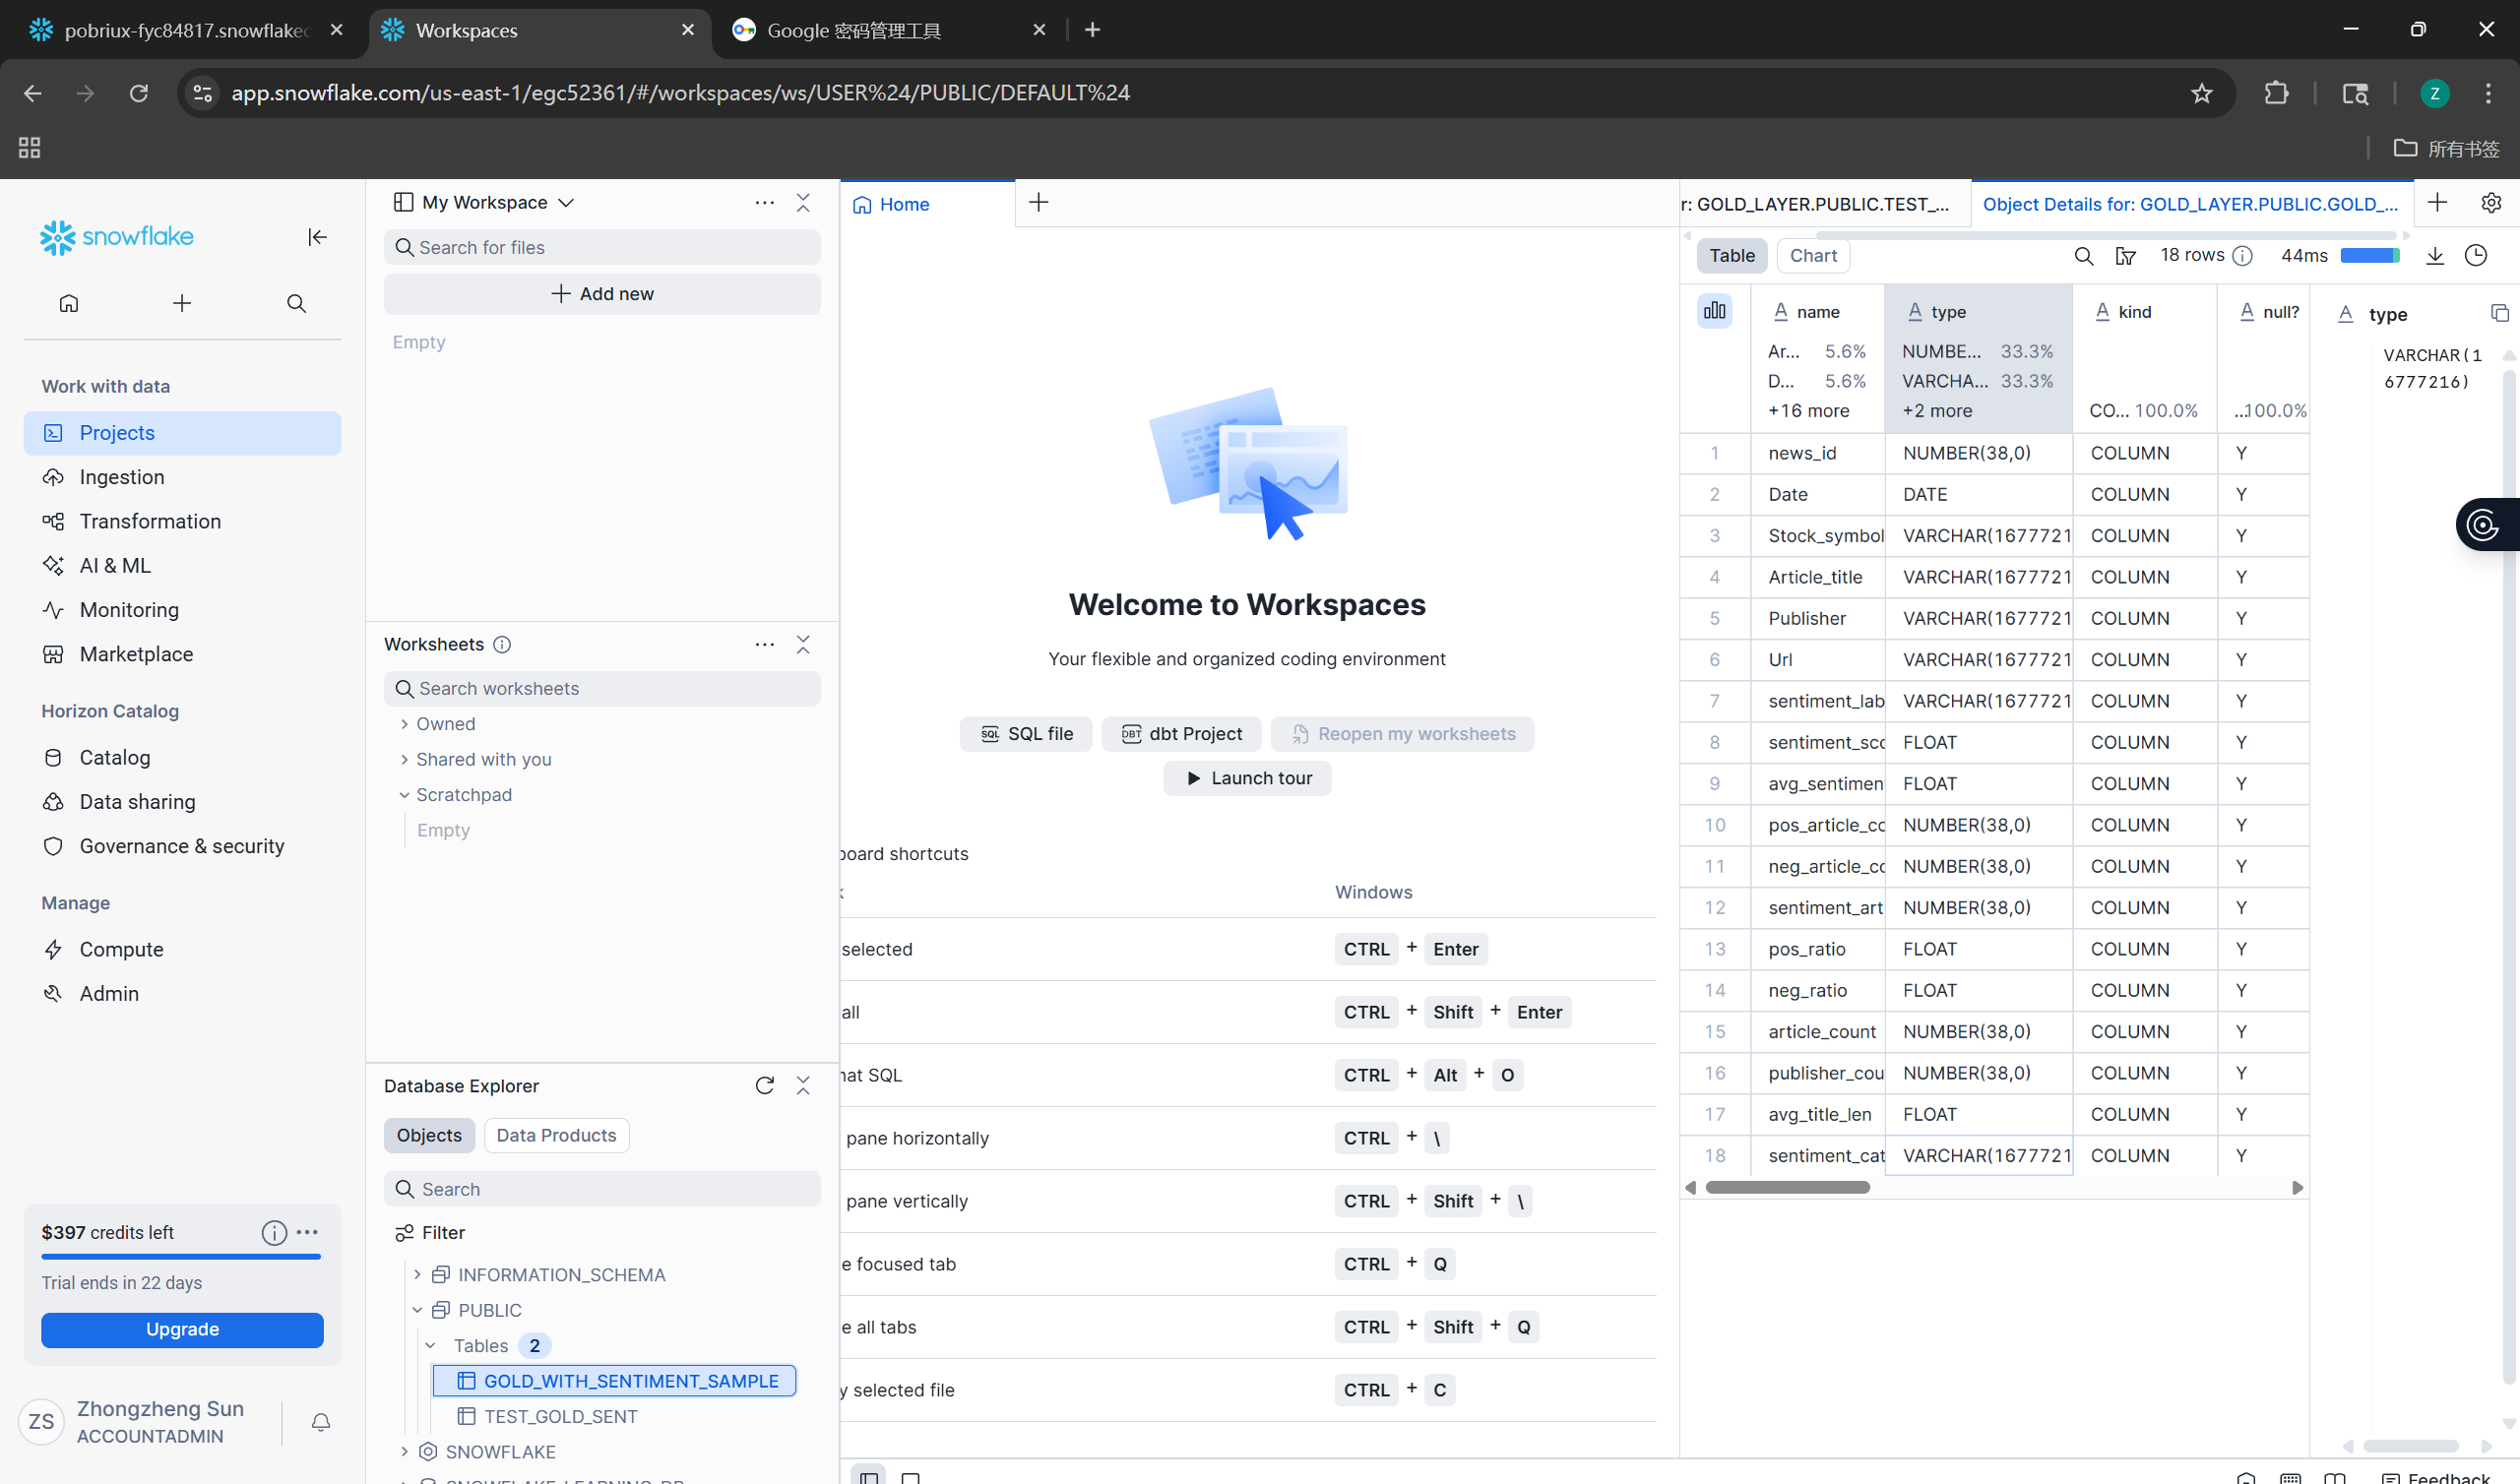

In [1]:
# example of one parquet in my local file
import pandas as pd
from snowflake.snowpark.session import Session
import os

# 1. Snowflake Connection
connection_parameters = {
    "account": "POBRIUX-FYC84817",
    "user": "AKAAAAFK",
    "password": "Sunzhongzheng0920!",
    "role": "ACCOUNTADMIN",
    "warehouse": "COMPUTE_WH",
    "database": "GOLD_LAYER",
    "schema": "PUBLIC",
}

session = Session.builder.configs(connection_parameters).create()

# 2. Only load ONE Parquet file

PARQUET_FILE = r"D:\Columbia\Fall2025\5400\project\layer\gold_with_sentiment_sample\part-00095-9d658231-dead-4f2d-a34c-8f6467fe5a53-c000.snappy.parquet"

TARGET_TABLE = "GOLD_WITH_SENTIMENT_SAMPLE"

print("📥 Loading Parquet file:", PARQUET_FILE)
df = pd.read_parquet(PARQUET_FILE)
print(f"📊 Loaded {len(df):,} rows")

# 3. Upload to Snowflake
print("❄ Uploading to Snowflake table:", TARGET_TABLE)
session.write_pandas(
    df,
    table_name=TARGET_TABLE,
    auto_create_table=True,
    overwrite=False
)

print("🎉 SUCCESS! Uploaded to Snowflake:", TARGET_TABLE)

session.close()


C:\Users\GUTS\AppData\Local\Temp\ipykernel_7000\1416219405.py:3: DeprecationWarning: Python Runtime 3.9 reached its End-Of-Life (EOL) in October 2025, there will be no further bug fixes or security updates for this runtime. We recommend that you upgrade your existing Python 3.9 objects to Python 3.10, 3.11, 3.12 or 3.13. Please note that end of support does not impact execution, and you will still be able to update and invoke existing objects. However, they will be running on an unsupported runtime which will no longer be maintained or patched by the Snowflake team. For more details, please refer to https://docs.snowflake.com/en/developer-guide/python-runtime-support-policy.
  from snowflake.snowpark.session import Session
D:\Code\ANACONDA3\envs\pyspark1\lib\site-packages\boto3\compat.py:89: PythonDeprecationWarning: Boto3 will no longer support Python 3.9 starting April 29, 2026. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.10 or la

📥 Loading Parquet file: D:\Columbia\Fall2025\5400\project\layer\gold_with_sentiment_sample\part-00095-9d658231-dead-4f2d-a34c-8f6467fe5a53-c000.snappy.parquet
📊 Loaded 34,333 rows
❄ Uploading to Snowflake table: GOLD_WITH_SENTIMENT_SAMPLE
🎉 SUCCESS! Uploaded to Snowflake: GOLD_WITH_SENTIMENT_SAMPLE


### full data into snowflake (not running fully because of credit limit)

In [1]:
# full data into snowflake (not run because of credit limit)
# example of one parquet in my local file
import pandas as pd
from snowflake.snowpark.session import Session
import os

# 1. Snowflake Connection
connection_parameters = {
    "account": "POBRIUX-FYC84817",
    "user": "AKAAAAFK",
    "password": "Sunzhongzheng0920!",
    "role": "ACCOUNTADMIN",
    "warehouse": "COMPUTE_WH",
    "database": "GOLD_LAYER",
    "schema": "PUBLIC",
}

session = Session.builder.configs(connection_parameters).create()

# 2. Only load ONE Parquet file

PARQUET_FILE = r"D:\Columbia\Fall2025\5400\project\layer\gold_with_sentiment_sample"

TARGET_TABLE = "GOLD_WITH_SENTIMENT_SAMPLE"

print("📥 Loading Parquet file:", PARQUET_FILE)
df = pd.read_parquet(PARQUET_FILE)
print(f"📊 Loaded {len(df):,} rows")

# 3. Upload to Snowflake
print("❄ Uploading to Snowflake table:", TARGET_TABLE)
session.write_pandas(
    df,
    table_name=TARGET_TABLE,
    auto_create_table=True,
    overwrite=False
)

print("🎉 SUCCESS! Uploaded to Snowflake:", TARGET_TABLE)

session.close()

C:\Users\GUTS\AppData\Local\Temp\ipykernel_37100\3314338924.py:4: DeprecationWarning: Python Runtime 3.9 reached its End-Of-Life (EOL) in October 2025, there will be no further bug fixes or security updates for this runtime. We recommend that you upgrade your existing Python 3.9 objects to Python 3.10, 3.11, 3.12 or 3.13. Please note that end of support does not impact execution, and you will still be able to update and invoke existing objects. However, they will be running on an unsupported runtime which will no longer be maintained or patched by the Snowflake team. For more details, please refer to https://docs.snowflake.com/en/developer-guide/python-runtime-support-policy.
  from snowflake.snowpark import Session
D:\Columbia\Fall2025\5400\SQL.venv\lib\site-packages\boto3\compat.py:89: PythonDeprecationWarning: Boto3 will no longer support Python 3.9 starting April 29, 2026. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.10 or later.

📥 Loading Parquet file: D:\Columbia\Fall2025\5400\project\layer\gold_with_sentiment_sample
📊 Loaded 3,242,351 rows
❄ Uploading to Snowflake table: GOLD_WITH_SENTIMENT_SAMPLE


KeyboardInterrupt: 

### Appendix (Frontend)
#### 1.Intro
I stored the final data as CSV is because I want to see the data whenever I can, but the formal ELT is using parquet, so I made two versions of streamlit, one is loading parquet, one is loading CSV. I just need to change a file path. As for parquet, I need to combine all the parquets I made from batches above and then load into streamlit. So as for the Flask.

Please run the streamlit and flask in terminal, i will screenshot the outcome in the beginning of each session

By the way, parquet is way faster than csv!

In [10]:
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow.dataset as ds

GOLD_WITH_SENT_SAMPLE = r"D:\Columbia\Fall2025\5400\project\layer\gold_with_sentiment_sample"
OUTPUT_CSV = r"D:\Columbia\Fall2025\5400\project\gold_with_sentiment_sample.csv"

dataset = ds.dataset(GOLD_WITH_SENT_SAMPLE, format="parquet")
table = dataset.to_table()
df = table.to_pandas()

df.to_csv(OUTPUT_CSV, index=False)
print("CSV out：", OUTPUT_CSV)

CSV out： D:\Columbia\Fall2025\5400\project\gold_with_sentiment_sample.csv


#### 2. Streamlit
##### (1) parquet version
cd D:\Columbia\Fall2025\5400\project -> streamlit run backend.py

Terminal:

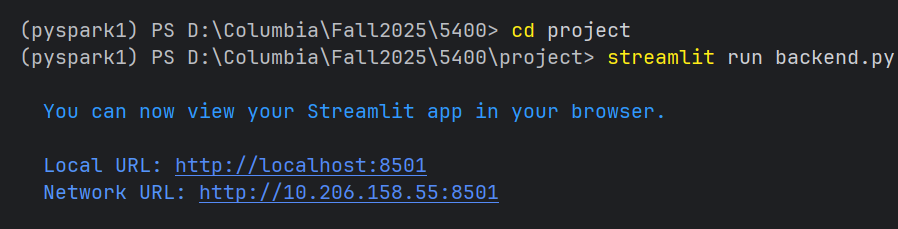

UI:

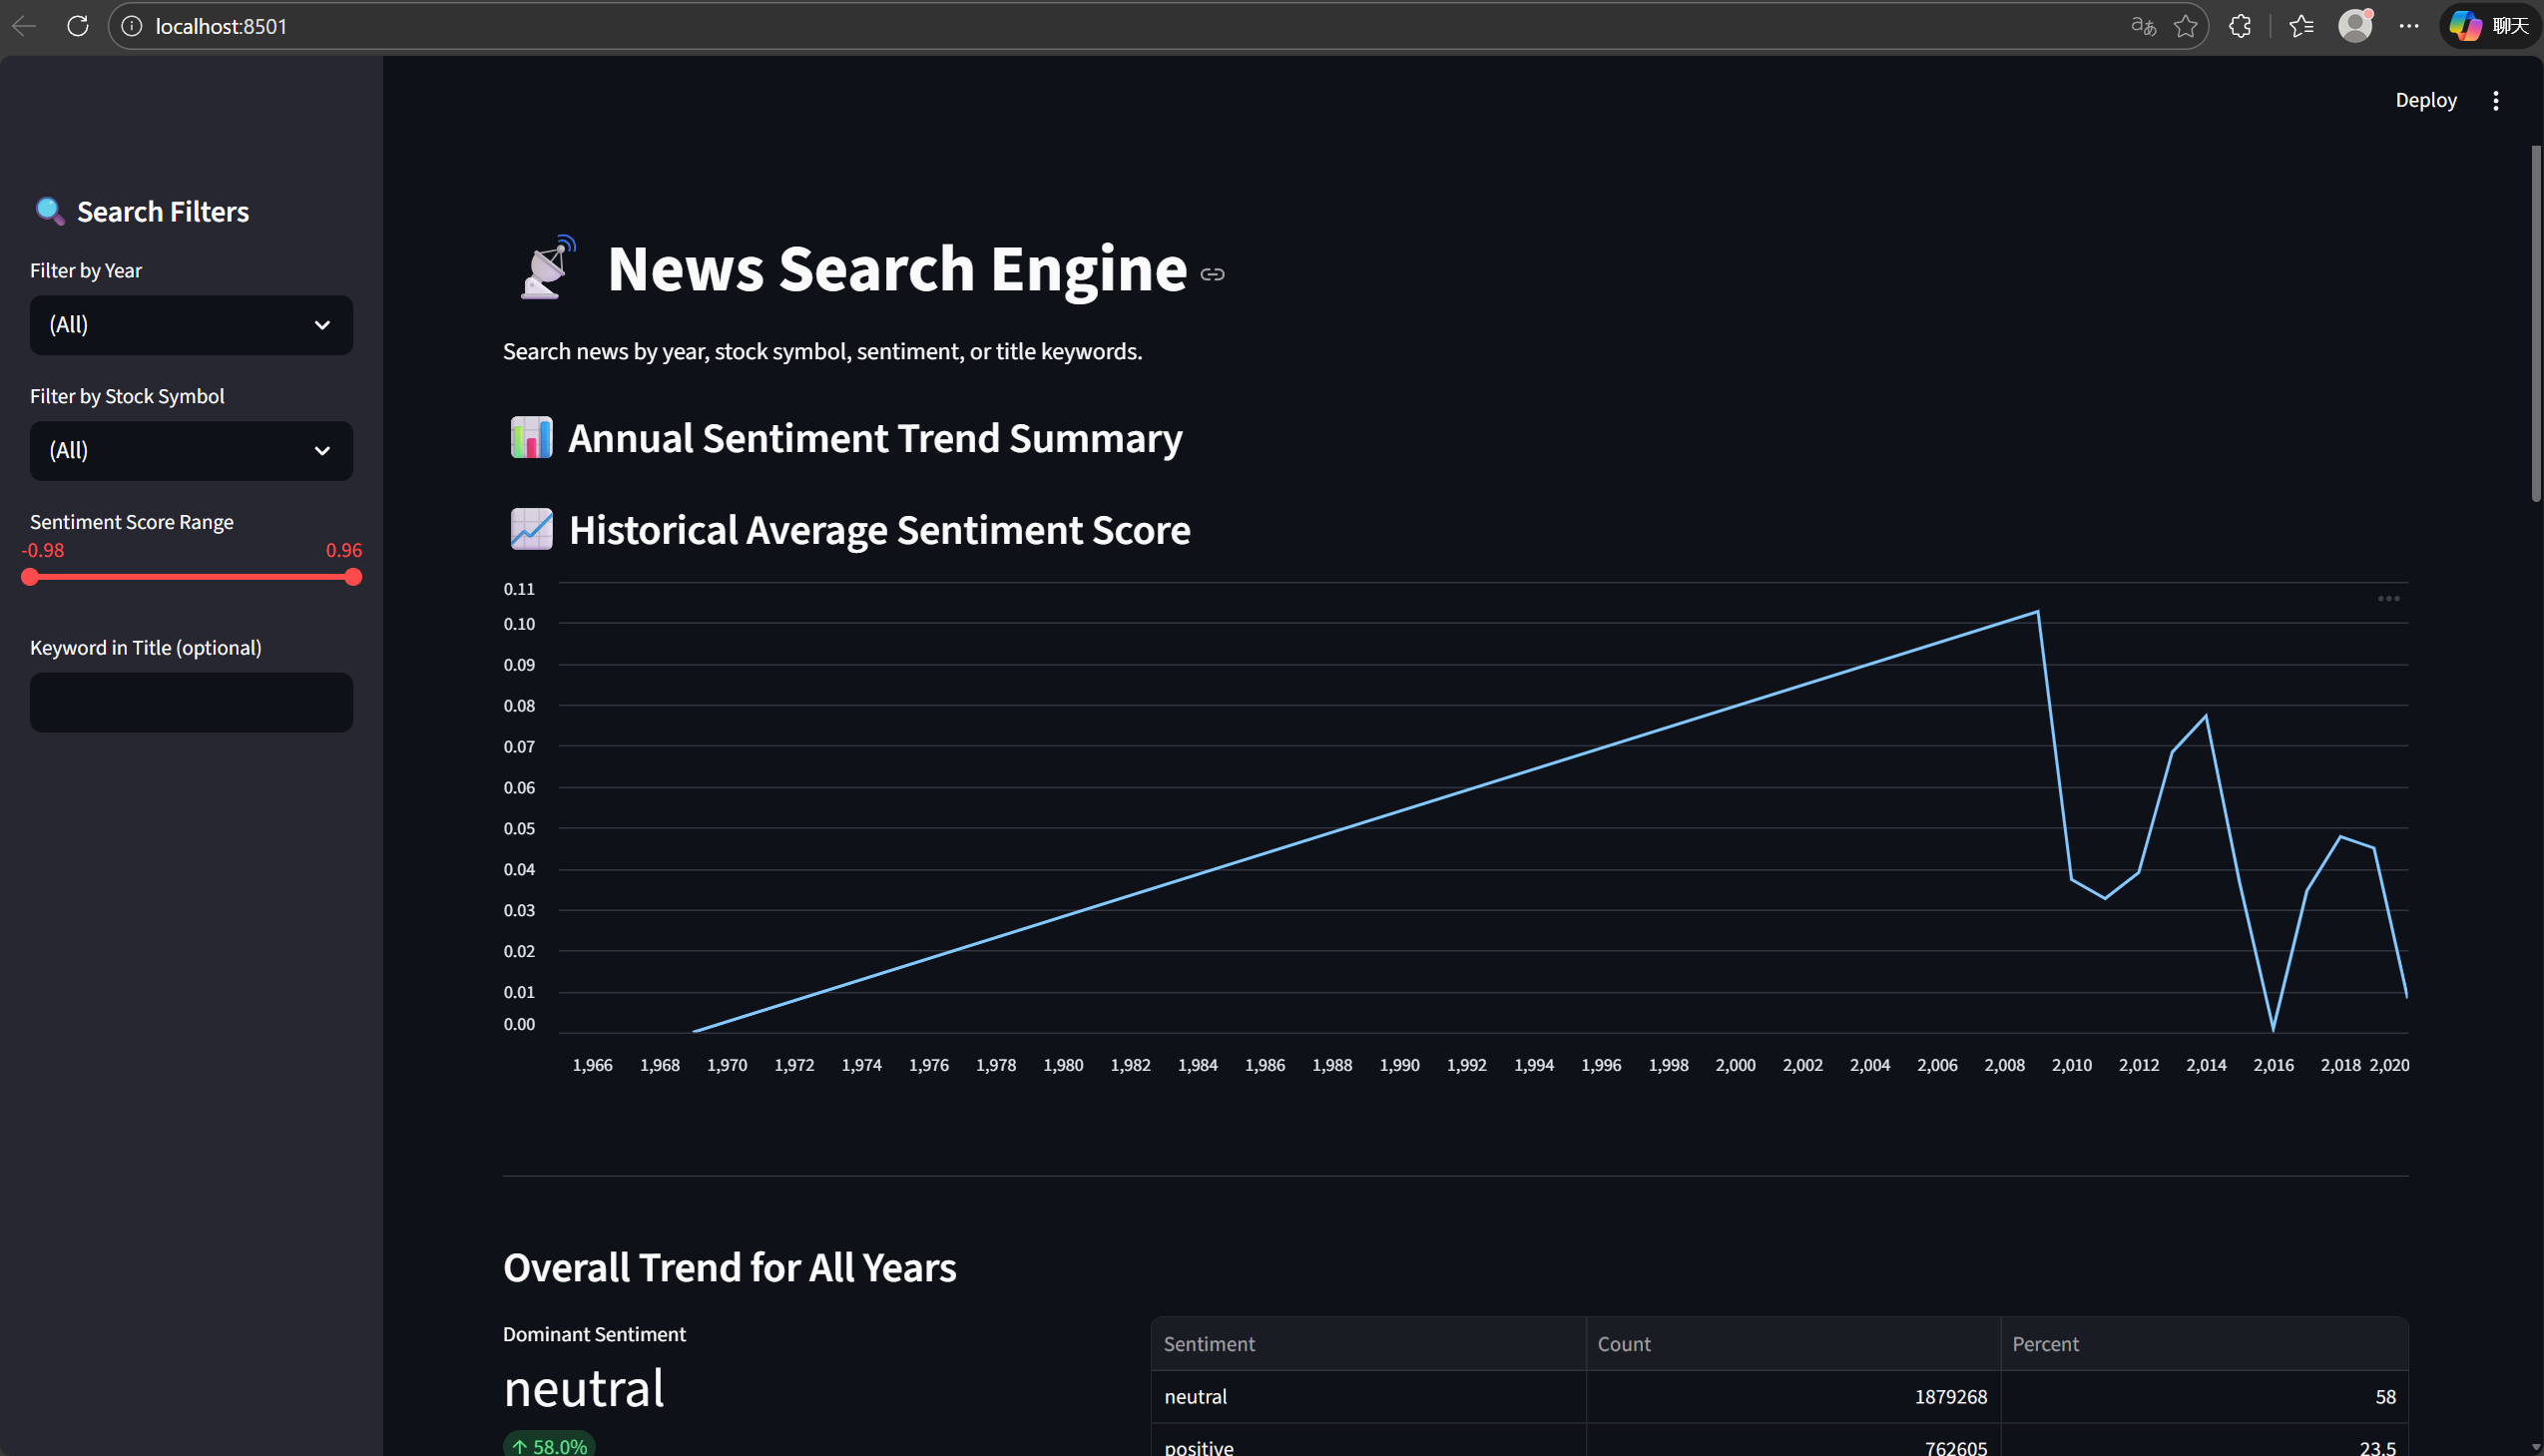

In [ ]:
import streamlit as st
import pandas as pd
import pyarrow.dataset as ds
import os

# Streamlit App Config
st.set_page_config(page_title="News Search Engine", layout="wide")

st.title("📡 News Search Engine")
st.write("Search news by year, stock symbol, sentiment, or title keywords.")

DATA_PATH = r"D:\Columbia\Fall2025\5400\project\layer\gold_with_sentiment_sample"   # Folder containing many parquet files

# 1) Load Multiple Parquet Files (PyArrow)
@st.cache_data
def load_data(path):
    """Load many parquet files efficiently using PyArrow Dataset."""

    if not os.path.exists(path):
        st.error(f"❌ Path not found: {path}")
        st.stop()

    try:
        # If it's a folder → load all parquet inside it
        if os.path.isdir(path):
            dataset = ds.dataset(path, format="parquet")
            df = dataset.to_table().to_pandas()
        else:
            # Single parquet file
            df = pd.read_parquet(path)
    except Exception as e:
        st.error(f"❌ Failed to load parquet files: {e}")
        st.stop()

    # Extract Year column
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df["Year"] = df["Date"].dt.year.astype("Int64")

    return df


# Load dataset
df = load_data(DATA_PATH)

# 2) Sidebar Filters
st.sidebar.header("🔍 Search Filters")

# Year
if "Year" in df.columns:
    years = sorted(df["Year"].dropna().unique().tolist(), reverse=True)
    selected_year = st.sidebar.selectbox("Filter by Year", ["(All)"] + years)
else:
    selected_year = "(All)"

# Stock symbol
if "Stock_symbol" in df.columns:
    symbols = ["(All)"] + sorted(df["Stock_symbol"].dropna().unique().tolist())
    symbol = st.sidebar.selectbox("Filter by Stock Symbol", symbols)
else:
    symbol = "(All)"

# Sentiment range
if "sentiment_score_signed" in df.columns:
    min_score = float(df["sentiment_score_signed"].min())
    max_score = float(df["sentiment_score_signed"].max())
    sentiment_range = st.sidebar.slider(
        "Sentiment Score Range", min_score, max_score, (min_score, max_score)
    )
else:
    sentiment_range = None

# Keyword
keyword = st.sidebar.text_input("Keyword in Title (optional)")

# 3) Apply Filters
filtered = df.copy()

if selected_year != "(All)":
    filtered = filtered[filtered["Year"] == selected_year]

if symbol != "(All)":
    filtered = filtered[filtered["Stock_symbol"] == symbol]

if sentiment_range:
    filtered = filtered[
        (filtered["sentiment_score_signed"] >= sentiment_range[0]) &
        (filtered["sentiment_score_signed"] <= sentiment_range[1])
    ]

if keyword:
    filtered = filtered[
        filtered["Article_title"].str.contains(keyword, case=False, na=False)
    ]

# 4) Annual Sentiment Trend
st.subheader("📊 Annual Sentiment Trend Summary")

if "Year" in df.columns:
    trend = df.groupby("Year")["sentiment_score_signed"].mean()
    st.markdown("### 📈 Historical Average Sentiment Score")
    st.line_chart(trend)

st.markdown("---")

# 5) Summary for Selected Year
if selected_year != "(All)":
    year_df = df[df["Year"] == selected_year]
    title = f"Overall Sentiment Trend for **{selected_year}**"
else:
    year_df = df
    title = f"Overall Trend for **All Years**"

st.markdown(f"### {title}")

if "sentiment_label" in year_df.columns and len(year_df) > 0:
    counts = year_df["sentiment_label"].value_counts()
    total = counts.sum()

    col1, col2 = st.columns([1, 2])

    with col1:
        top_label = counts.index[0]
        pct = (counts.iloc[0] / total) * 100
        st.metric("Dominant Sentiment", top_label, f"{pct:.1f}%")

    with col2:
        summary_table = pd.DataFrame({
            "Sentiment": counts.index,
            "Count": counts.values,
            "Percent": (counts.values / total * 100).round(1),
        })
        st.dataframe(summary_table, hide_index=True)

st.markdown("---")

# 6) Search Results Table
st.subheader(f"🔎 Search Results ({filtered.shape[0]} rows)")

if "Date" in filtered.columns and pd.api.types.is_datetime64_any_dtype(filtered["Date"]):
    filtered = filtered.sort_values("Date", ascending=False)

cols = [
    "Year", "Date", "Stock_symbol", "news_id", "Article_title",
    "sentiment_label", "sentiment_score_signed", "avg_sentiment_score",
    "pos_ratio", "neg_ratio", "article_count", "publisher_count",
    "avg_title_len", "sentiment_category",
]
cols = [c for c in cols if c in filtered.columns]

st.data_editor(filtered[cols].head(200), use_container_width=True, hide_index=True)

st.markdown("---")

# 7) Article Detail Viewer
st.subheader("📰 View News Detail")

if filtered.shape[0] == 0:
    st.warning("No results. Adjust filters.")
else:
    selected_id = st.selectbox("Select news_id", filtered["news_id"].unique())
    row = filtered[filtered["news_id"] == selected_id].iloc[0]

    st.markdown("## 📝 Title")
    st.markdown(f"### {row['Article_title']}")

    st.markdown("---")
    st.markdown("## 🧠 Sentiment Metrics")

    metrics = [
        "sentiment_label", "sentiment_score_signed", "avg_sentiment_score",
        "pos_ratio", "neg_ratio", "sentiment_category",
    ]
    for m in metrics:
        if m in row:
            st.write(f"**{m}:** {row[m]}")

    st.markdown("---")
    st.markdown("## 📌 Metadata")

    meta = [
        "Year", "Date", "Stock_symbol", "Publisher", "Url",
        "sample_news_id", "article_count", "publisher_count", "avg_title_len",
    ]
    for m in meta:
        if m in row:
            st.write(f"**{m}:** {row[m]}")

##### (2) Streamlit(CSV version)
cd D:\Columbia\Fall2025\5400\project -> streamlit run backnew.py

Terminal:

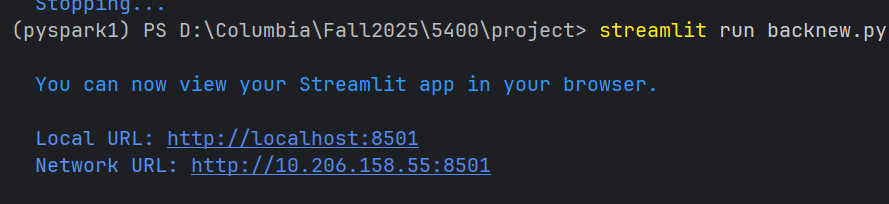

UI:

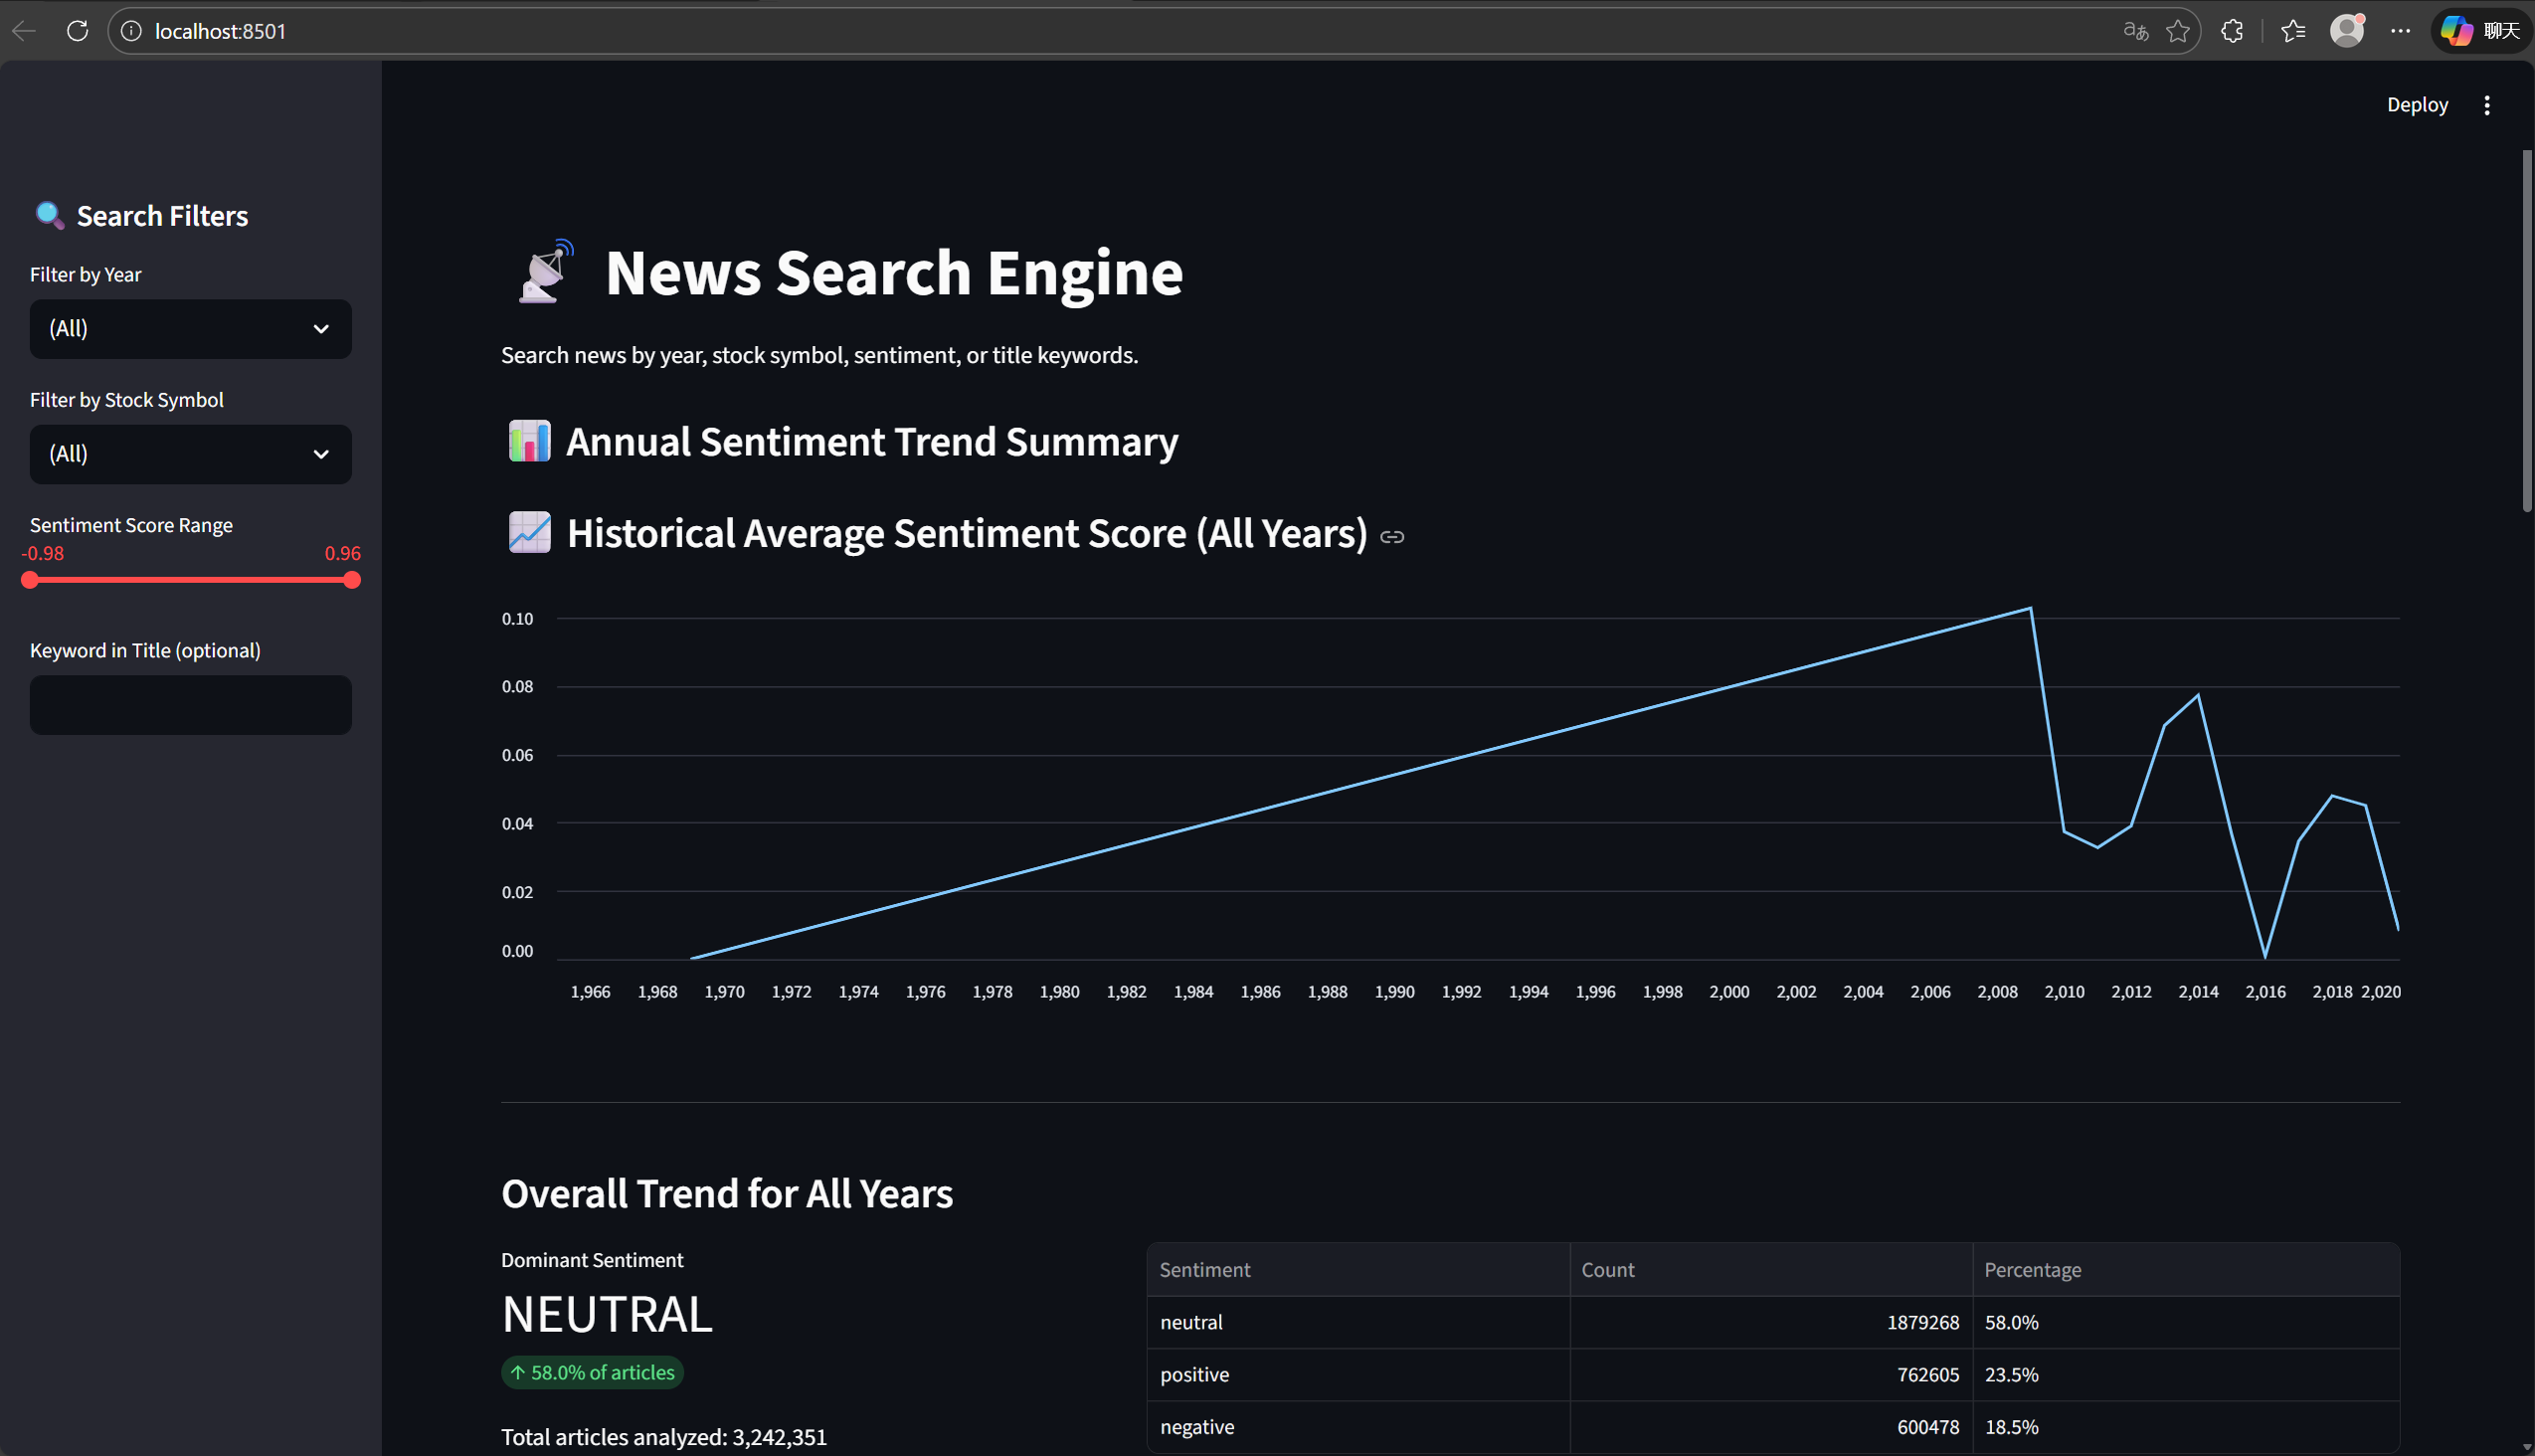
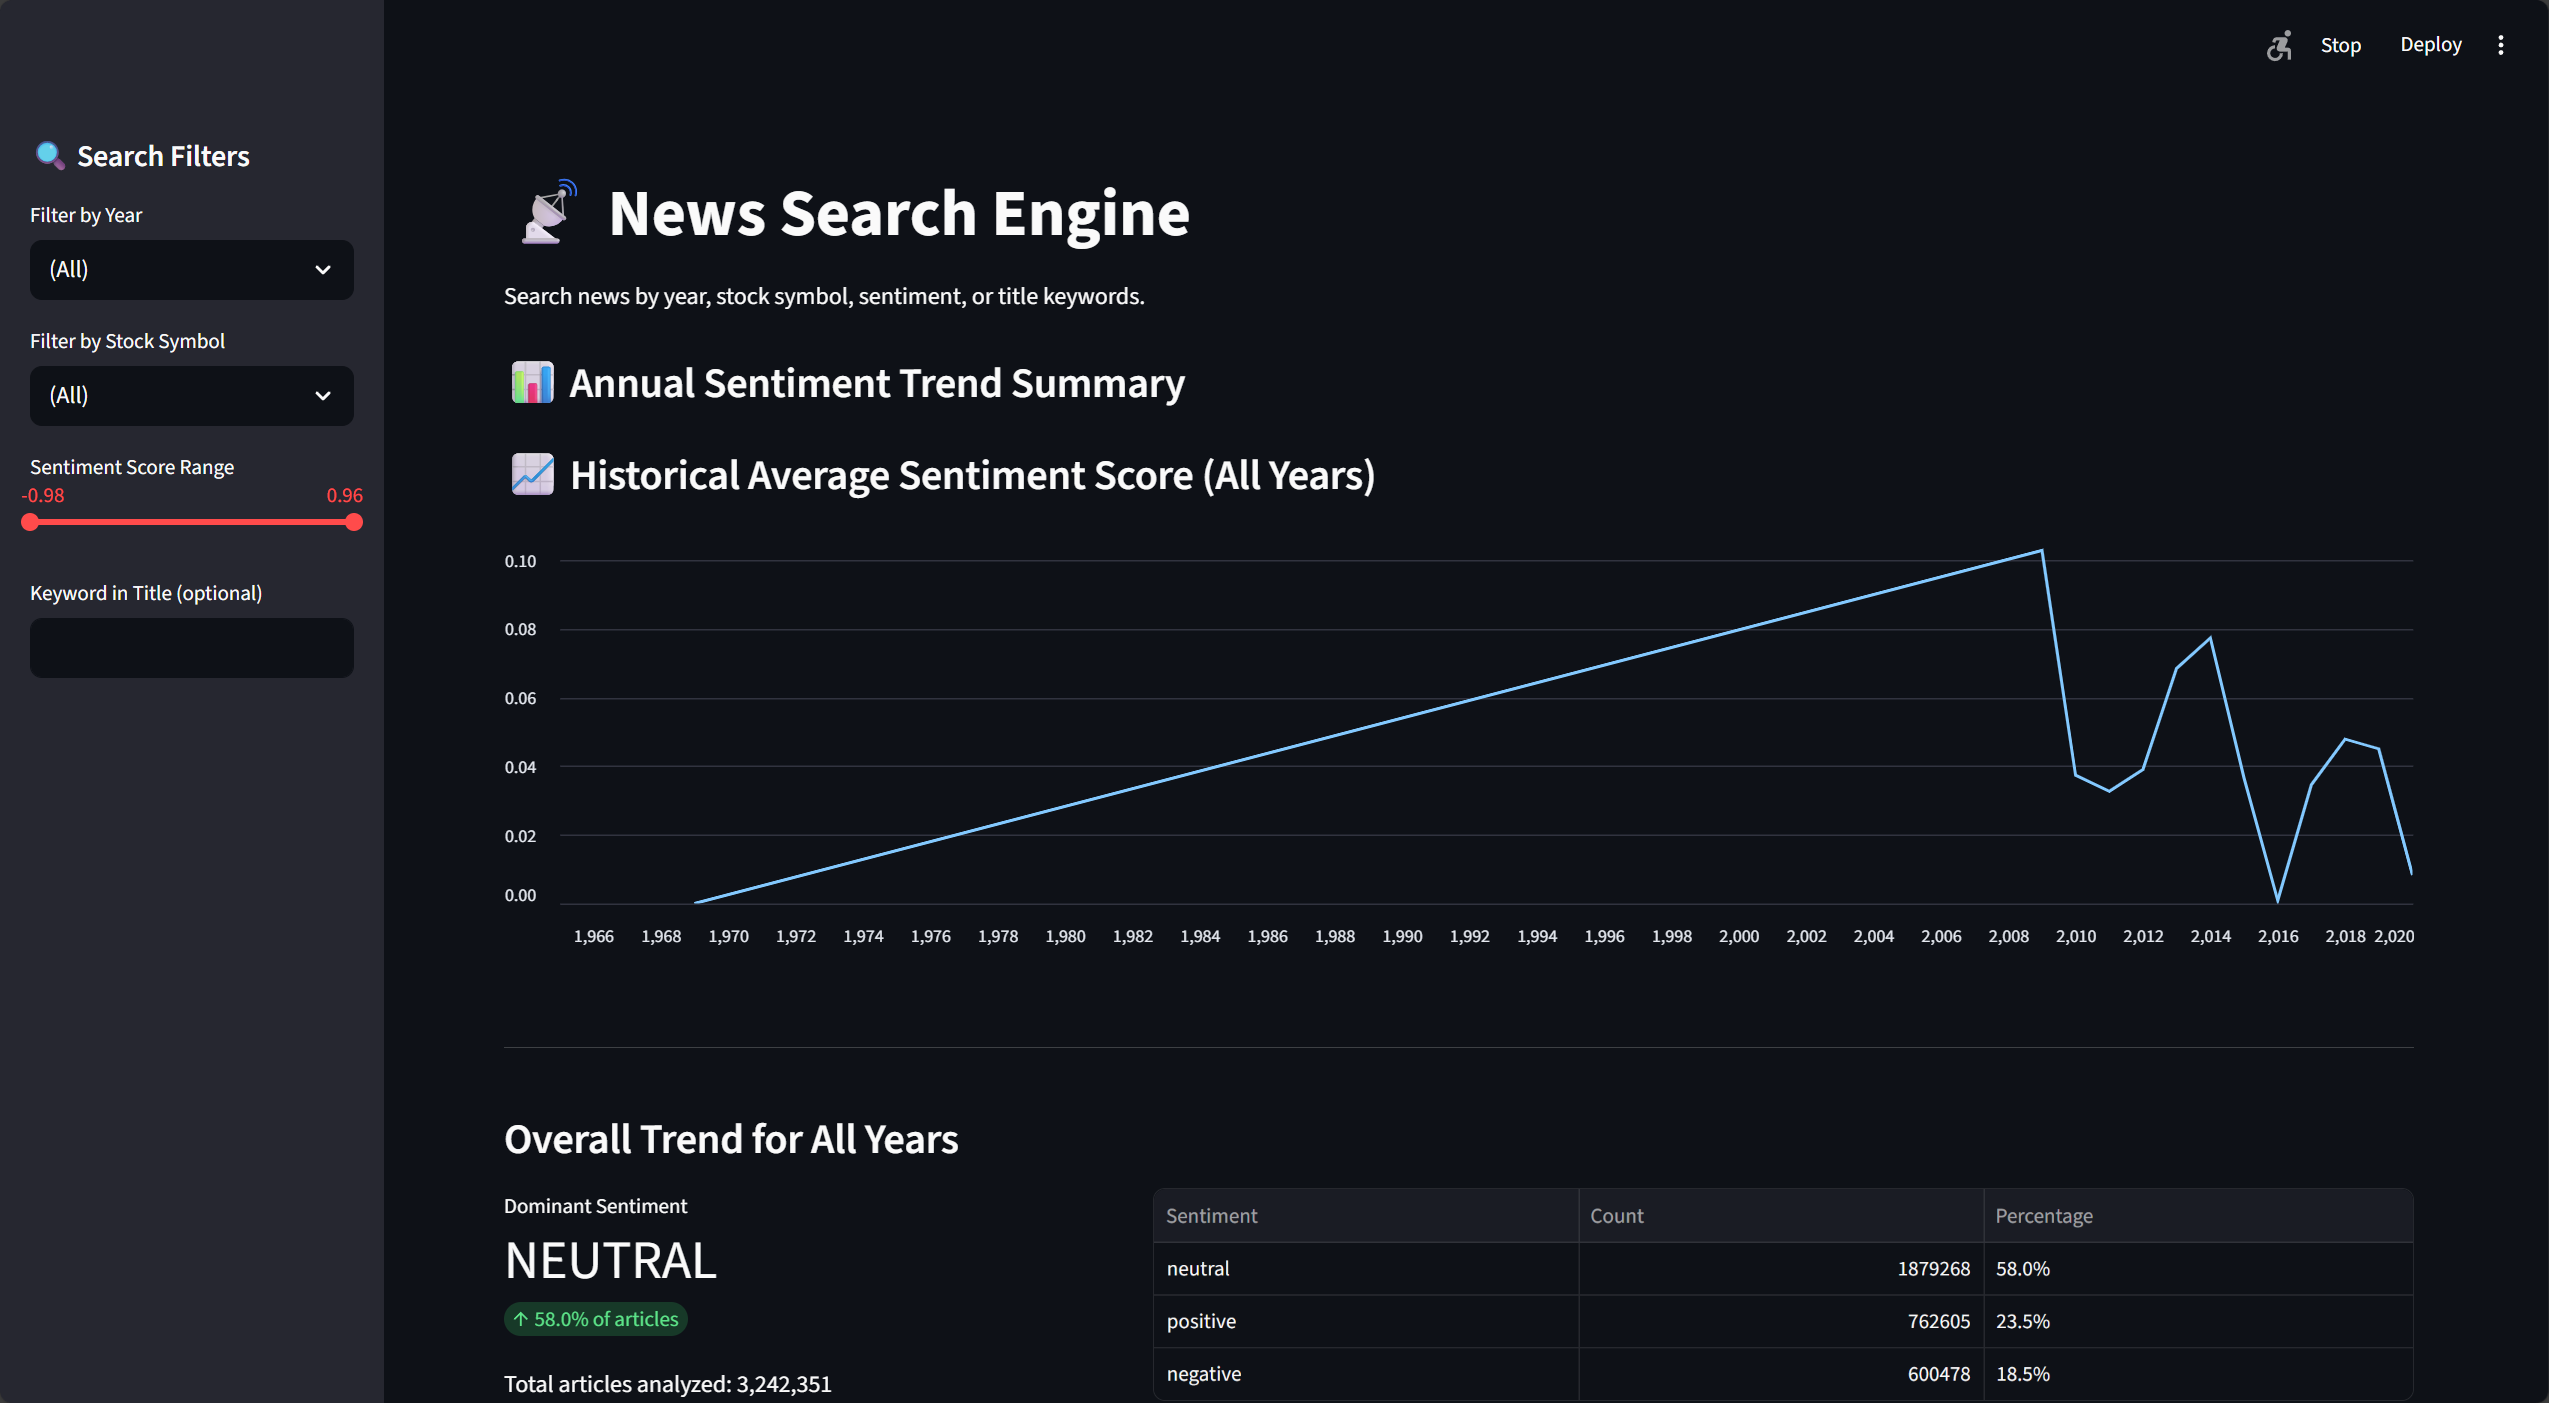

In [ ]:
import streamlit as st
import pandas as pd
import os

# Streamlit Config
st.set_page_config(page_title="News Search Engine", layout="wide")

st.title("📡 News Search Engine")
st.write("Search news by year, stock symbol, sentiment, or title keywords.")

# 1) Load CSV Automatically (Optimized with Caching)
# --- Configuration for Data Source ---
DEFAULT_FILENAME = "gold_with_sentiment_sample.csv"


# Use st.cache_data decorator to ensure data loading and processing run only once.
@st.cache_data
def load_data(filename):
    """Loads data from local CSV file and performs initial preprocessing."""

    df = None

    # --- 1. Load data from local CSV ---
    if os.path.exists(filename):
        try:
            df = pd.read_csv(filename)
        except Exception as csv_e:
            st.error(f"❌ Failed to read local CSV file: {csv_e}")
    else:
        st.error(f"❌ Local CSV file not found: '{filename}'")

    if df is None or df.empty:
        st.error("❌ Failed to load data. Please check local file path.")
        st.stop()

    # --- 2. Data Preprocessing: Extract Year (applies to all sources) ---
    if "Date" in df.columns:
        try:
            # Convert 'Date' to datetime objects
            df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
            # Extract the year, using 'Int64' to handle potential NaNs gracefully
            df["Year"] = df["Date"].dt.year.astype('Int64')
        except Exception as e:
            # Displaying an error if date processing fails within the cached function
            st.error(f"Error processing 'Date' column within cache: {e}. Please check the date format.")
            pass

    return df


# Load the data using the cached function
df = load_data(DEFAULT_FILENAME)

# 2) Sidebar Filters

st.sidebar.header("🔍 Search Filters")

# ---- Year Filter (Updated) ----
if "Year" in df.columns:
    # Get unique years and sort them in descending order
    all_years = sorted(df["Year"].dropna().unique().tolist(), reverse=True)
    selected_year = st.sidebar.selectbox(
        "Filter by Year",
        ["(All)"] + all_years
    )
else:
    selected_year = "(All)"

# ---- Stock Symbol Filter ----
if "Stock_symbol" in df.columns:
    symbols = ["(All)"] + sorted(df["Stock_symbol"].dropna().unique().tolist())
    symbol = st.sidebar.selectbox("Filter by Stock Symbol", symbols)
else:
    symbol = "(All)"

# ---- Sentiment Range Filter ----
if "sentiment_score_signed" in df.columns:
    min_score = float(df["sentiment_score_signed"].min())
    max_score = float(df["sentiment_score_signed"].max())

    # Ensure range works even if min/max are the same
    if min_score == max_score:
        sentiment_range = (min_score, max_score)
        st.sidebar.write(f"Sentiment Score Range: [{min_score:.2f}, {max_score:.2f}] (All values are the same)")
    else:
        sentiment_range = st.sidebar.slider(
            "Sentiment Score Range",
            min_score,
            max_score,
            (min_score, max_score)
        )
else:
    sentiment_range = None

# ---- Keyword Filter ----
keyword = st.sidebar.text_input("Keyword in Title (optional)")

# 3) Apply Filters
# The filtering operation itself is still run on every interaction, but now
# it works on the cached DataFrame, which is much faster than re-reading the CSV.
filtered = df.copy()

# Apply Year Filter (if selected)
if selected_year != "(All)" and "Year" in filtered.columns:
    filtered = filtered[filtered["Year"] == selected_year]

# Apply Stock Symbol Filter
if symbol != "(All)":
    filtered = filtered[filtered["Stock_symbol"] == symbol]

# Apply Sentiment Range Filter
if sentiment_range:
    filtered = filtered[
        (filtered["sentiment_score_signed"] >= sentiment_range[0]) &
        (filtered["sentiment_score_signed"] <= sentiment_range[1])
        ]

# Apply Keyword Filter
if keyword and "Article_title" in filtered.columns:
    filtered = filtered[
        filtered["Article_title"].str.contains(keyword, case=False, na=False)
    ]

# 4) Annual Trend Summary (NEW SECTION)
st.subheader("📊 Annual Sentiment Trend Summary")

# --- 4.1) Annual Sentiment Trend Chart (across all years) ---
if "Year" in df.columns and "sentiment_score_signed" in df.columns:
    st.markdown("### 📈 Historical Average Sentiment Score (All Years)")

    # Calculate average sentiment score per year from the full dataset (df)
    annual_trend = df.groupby("Year")["sentiment_score_signed"].mean().reset_index()
    annual_trend.rename(columns={"sentiment_score_signed": "Average Sentiment Score"}, inplace=True)

    # Set Year as index for better line chart display
    annual_trend.set_index("Year", inplace=True)

    st.line_chart(annual_trend, height=300)
    st.markdown("---")

# To provide an 'overall' trend for the selected year, we base the summary on the
# data filtered ONLY by the year, ignoring stock/score/keyword filters.
yearly_summary_df = df.copy()
if selected_year != "(All)" and "Year" in yearly_summary_df.columns:
    yearly_summary_df = yearly_summary_df[yearly_summary_df["Year"] == selected_year]
    summary_title = f"Overall Trend for **{selected_year}**"
elif selected_year == "(All)":
    summary_title = "Overall Trend for **All Years**"
else:
    summary_title = "Overall Trend"

st.markdown(f"### {summary_title}")

if "sentiment_label" in yearly_summary_df.columns:
    sentiment_counts = yearly_summary_df["sentiment_label"].value_counts().sort_values(ascending=False)
    total_articles = sentiment_counts.sum()

    if total_articles > 0:
        col1, col2 = st.columns([1, 2])

        # Col 1: Dominant Trend Highlight
        with col1:
            most_common_sentiment = sentiment_counts.index[0]
            most_common_count = sentiment_counts.iloc[0]
            most_common_percentage = (most_common_count / total_articles) * 100

            st.metric(
                label="Dominant Sentiment",
                value=most_common_sentiment.upper(),
                delta=f"{most_common_percentage:.1f}% of articles"
            )
            st.write(f"Total articles analyzed: {total_articles:,}")

        # Col 2: Detailed Breakdown
        with col2:
            summary_table = pd.DataFrame({
                "Sentiment": sentiment_counts.index,
                "Count": sentiment_counts.values,
                "Percentage": [f"{v / total_articles * 100:.1f}%" for v in sentiment_counts.values]
            })
            st.dataframe(summary_table, hide_index=True)

    else:
        st.warning("No data available to generate the annual summary.")
else:
    st.error("Cannot generate summary: 'sentiment_label' column is missing in the dataset.")

st.markdown("---")

# 5) Display Filtered Results
st.subheader(f"🔎 Search Results ({filtered.shape[0]} rows)")

# Sort by Date (Descending) to show newest articles first
if "Date" in filtered.columns:
    # Check if 'Date' is datetime type (should be due to load_data preprocessing)
    if pd.api.types.is_datetime64_any_dtype(filtered["Date"]):
        filtered = filtered.sort_values(by="Date", ascending=False)
    else:
        st.warning("Date column is not in datetime format for sorting.")

# show a subset of columns in table
cols_to_show = [
    col for col in [
        "Year",  # Added Year column
        "Date",
        "Stock_symbol",
        "news_id",
        "Article_title",
        "sentiment_label",
        "sentiment_score_signed",
        "avg_sentiment_score",
        "pos_ratio",
        "neg_ratio",
        "article_count",
        "publisher_count",
        "avg_title_len",
        "sentiment_category",
    ] if col in filtered.columns
]
# Use st.data_editor for better interactivity (sorting, searching)
st.data_editor(
    filtered[cols_to_show].head(200),
    use_container_width=True,
    hide_index=True
)

# 6) Select Article
st.markdown("---")
st.subheader("📰 View News Detail")

if filtered.shape[0] == 0:
    st.warning("No results. Please adjust the search filters!")
    # NOTE: Do not use st.stop() here as it stops the entire script, not just the section.
else:
    selected_id = st.selectbox("Select news_id", filtered["news_id"].unique())
    row = filtered[filtered["news_id"] == selected_id].iloc[0]

    # 7) Display Title & Basic Info
    st.markdown("## 📝 Title")

    if "Article_title" in df.columns:
        st.markdown(f"### {row['Article_title']}")
    else:
        st.write("No title column in this dataset.")

    st.markdown("---")
    st.markdown("## 🧠 Sentiment Metrics")

    if "sentiment_label" in df.columns:
        st.write(f"**Sentiment label:** {row['sentiment_label']}")
    if "sentiment_score_signed" in df.columns:
        st.write(f"**Signed sentiment score:** {row['sentiment_score_signed']}")
    if "avg_sentiment_score" in df.columns:
        st.write(f"**Avg sentiment (Date, Stock):** {row['avg_sentiment_score']}")
    if "pos_ratio" in df.columns and "neg_ratio" in df.columns:
        st.write(f"**Positive ratio:** {row['pos_ratio']}")
        st.write(f"**Negative ratio:** {row['neg_ratio']}")
    if "sentiment_category" in df.columns:
        st.write(f"**Sentiment category:** {row['sentiment_category']}")

    # 8) Metadata Section
    st.markdown("---")
    st.markdown("## 📌 Metadata")

    metadata_fields = [
        "Year",  # Added Year
        "Date",
        "Stock_symbol",
        "sample_news_id",
        "Publisher",
        "Url",
        "article_count",
        "publisher_count",
        "avg_title_len",
    ]

    for col in metadata_fields:
        if col in df.columns:
            st.write(f"**{col}:** {row[col]}")

#### 3. Flask
As for the flask, there are much to modify, the filters are totally different than csv

Also, the parquet are super faster than csv!!!

File structure:

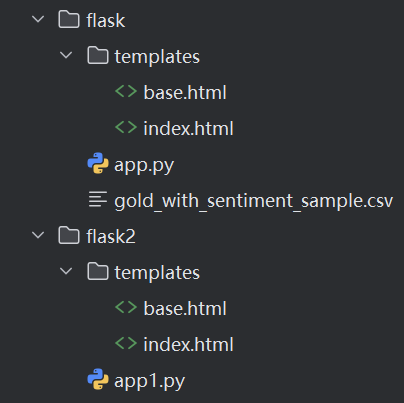

##### (1) Flask(Parquet)
cd D:\Columbia\Fall2025\5400\project\flask2 -> python app1.py in terminal

Terminal：

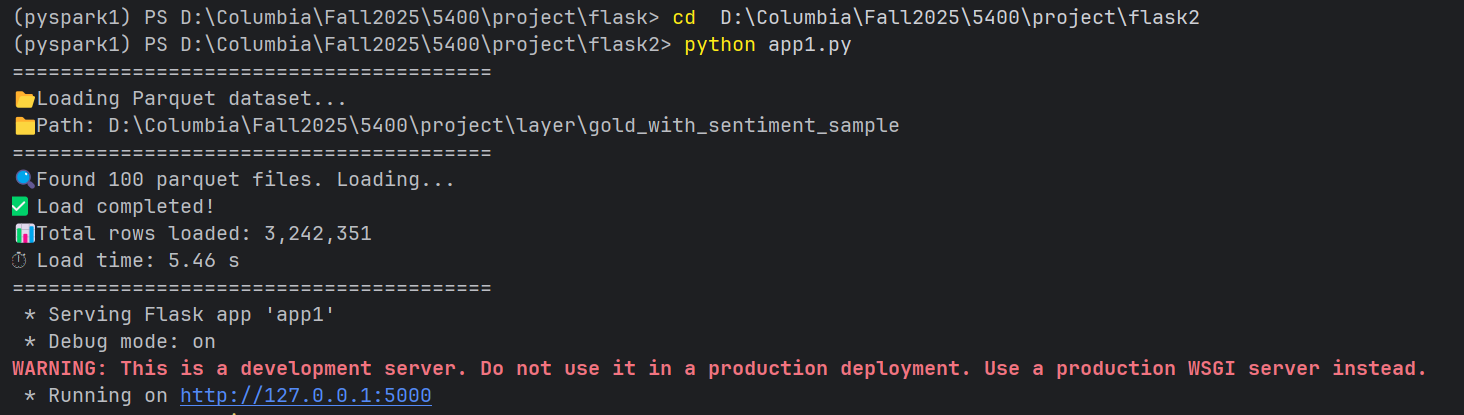

UI:

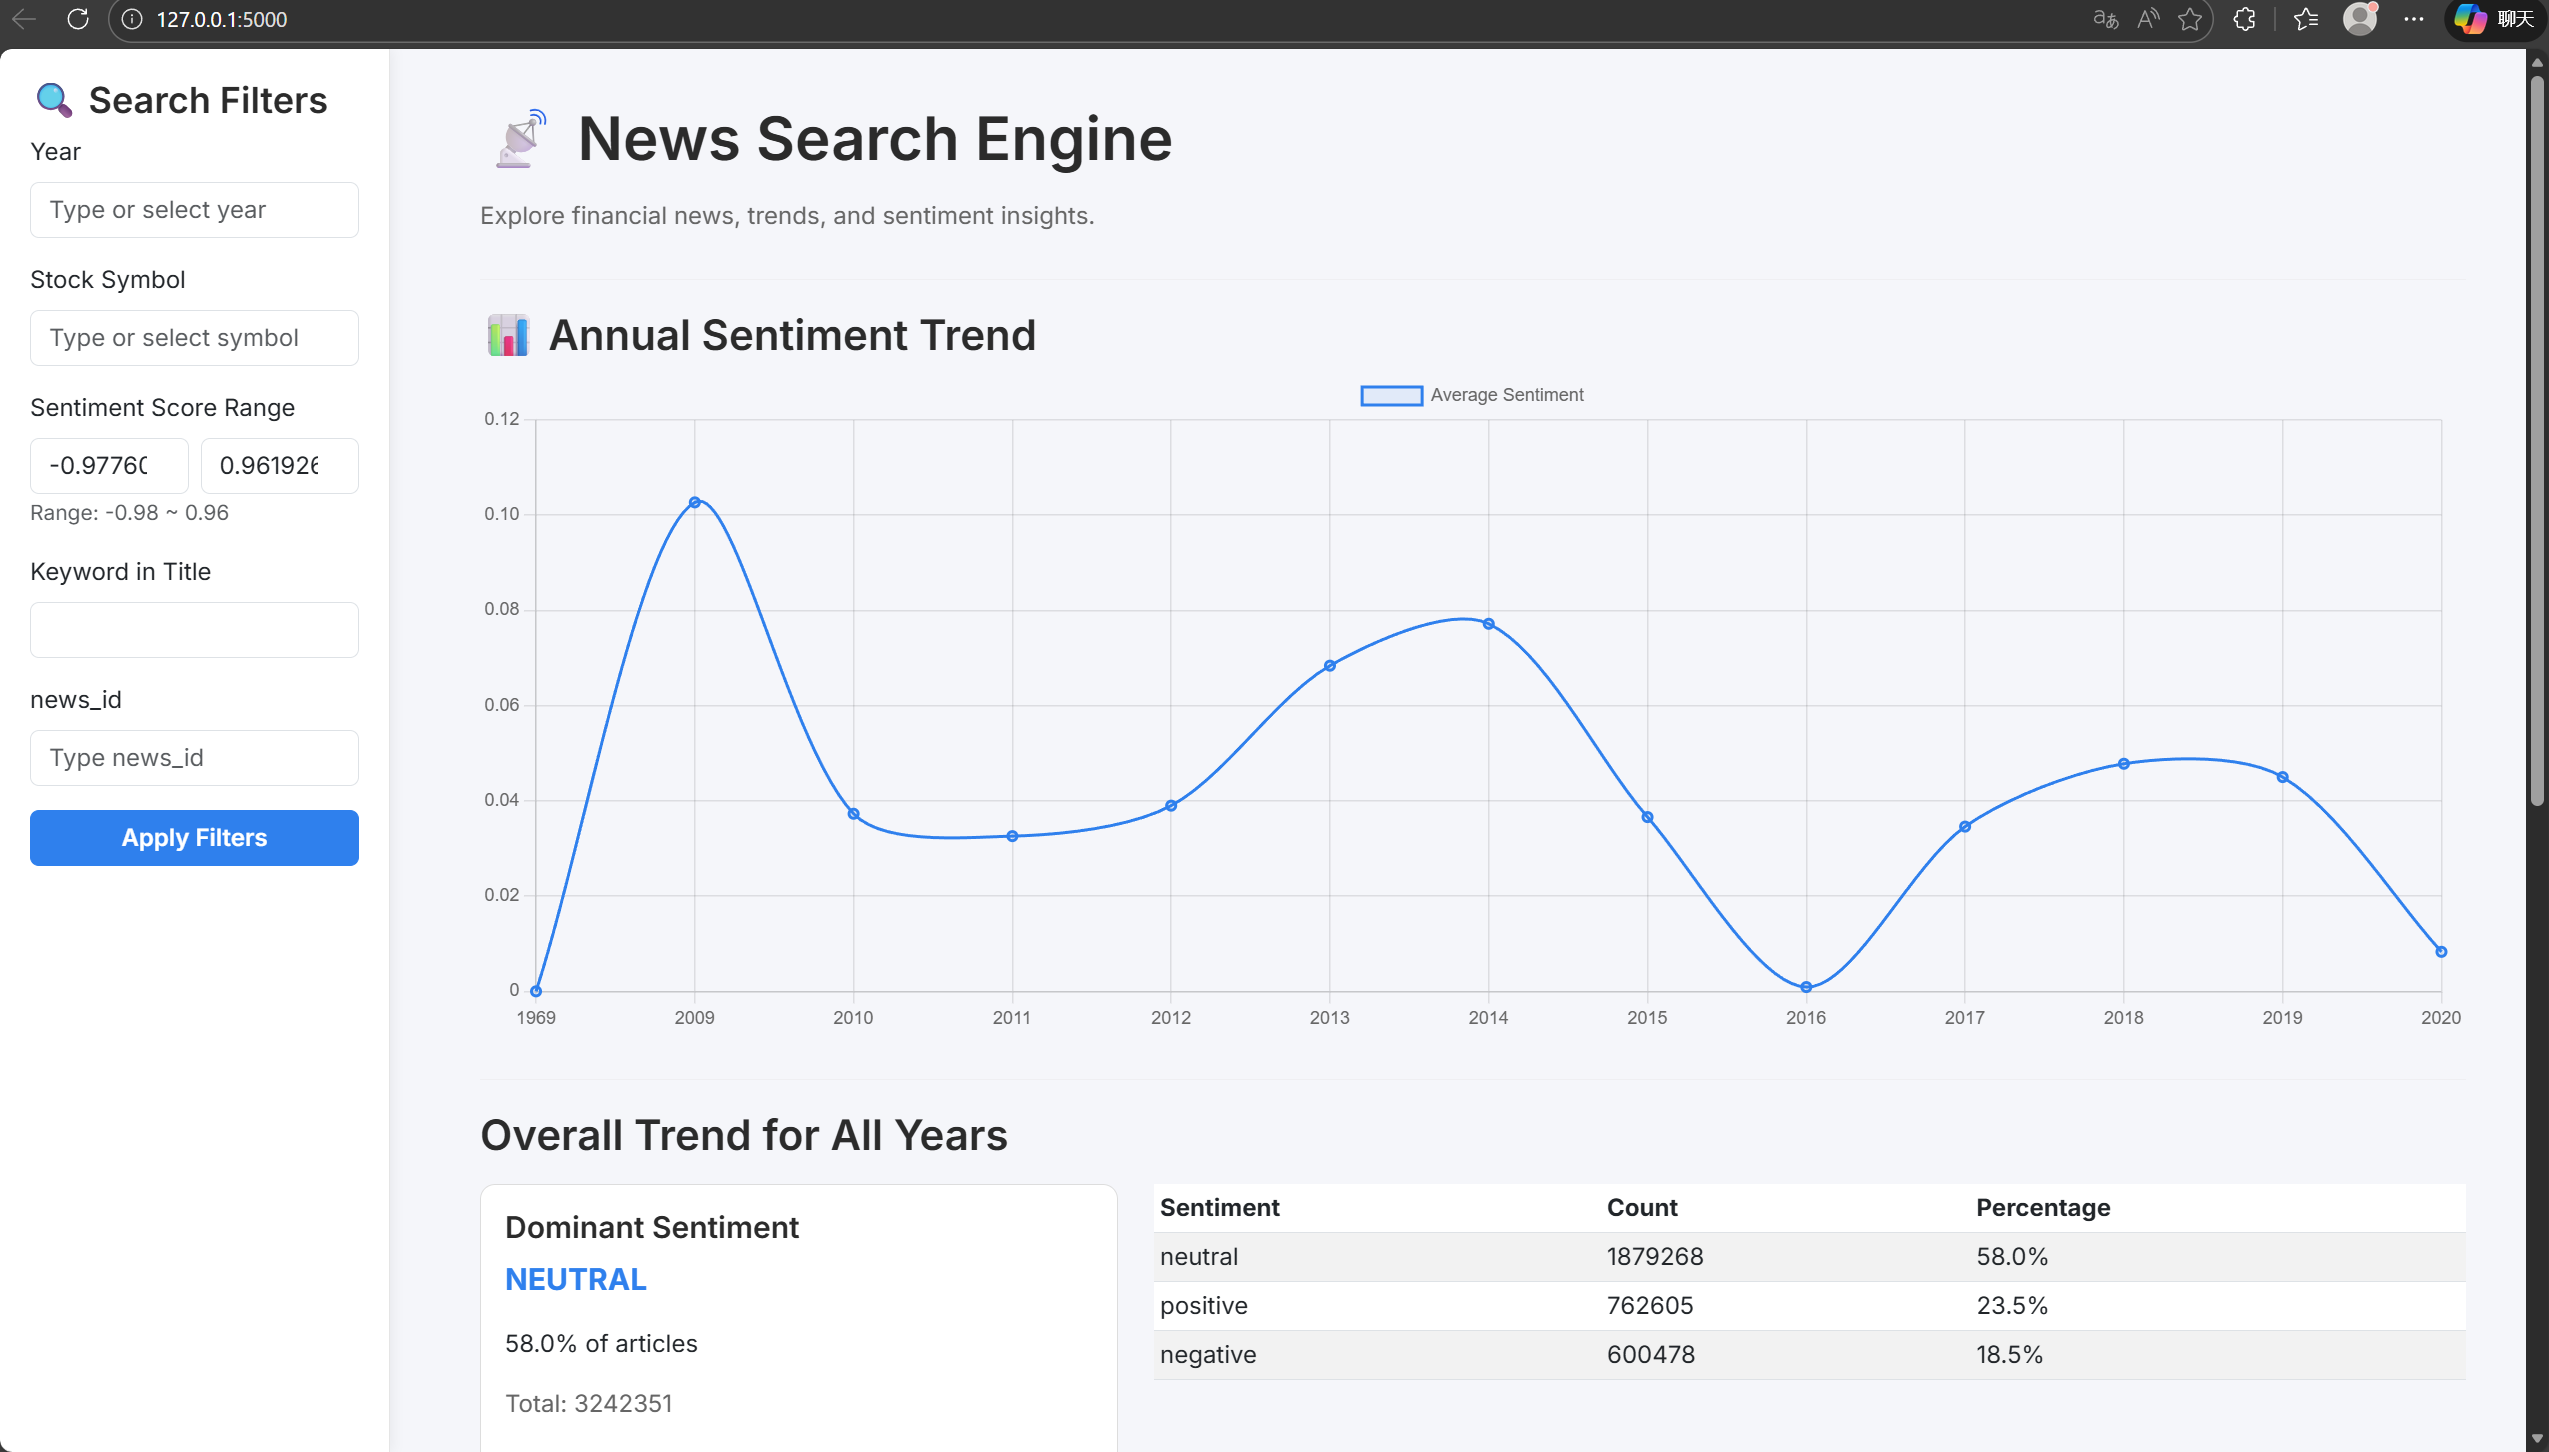
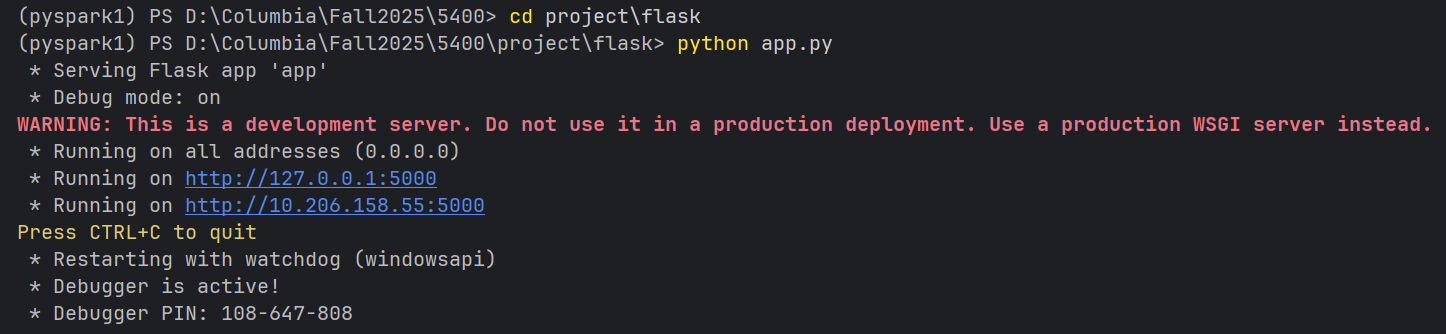
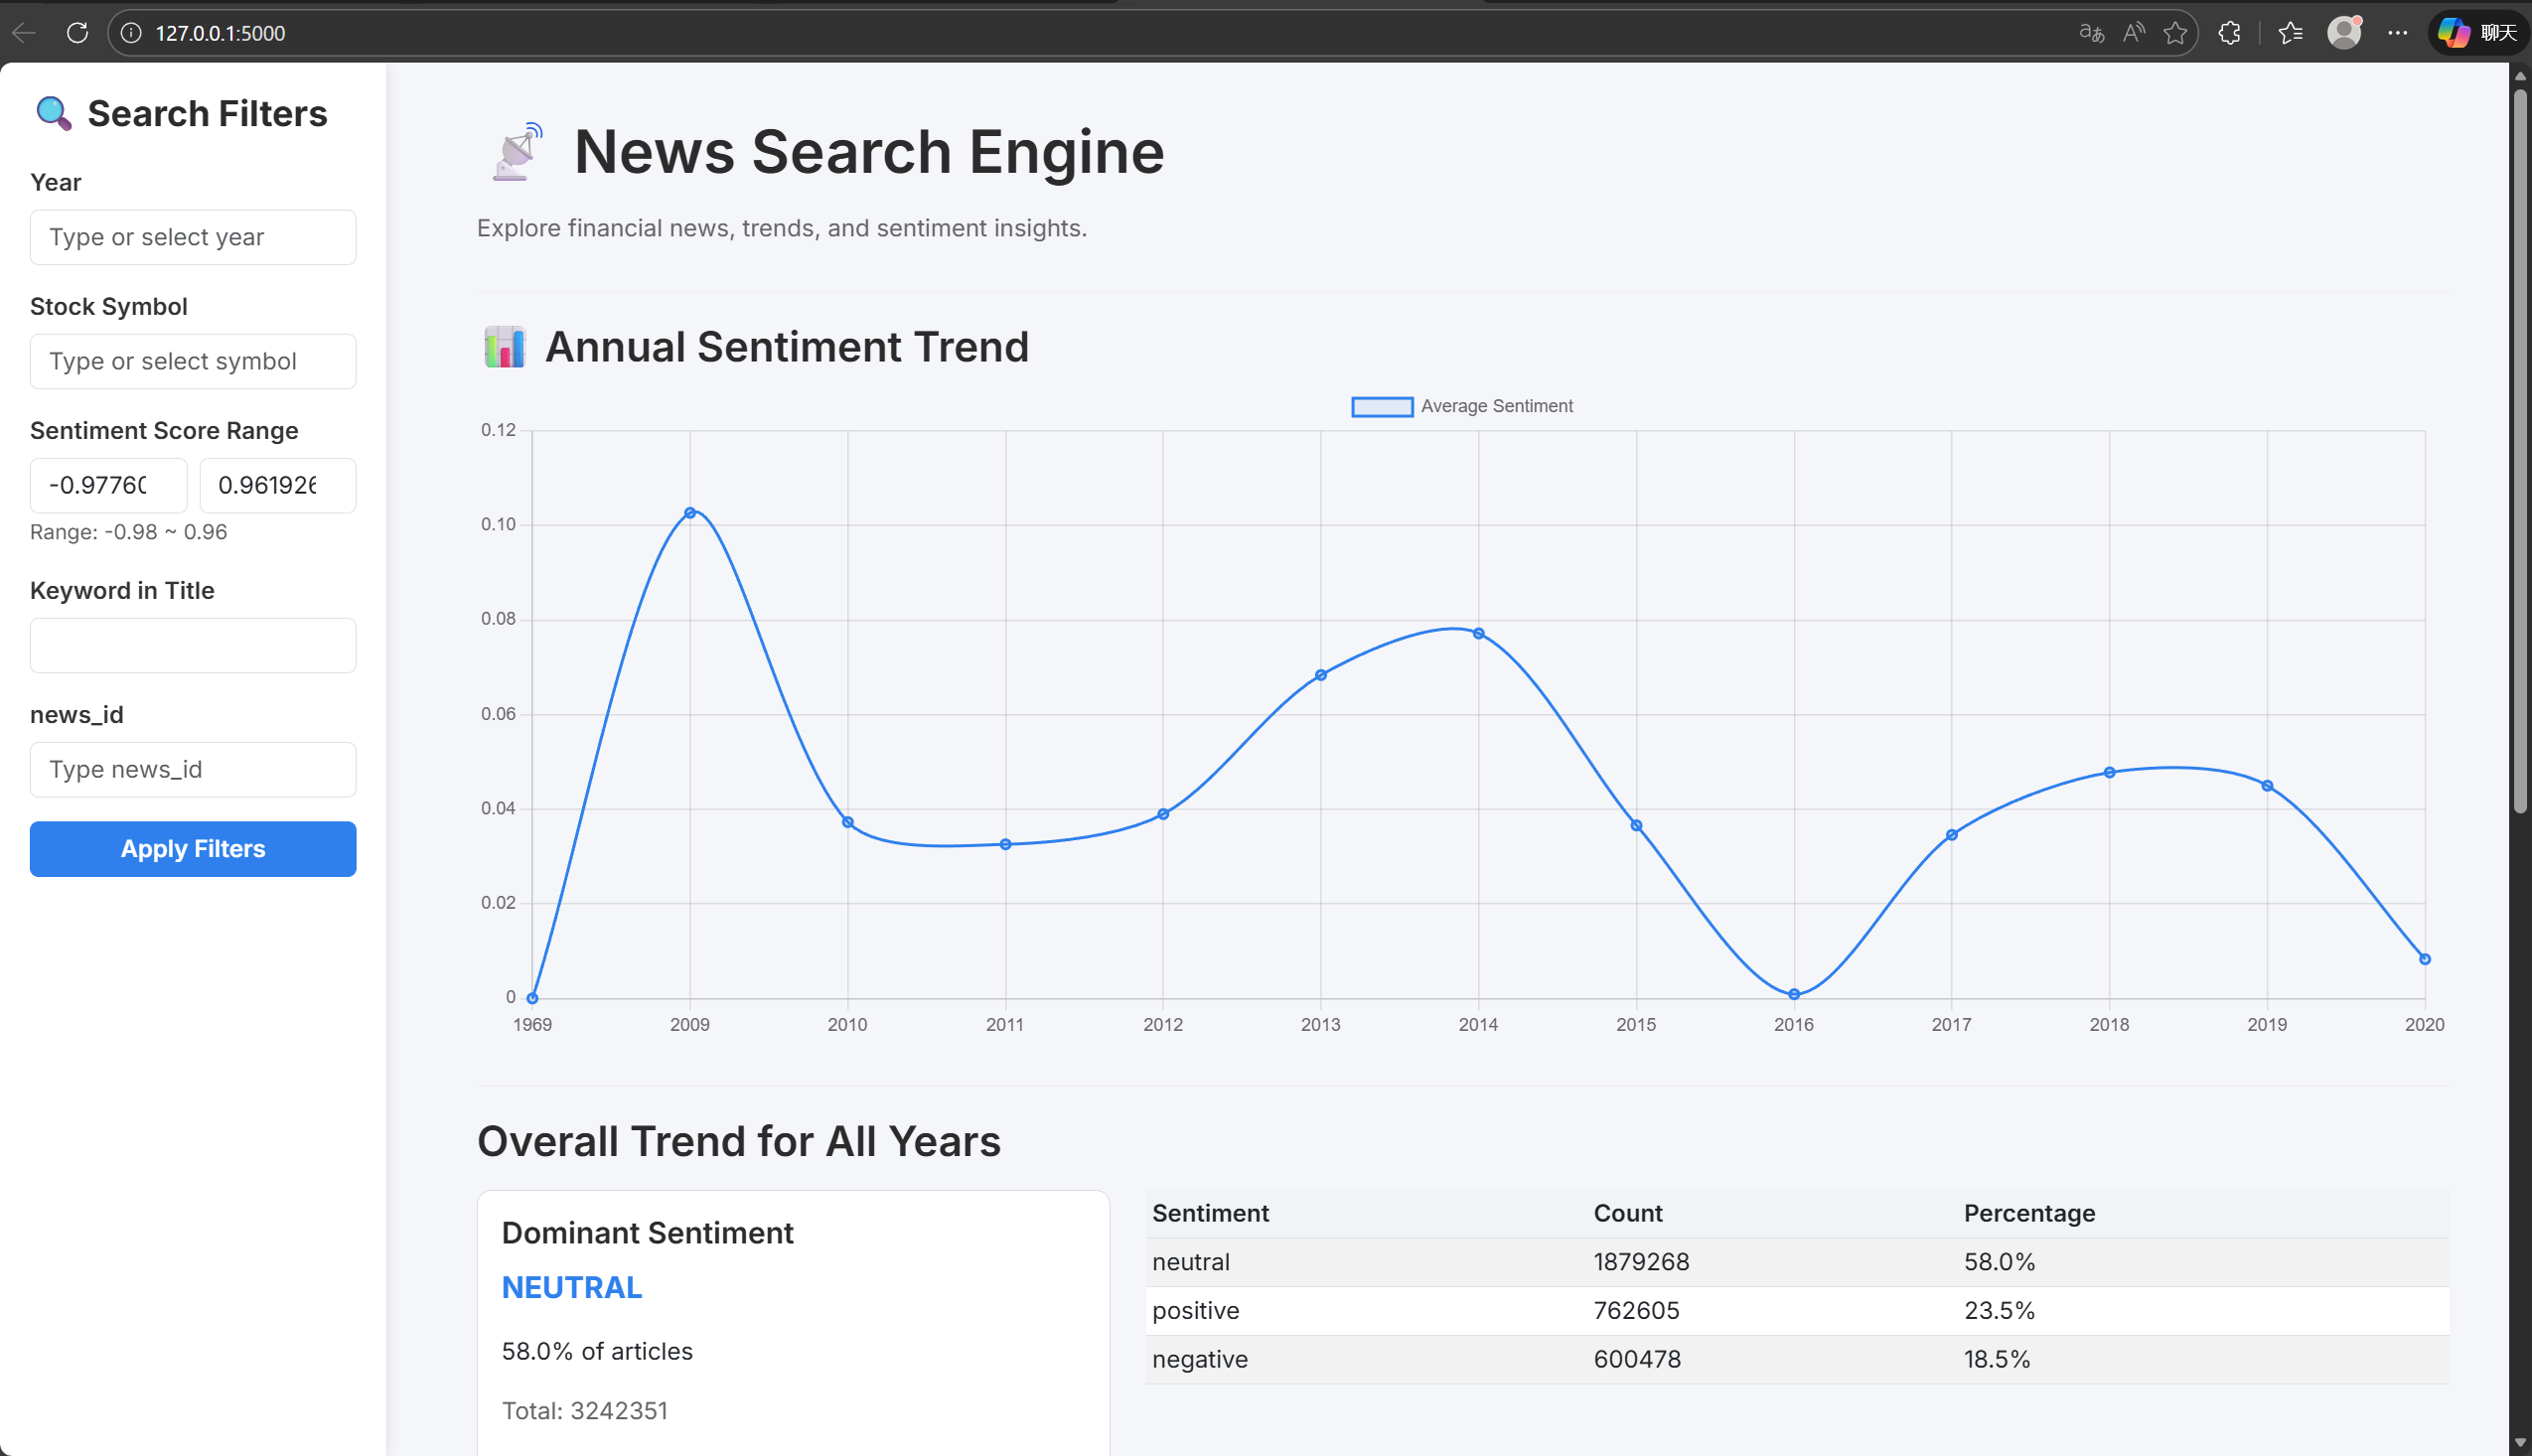

In [ ]:
from flask import Flask, render_template, request
import pandas as pd
import pyarrow.dataset as ds
import os
import time

app = Flask(__name__)

DATA_PATH = r"D:\Columbia\Fall2025\5400\project\layer\gold_with_sentiment_sample"

# 1) Load Parquet Folder (PyArrow Dataset)
def load_data(path: str) -> pd.DataFrame:
    """Load either a folder of parquet files or a single parquet/csv."""

    if not os.path.exists(path):
        raise FileNotFoundError(f"Data path not found: {path}")

    try:
        if os.path.isdir(path):
            dataset = ds.dataset(path, format="parquet")
            df = dataset.to_table().to_pandas()
        elif path.endswith(".parquet"):
            df = pd.read_parquet(path)
        elif path.endswith(".csv"):
            df = pd.read_csv(path)
        else:
            raise ValueError("Unsupported data file format.")
    except Exception as e:
        raise RuntimeError(f"Failed to load dataset: {e}")

    # ---- Normalize Date and Year ----
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df["Year"] = df["Date"].dt.year.astype("Int64")

    # ---- Normalize Stock Symbol ----
    if "Stock_symbol" in df.columns:
        df["Stock_symbol"] = df["Stock_symbol"].astype(str).str.strip().str.upper()

    return df

# Load at startup (with logging)
print("========================================")
print("📂 Loading Parquet dataset...")
print(f"📁 Path: {DATA_PATH}")
print("========================================")

start = time.time()

try:
    if os.path.isdir(DATA_PATH):
        file_list = [f for f in os.listdir(DATA_PATH) if f.endswith(".parquet")]
        print(f"🔍 Found {len(file_list)} parquet files. Loading...")

    DF = load_data(DATA_PATH)

    print("✅ Load completed!")
    print(f"📊 Total rows loaded: {len(DF):,}")
    print(f"⏱ Load time: {time.time() - start:.2f} s")
    print("========================================")

except Exception as e:
    print("❌ Failed to load dataset:", e)
    raise e

# Precompute dropdown options
YEARS = sorted(DF["Year"].dropna().unique().tolist()[::-1]) if "Year" in DF.columns else []
SYMBOLS = sorted(DF["Stock_symbol"].dropna().unique().tolist()) if "Stock_symbol" in DF.columns else []

if "sentiment_score_signed" in DF.columns:
    MIN_SCORE = float(DF["sentiment_score_signed"].min())
    MAX_SCORE = float(DF["sentiment_score_signed"].max())
else:
    MIN_SCORE = MAX_SCORE = None


# Helper functions
def compute_annual_trend(df: pd.DataFrame):
    if "Year" not in df.columns or "sentiment_score_signed" not in df.columns:
        return [], []
    annual = df.groupby("Year")["sentiment_score_signed"].mean().reset_index()
    return annual["Year"].tolist(), annual["sentiment_score_signed"].round(4).tolist()


def compute_yearly_summary(df: pd.DataFrame, selected_year):
    if selected_year not in ["", "all", None] and "Year" in df.columns:
        try:
            df_year = df[df["Year"] == int(selected_year)]
        except:
            df_year = df.copy()
    else:
        df_year = df.copy()

    if "sentiment_label" not in df_year.columns or df_year.empty:
        return {"total_articles": 0, "dominant_label": None, "dominant_pct": None, "summary_rows": []}

    counts = df_year["sentiment_label"].value_counts()
    total = int(counts.sum())
    if total == 0:
        return {"total_articles": 0, "dominant_label": None, "dominant_pct": None, "summary_rows": []}

    dom_label = counts.index[0]
    dom_pct = round(counts.iloc[0] / total * 100, 1)
    summary_rows = [{"Sentiment": label, "Count": int(cnt), "Percentage": f"{cnt/total*100:.1f}%"}
                    for label, cnt in counts.items()]

    return {"total_articles": total, "dominant_label": dom_label, "dominant_pct": dom_pct, "summary_rows": summary_rows}


# Flask Route
@app.route("/", methods=["GET"])
def index():
    selected_year = request.args.get("year", "all")
    selected_symbol = request.args.get("symbol", "all")
    keyword = request.args.get("keyword", "").strip()
    selected_news_id = request.args.get("news_id", "").strip()

    try:
        sent_min = float(request.args.get("sent_min", MIN_SCORE))
        sent_max = float(request.args.get("sent_max", MAX_SCORE))
    except:
        sent_min, sent_max = MIN_SCORE, MAX_SCORE

    # ----------- Filtering -----------
    filtered = DF.copy()

    # ---- Year ----
    if selected_year not in ["", "all", None]:
        try:
            filtered = filtered[filtered["Year"] == int(selected_year)]
        except:
            pass

    # ---- Symbol (normalize input) ----
    if selected_symbol not in ["", "all", None]:
        selected_symbol = selected_symbol.strip().upper()
        filtered = filtered[filtered["Stock_symbol"] == selected_symbol]

    # ---- Sentiment ----
    if MIN_SCORE is not None:
        filtered = filtered[
            (filtered["sentiment_score_signed"] >= sent_min) &
            (filtered["sentiment_score_signed"] <= sent_max)
        ]

    # ---- Keyword ----
    if keyword:
        filtered = filtered[
            filtered["Article_title"].str.contains(keyword, case=False, na=False)
        ]

    # ---- news_id ----
    if selected_news_id:
        filtered = filtered[filtered["news_id"].astype(str) == str(selected_news_id)]

    # ---- Sort ----
    if "Date" in filtered.columns:
        filtered = filtered.sort_values("Date", ascending=False)

    # Columns to show
    cols_to_show = [
        "Year", "Date", "Stock_symbol", "news_id", "Article_title",
        "sentiment_label", "sentiment_score_signed", "avg_sentiment_score",
        "article_count", "publisher_count", "avg_title_len", "sentiment_category",
    ]
    cols_to_show = [c for c in cols_to_show if c in filtered.columns]

    table_rows = filtered[cols_to_show].head(200).to_dict(orient="records")

    # ---- Detail ----
    selected_row = None
    if selected_news_id:
        match = filtered[filtered["news_id"].astype(str) == str(selected_news_id)]
        if not match.empty:
            selected_row = match.iloc[0].to_dict()

    # ---- Trend & Summary ----
    trend_years, trend_scores = compute_annual_trend(DF)
    yearly_summary = compute_yearly_summary(DF, selected_year)
    summary_title = "Overall Trend for All Years" if selected_year == "all" else f"Overall Trend for {selected_year}"

    return render_template(
        "index.html",
        years=YEARS,
        symbols=SYMBOLS,
        min_score=MIN_SCORE,
        max_score=MAX_SCORE,
        selected_year=selected_year,
        selected_symbol=selected_symbol,
        keyword=keyword,
        sent_min=sent_min,
        sent_max=sent_max,
        row_count=len(filtered),
        table_cols=cols_to_show,
        table_rows=table_rows,
        selected_news_id=selected_news_id,
        selected_row=selected_row,
        trend_years=trend_years,
        trend_scores=trend_scores,
        summary_title=summary_title,
        yearly_summary=yearly_summary,
    )


# Run app
if __name__ == "__main__":
    app.run(debug=True)


##### _base.html_

In [ ]:
# base.html
<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="UTF-8" />
    <title>{% block title %}News Search Engine{% endblock %}</title>
    <meta name="viewport" content="width=device-width, initial-scale=1" />

    <link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;600;700&display=swap" rel="stylesheet">
    <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" />
    <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>

    <style>
      body {
        font-family: 'Inter', sans-serif;
        background: #f5f6fa;
        margin: 0;
        padding: 0;
      }
      .sidebar {
        position: fixed;
        left: 0;
        top: 0;
        height: 100vh;
        width: 260px;
        background: #FFFFFF;
        border-right: 1px solid #E5E5E5;
        padding: 20px;
        overflow-y: auto;
        box-shadow: 2px 0 8px rgba(0,0,0,0.05);
      }
      .main-content {
        margin-left: 280px;
        padding: 35px 40px;
      }
      h1, h2, h3, h4, h5 {
        font-weight: 600;
        color: #2b2b2b;
      }
      .metric-box {
        background: #ffffff;
        border: 1px solid #ddd;
        padding: 16px;
        border-radius: 10px;
        text-align: left;
      }
      .btn-primary {
        background-color: #2F80ED;
        border-color: #2F80ED;
        font-weight: 600;
      }
      input, select {
        border-radius: 6px !important;
      }
      hr {
        border-top: 1px solid #ddd;
        margin-top: 30px;
        margin-bottom: 20px;
      }
    </style>
  </head>

  <body>
    <div class="sidebar">
      {% block sidebar %}{% endblock %}
    </div>

    <main class="main-content">
      {% block content %}{% endblock %}
    </main>
  </body>
</html>


##### _index.html_

In [ ]:
# index.html
{% extends "base.html" %}

{% block sidebar %}
<h4>🔍 Search Filters</h4>

<form method="get">

  <!-- Year -->
  <div class="mb-3">
    <label class="form-label">Year</label>
    <input
      list="yearOptions"
      name="year"
      class="form-control"
      placeholder="Type or select year"
      value="{{ selected_year if selected_year!='all' else '' }}"
    />
    <datalist id="yearOptions">
      <option value="all">(All)</option>
      {% for y in years %}
      <option value="{{ y }}">{{ y }}</option>
      {% endfor %}
    </datalist>
  </div>

  <!-- Symbol -->
  <div class="mb-3">
    <label class="form-label">Stock Symbol</label>
    <input
      list="symbolOptions"
      name="symbol"
      class="form-control"
      placeholder="Type or select symbol"
      value="{{ selected_symbol if selected_symbol!='all' else '' }}"
    />
    <datalist id="symbolOptions">
      <option value="all">(All)</option>
      {% for s in symbols %}
      <option value="{{ s }}">{{ s }}</option>
      {% endfor %}
    </datalist>
  </div>

  <!-- Sentiment -->
  <div class="mb-3">
    <label class="form-label">Sentiment Score Range</label>
    <div class="d-flex gap-2">
      <input type="number" name="sent_min" step="any" class="form-control" value="{{ sent_min }}" />
      <input type="number" name="sent_max" step="any" class="form-control" value="{{ sent_max }}" />
    </div>
    <small class="text-muted">Range: {{ min_score|round(2) }} ~ {{ max_score|round(2) }}</small>
  </div>

  <!-- Keyword -->
  <div class="mb-3">
    <label class="form-label">Keyword in Title</label>
    <input type="text" name="keyword" class="form-control" value="{{ keyword }}" />
  </div>

  <!-- news_id -->
  <div class="mb-3">
    <label class="form-label">news_id</label>
    <input type="text" name="news_id" class="form-control" placeholder="Type news_id" value="{{ selected_news_id }}" />
  </div>

  <button class="btn btn-primary w-100">Apply Filters</button>
</form>
{% endblock %}

{% block content %}
<h1 class="mb-3">📡 News Search Engine</h1>
<p style="color:#666;">Explore financial news, trends, and sentiment insights.</p>

<hr />

<!-- Trend -->
<h3>📊 Annual Sentiment Trend</h3>
<canvas id="trendChart" height="100"></canvas>

<script>
  new Chart(document.getElementById("trendChart"), {
    type: "line",
    data: {
      labels: {{ trend_years | tojson }},
      datasets: [
        {
          label: "Average Sentiment",
          data: {{ trend_scores | tojson }},
          borderColor: "#2F80ED",
          backgroundColor: "rgba(47,128,237,0.1)",
          tension: 0.3,
          borderWidth: 2
        }
      ]
    }
  });
</script>

<hr />

<h3>{{ summary_title }}</h3>

<div class="row mt-3">
  <div class="col-md-4">
    <div class="metric-box">
      {% if yearly_summary.total_articles > 0 %}
      <h5>Dominant Sentiment</h5>
      <p style="font-size:20px;font-weight:700;color:#2F80ED;">
        {{ yearly_summary.dominant_label | upper }}
      </p>
      <p>{{ yearly_summary.dominant_pct }}% of articles</p>
      <p style="color:#666;">Total: {{ yearly_summary.total_articles }}</p>
      {% else %}
      <p>No data available.</p>
      {% endif %}
    </div>
  </div>

  <div class="col-md-8">
    {% if yearly_summary.summary_rows %}
    <table class="table table-striped table-sm">
      <thead>
        <tr><th>Sentiment</th><th>Count</th><th>Percentage</th></tr>
      </thead>
      <tbody>
        {% for r in yearly_summary.summary_rows %}
        <tr>
          <td>{{ r.Sentiment }}</td>
          <td>{{ r.Count }}</td>
          <td>{{ r.Percentage }}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
    {% endif %}
  </div>
</div>

<hr />

<h3>🔎 Search Results ({{ row_count }} rows)</h3>

<div class="table-responsive" style="max-height:520px; overflow-y:auto;">
  <table class="table table-bordered table-sm table-hover align-middle">
    <thead class="table-light">
      <tr>
        {% for c in table_cols %}
        <th>{{ c }}</th>
        {% endfor %}
      </tr>
    </thead>
    <tbody>
      {% for r in table_rows %}
      <tr>
        {% for c in table_cols %}
        <td>{{ r[c] }}</td>
        {% endfor %}
      </tr>
      {% endfor %}
    </tbody>
  </table>
</div>

<hr />

<h3>📰 News Detail</h3>

{% if not selected_row %}
<p class="text-muted">Enter a news_id to view article details.</p>
{% else %}
<h4 style="font-weight:700;">{{ selected_row.Article_title }}</h4>

<h5 class="mt-3">🧠 Sentiment</h5>
<ul>
  {% for k in ["sentiment_label","sentiment_score_signed","avg_sentiment_score","pos_ratio","neg_ratio","sentiment_category"] %}
  {% if k in selected_row %}
  <li><b>{{ k }}:</b> {{ selected_row[k] }}</li>
  {% endif %}
  {% endfor %}
</ul>

<h5 class="mt-3">📌 Metadata</h5>
<ul>
  {% for col in ["Year","Date","Stock_symbol","sample_news_id","Publisher","Url","article_count","publisher_count","avg_title_len"] %}
  {% if col in selected_row %}
  <li><b>{{ col }}:</b> {{ selected_row[col] }}</li>
  {% endif %}
  {% endfor %}
</ul>
{% endif %}
{% endblock %}


##### (2) Flask(CSV)
cd D:\Columbia\Fall2025\5400\project\flask -> python app.py in terminal

Terminal:

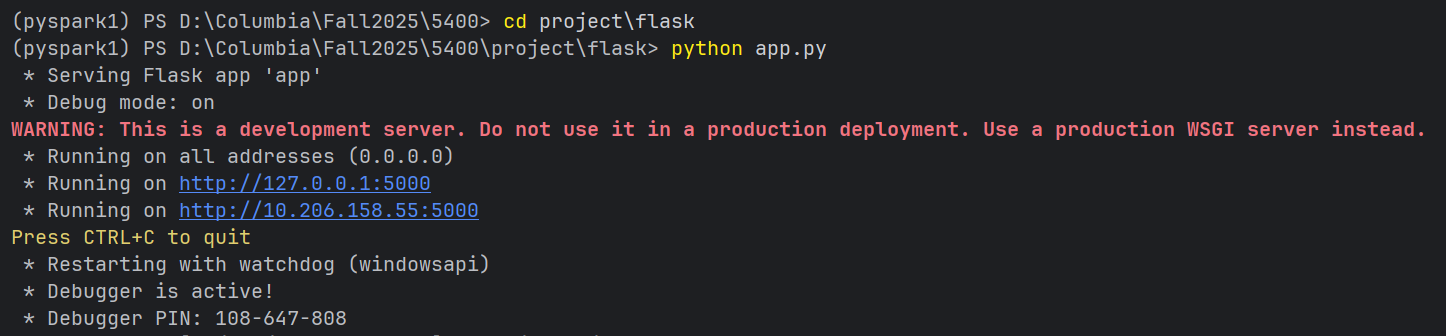

UI:

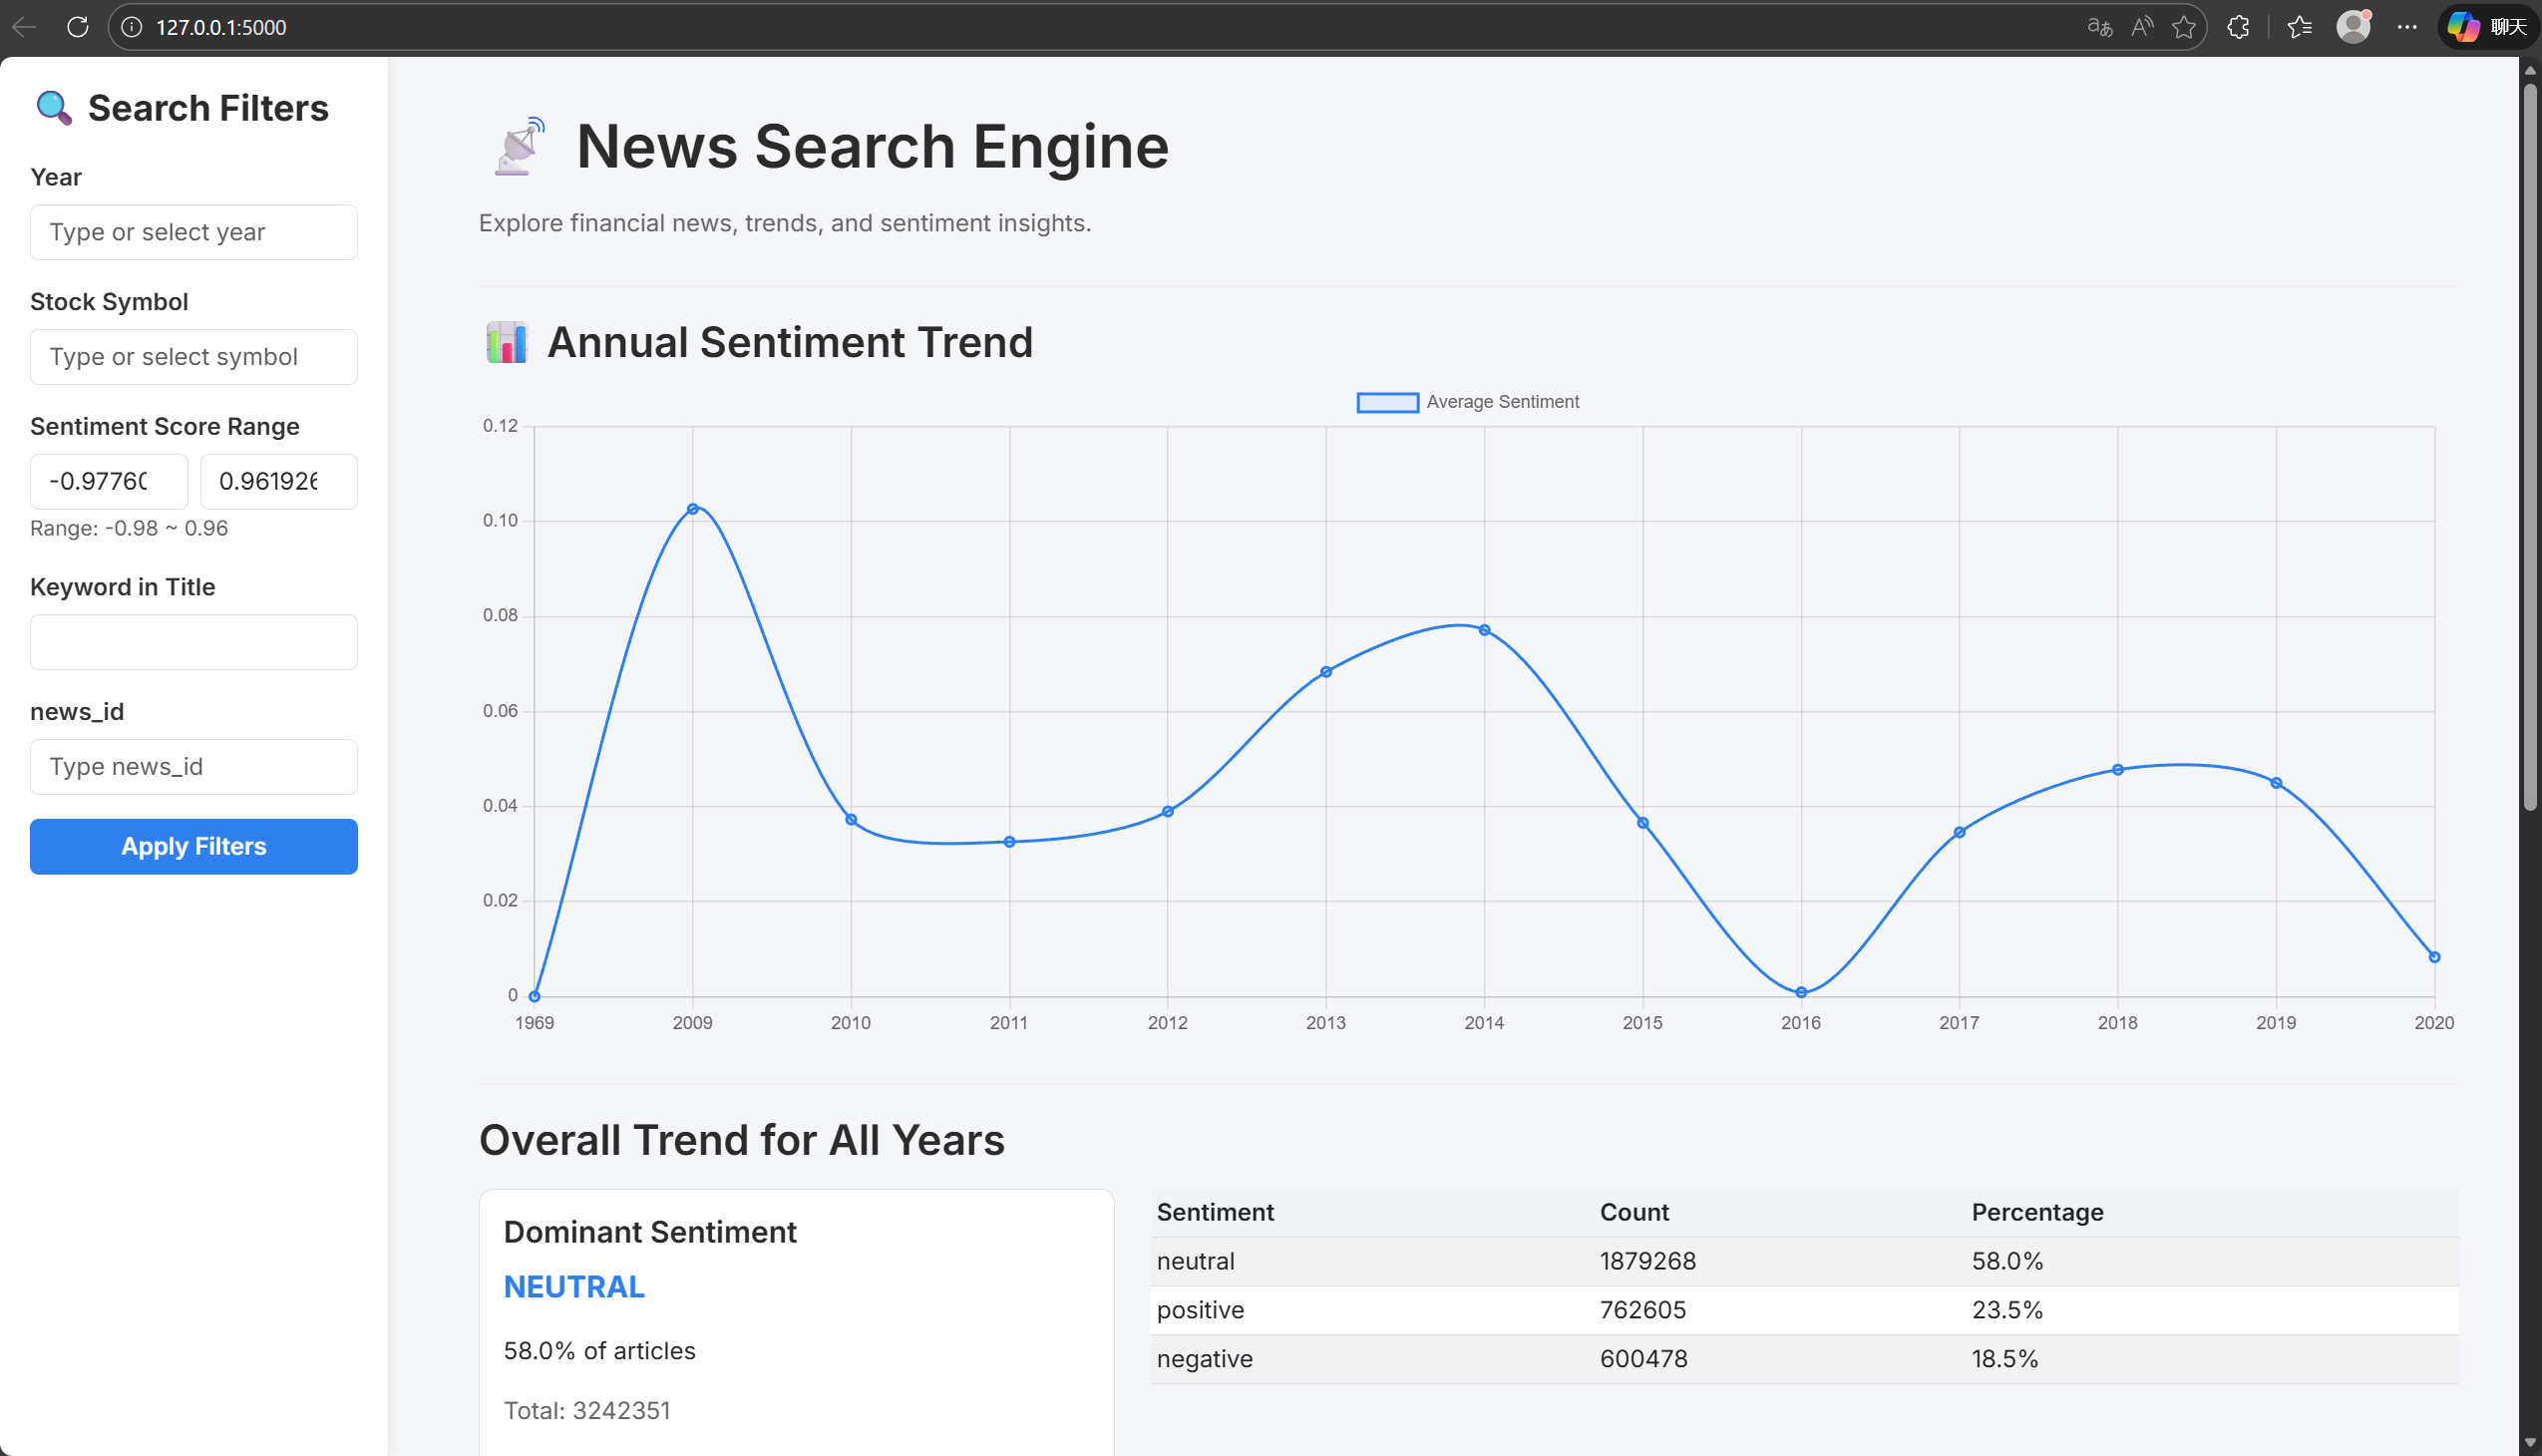

In [ ]:
from flask import Flask, render_template, request
import pandas as pd
import os

app = Flask(__name__)

# ------------ Config ------------
DEFAULT_FILENAME = "gold_with_sentiment_sample.csv"


def load_data(filename: str) -> pd.DataFrame:
    """Load CSV and preprocess."""
    if not os.path.exists(filename):
        raise FileNotFoundError(f"CSV not found: {filename}")

    df = pd.read_csv(filename)

    # Date → datetime & Year
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df["Year"] = df["Date"].dt.year.astype("Int64")

    return df


# Load once at startup
DF = load_data(DEFAULT_FILENAME)

# Precompute option lists
YEARS = sorted(DF["Year"].dropna().unique().tolist()[::-1]) if "Year" in DF.columns else []
SYMBOLS = sorted(DF["Stock_symbol"].dropna().unique().tolist()) if "Stock_symbol" in DF.columns else []

if "sentiment_score_signed" in DF.columns:
    MIN_SCORE = float(DF["sentiment_score_signed"].min())
    MAX_SCORE = float(DF["sentiment_score_signed"].max())
else:
    MIN_SCORE = MAX_SCORE = None


def compute_annual_trend(df: pd.DataFrame):
    if "Year" not in df.columns or "sentiment_score_signed" not in df.columns:
        return [], []
    annual = (
        df.groupby("Year")["sentiment_score_signed"]
        .mean()
        .reset_index()
        .dropna(subset=["Year"])
    )
    return annual["Year"].astype(int).tolist(), annual["sentiment_score_signed"].round(4).tolist()


def compute_yearly_summary(df: pd.DataFrame, selected_year):
    """Summary only filtered by year."""
    if "Year" in df.columns and selected_year != "all":
        try:
            df_year = df[df["Year"] == int(selected_year)]
        except:
            df_year = df.copy()
    else:
        df_year = df.copy()

    if "sentiment_label" not in df_year.columns or df_year.empty:
        return {
            "total_articles": 0,
            "dominant_label": None,
            "dominant_pct": None,
            "summary_rows": [],
        }

    counts = df_year["sentiment_label"].value_counts().sort_values(ascending=False)
    total = int(counts.sum())
    if total == 0:
        return {
            "total_articles": 0,
            "dominant_label": None,
            "dominant_pct": None,
            "summary_rows": [],
        }

    dom_label = counts.index[0]
    dom_pct = round(counts.iloc[0] / total * 100, 1)

    summary_rows = [
        {"Sentiment": label, "Count": int(cnt), "Percentage": f"{cnt/total*100:.1f}%"}
        for label, cnt in counts.items()
    ]

    return {
        "total_articles": total,
        "dominant_label": dom_label,
        "dominant_pct": dom_pct,
        "summary_rows": summary_rows,
    }


@app.route("/", methods=["GET"])
def index():
    # ----------- Read query params -----------
    selected_year = request.args.get("year", "all")
    selected_symbol = request.args.get("symbol", "all")
    keyword = request.args.get("keyword", "").strip()
    selected_news_id = request.args.get("news_id", "").strip()

    # Allow typing blank
    if selected_year == "":
        selected_year = "all"
    if selected_symbol == "":
        selected_symbol = "all"

    # sentiment range
    try:
        sent_min = float(request.args.get("sent_min", MIN_SCORE))
        sent_max = float(request.args.get("sent_max", MAX_SCORE))
    except:
        sent_min, sent_max = MIN_SCORE, MAX_SCORE

    # ----------- Filtering -----------
    filtered = DF.copy()

    # Year
    if selected_year != "all" and "Year" in filtered.columns:
        try:
            filtered = filtered[filtered["Year"] == int(selected_year)]
        except:
            pass

    # Symbol
    if selected_symbol != "all" and "Stock_symbol" in filtered.columns:
        filtered = filtered[filtered["Stock_symbol"] == selected_symbol]

    # Sentiment
    if MIN_SCORE is not None:
        filtered = filtered[
            (filtered["sentiment_score_signed"] >= sent_min)
            & (filtered["sentiment_score_signed"] <= sent_max)
        ]

    # Keyword
    if keyword and "Article_title" in filtered.columns:
        filtered = filtered[
            filtered["Article_title"].str.contains(keyword, case=False, na=False)
        ]

    # Sort
    if "Date" in filtered.columns and pd.api.types.is_datetime64_any_dtype(filtered["Date"]):
        filtered = filtered.sort_values("Date", ascending=False)

    # columns to show
    cols_to_show = [
        "Year", "Date", "Stock_symbol", "news_id", "Article_title",
        "sentiment_label", "sentiment_score_signed", "avg_sentiment_score",
        "article_count", "publisher_count",
        "avg_title_len", "sentiment_category",
    ]
    cols_to_show = [c for c in cols_to_show if c in filtered.columns]

    table_df = filtered[cols_to_show].head(200)
    table_rows = table_df.to_dict(orient="records")

    # ----------- Detail Section -----------
    selected_row = None
    if selected_news_id and not filtered.empty:
        try:
            nid_type = type(filtered["news_id"].iloc[0])
            nid = nid_type(selected_news_id)
            row = filtered[filtered["news_id"] == nid]
        except:
            row = filtered[filtered["news_id"].astype(str) == selected_news_id]

        if not row.empty:
            selected_row = row.iloc[0].to_dict()

    # ----------- Trend & Summary -----------
    trend_years, trend_scores = compute_annual_trend(DF)
    yearly_summary = compute_yearly_summary(DF, selected_year)
    summary_title = (
        "Overall Trend for All Years"
        if selected_year == "all"
        else f"Overall Trend for {selected_year}"
    )

    return render_template(
        "index.html",
        years=YEARS,
        symbols=SYMBOLS,
        min_score=MIN_SCORE,
        max_score=MAX_SCORE,
        selected_year=selected_year,
        selected_symbol=selected_symbol,
        keyword=keyword,
        sent_min=sent_min,
        sent_max=sent_max,
        row_count=len(filtered),
        table_cols=cols_to_show,
        table_rows=table_rows,
        selected_news_id=selected_news_id,
        selected_row=selected_row,
        trend_years=trend_years,
        trend_scores=trend_scores,
        summary_title=summary_title,
        yearly_summary=yearly_summary,
    )


if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000, debug=True)


In [ ]:
# base.html
<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="UTF-8" />
    <title>{% block title %}News Search Engine{% endblock %}</title>
    <meta name="viewport" content="width=device-width, initial-scale=1" />

    <!-- Google Font -->
    <link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;600;700&display=swap" rel="stylesheet">

    <!-- Bootstrap 5 -->
    <link
      rel="stylesheet"
      href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css"
    />

    <!-- Chart.js -->
    <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>

    <style>
      body {
        font-family: 'Inter', sans-serif;
        background: #f5f6fa;
        margin: 0;
        padding: 0;
      }

      /* Sidebar */
      .sidebar {
        position: fixed;
        left: 0;
        top: 0;
        height: 100vh;
        width: 260px;
        background: #FFFFFF;
        border-right: 1px solid #E5E5E5;
        padding: 20px;
        overflow-y: auto;
        box-shadow: 2px 0 8px rgba(0,0,0,0.05);
      }

      .sidebar h4 {
        font-weight: 700;
        margin-bottom: 20px;
      }

      /* Main content */
      .main-content {
        margin-left: 280px;
        padding: 35px 40px;
      }

      h1, h2, h3, h4, h5 {
        font-weight: 600;
        color: #2b2b2b;
      }

      .metric-box {
        background: #ffffff;
        border: 1px solid #ddd;
        padding: 16px;
        border-radius: 10px;
        text-align: left;
      }

      .table thead th {
        background: #f1f3f5;
        font-weight: 600;
      }

      .btn-primary {
        background-color: #2F80ED;
        border-color: #2F80ED;
        font-weight: 600;
      }

      .form-label {
        font-weight: 600;
        color: #333;
        margin-bottom: 6px;
      }

      input, select {
        border-radius: 6px !important;
      }

      hr {
        border-top: 1px solid #ddd;
        margin-top: 30px;
        margin-bottom: 20px;
      }
    </style>
  </head>

  <body>
    <div class="sidebar">
      {% block sidebar %}{% endblock %}
    </div>

    <main class="main-content">
      {% block content %}{% endblock %}
    </main>
  </body>
</html>


In [ ]:
# index.html
{% extends "base.html" %}

{% block sidebar %}
<h4>🔍 Search Filters</h4>

<form method="get">

  <!-- Year -->
  <div class="mb-3">
    <label class="form-label">Year</label>
    <input
      list="yearOptions"
      name="year"
      class="form-control"
      placeholder="Type or select year"
      value="{{ selected_year if selected_year!='all' else '' }}"
    />
    <datalist id="yearOptions">
      <option value="all">(All)</option>
      {% for y in years %}
      <option value="{{ y }}"></option>
      {% endfor %}
    </datalist>
  </div>

  <!-- Symbol -->
  <div class="mb-3">
    <label class="form-label">Stock Symbol</label>
    <input
      list="symbolOptions"
      name="symbol"
      class="form-control"
      placeholder="Type or select symbol"
      value="{{ selected_symbol if selected_symbol!='all' else '' }}"
    />
    <datalist id="symbolOptions">
      <option value="all">(All)</option>
      {% for s in symbols %}
      <option value="{{ s }}"></option>
      {% endfor %}
    </datalist>
  </div>

  <!-- Sentiment -->
  <div class="mb-3">
    <label class="form-label">Sentiment Score Range</label>
    <div class="d-flex gap-2">
      <input
        type="number"
        name="sent_min"
        step="any"
        class="form-control"
        value="{{ sent_min }}"
      />
      <input
        type="number"
        name="sent_max"
        step="any"
        class="form-control"
        value="{{ sent_max }}"
      />
    </div>
    <small class="text-muted">Range: {{ min_score|round(2) }} ~ {{ max_score|round(2) }}</small>
  </div>


  <!-- Keyword -->
  <div class="mb-3">
    <label class="form-label">Keyword in Title</label>
    <input type="text" name="keyword" class="form-control" value="{{ keyword }}" />
  </div>

  <!-- news_id -->
  <div class="mb-3">
    <label class="form-label">news_id</label>
    <input type="text" name="news_id" class="form-control" placeholder="Type news_id" value="{{ selected_news_id }}" />
  </div>

  <button class="btn btn-primary w-100">Apply Filters</button>
</form>
{% endblock %}

{% block content %}
<h1 class="mb-3">📡 News Search Engine</h1>
<p style="color:#666;">Explore financial news, trends, and sentiment insights.</p>

<hr />

<!-- Trend -->
<h3>📊 Annual Sentiment Trend</h3>
<canvas id="trendChart" height="100"></canvas>

<script>
  new Chart(document.getElementById("trendChart"), {
    type: "line",
    data: {
      labels: {{ trend_years | tojson }},
      datasets: [
        {
          label: "Average Sentiment",
          data: {{ trend_scores | tojson }},
          borderColor: "#2F80ED",
          backgroundColor: "rgba(47,128,237,0.1)",
          tension: 0.3,
          borderWidth: 2
        }
      ]
    }
  });
</script>

<hr />

<!-- Yearly Summary -->
<h3>{{ summary_title }}</h3>
<div class="row mt-3">
  <div class="col-md-4">
    <div class="metric-box">
      {% if yearly_summary.total_articles > 0 %}
      <h5 style="margin-bottom:10px;">Dominant Sentiment</h5>
      <p style="font-size:20px;font-weight:700;color:#2F80ED;">
        {{ yearly_summary.dominant_label | upper }}
      </p>
      <p>{{ yearly_summary.dominant_pct }}% of articles</p>
      <p style="color:#666;">Total: {{ yearly_summary.total_articles }}</p>
      {% else %}
      <p>No data available.</p>
      {% endif %}
    </div>
  </div>

  <div class="col-md-8">
    {% if yearly_summary.summary_rows %}
    <table class="table table-striped table-sm">
      <thead>
        <tr><th>Sentiment</th><th>Count</th><th>Percentage</th></tr>
      </thead>
      <tbody>
        {% for r in yearly_summary.summary_rows %}
        <tr>
          <td>{{ r.Sentiment }}</td>
          <td>{{ r.Count }}</td>
          <td>{{ r.Percentage }}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
    {% endif %}
  </div>
</div>

<hr />

<!-- Results Table -->
<h3>🔎 Search Results ({{ row_count }} rows)</h3>
<div class="table-responsive" style="max-height:520px; overflow-y:auto;">
  <table class="table table-bordered table-sm table-hover align-middle">
    <thead class="table-light">
      <tr>
        {% for c in table_cols %}
        <th>{{ c }}</th>
        {% endfor %}
      </tr>
    </thead>
    <tbody>
      {% for r in table_rows %}
      <tr>
        {% for c in table_cols %}
        <td>{{ r[c] }}</td>
        {% endfor %}
      </tr>
      {% endfor %}
    </tbody>
  </table>
</div>

<hr />

<!-- Detail -->
<h3>📰 News Detail</h3>
{% if not selected_row %}
<p class="text-muted">Enter a news_id to view article details.</p>
{% else %}
<h4 style="font-weight:700;">{{ selected_row.Article_title }}</h4>

<h5 class="mt-3">🧠 Sentiment</h5>
<ul>
  {% for k in ["sentiment_label","sentiment_score_signed","avg_sentiment_score","pos_ratio","neg_ratio","sentiment_category"] %}
  {% if k in selected_row %}
  <li><b>{{ k }}:</b> {{ selected_row[k] }}</li>
  {% endif %}
  {% endfor %}
</ul>

<h5 class="mt-3">📌 Metadata</h5>
<ul>
  {% for col in ["Year","Date","Stock_symbol","sample_news_id","Publisher","Url","article_count","publisher_count","avg_title_len"] %}
  {% if col in selected_row %}
  <li><b>{{ col }}:</b> {{ selected_row[col] }}</li>
  {% endif %}
  {% endfor %}
</ul>
{% endif %}

{% endblock %}
